In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from torch.autograd import Variable
from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize=-1
dim_div_by = 64
dtype = torch.cuda.FloatTensor

In [3]:
col_path  = 'data/inpainting/6_col.png'
img_path  = 'data/inpainting/6.png'
mask_path = 'data/inpainting/6_mask_dil.png'

In [4]:
img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)
img_col_pil, img_col_np=get_image(col_path,imsize)

In [5]:
'''
def to_rgb1a(im):
    # This should be fsater than 1, as we only
    # truncate to uint8 once (?)
    w, h,d = im.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 2] =  ret[:, :, 1] =  ret[:, :, 0] 
    return ret
'''

'\ndef to_rgb1a(im):\n    # This should be fsater than 1, as we only\n    # truncate to uint8 once (?)\n    w, h,d = im.shape\n    ret = np.empty((w, h, 3), dtype=np.uint8)\n    ret[:, :, 2] =  ret[:, :, 1] =  ret[:, :, 0] \n    return ret\n'

In [6]:
#im=to_rgb1a(im1)

In [7]:
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)
img_col_pil  = crop_image(img_col_pil, dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)
img_col_np  = pil_to_np(img_col_pil)

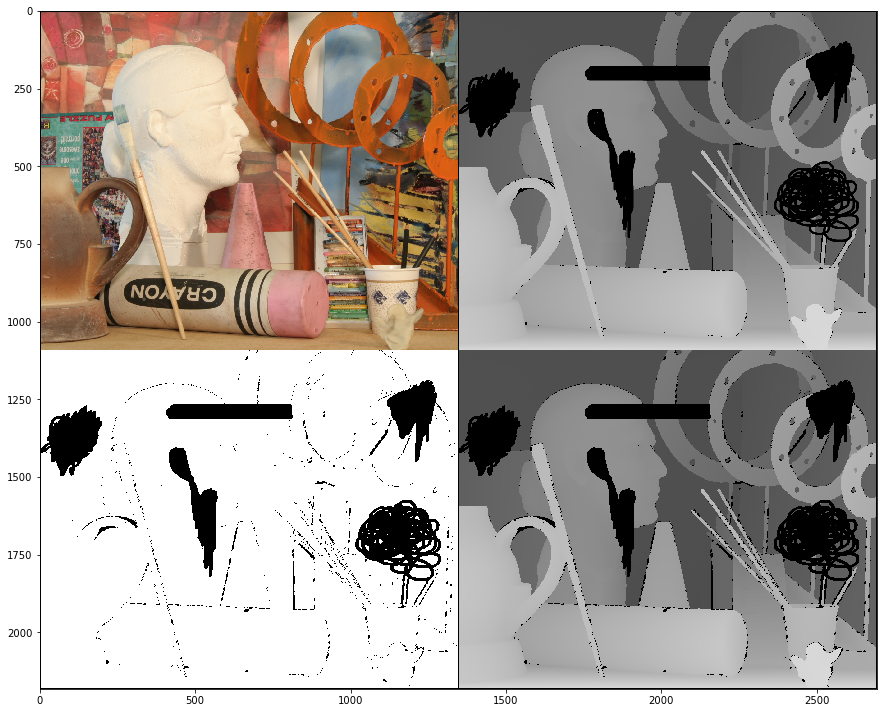

In [8]:
img_mask_var = np_to_var(img_mask_np) #.type(dtype)

plot_image_grid([img_col_np,img_np, img_mask_np, img_mask_np*img_np], 2,11);

In [9]:
print(img_col_np[:,334:544,0:6 ])

[[[ 0.20784314  0.2         0.2         0.17254902  0.16862746  0.17254902]
  [ 0.2         0.2         0.20392157  0.17254902  0.16470589  0.15294118]
  [ 0.19607843  0.2         0.21568628  0.15686275  0.16078432  0.17254902]
  ..., 
  [ 0.73725492  0.73725492  0.73725492  0.73725492  0.74117649  0.74117649]
  [ 0.74509805  0.74901962  0.74901962  0.74901962  0.74509805  0.74509805]
  [ 0.74509805  0.74509805  0.74509805  0.74901962  0.74117649  0.74117649]]

 [[ 0.40784314  0.39607844  0.39607844  0.37254903  0.36862746  0.37254903]
  [ 0.40784314  0.40784314  0.41568628  0.3882353   0.38431373  0.37254903]
  [ 0.40392157  0.40392157  0.41568628  0.36078432  0.36470589  0.3764706 ]
  ..., 
  [ 0.60784316  0.60784316  0.60784316  0.61176473  0.6156863   0.61176473]
  [ 0.60784316  0.61176473  0.61960787  0.62352943  0.61960787  0.61960787]
  [ 0.61960787  0.6156863   0.6156863   0.62352943  0.6156863   0.6156863 ]]

 [[ 0.3882353   0.36470589  0.36078432  0.34509805  0.34117648  0.34

In [10]:
print(img_np[:,567:569,0:6 ])

[[[ 0.73333335  0.73333335  0.73333335  0.73333335  0.73333335  0.73333335]
  [ 0.73333335  0.73333335  0.73333335  0.73333335  0.73333335  0.73333335]]

 [[ 0.73333335  0.73333335  0.73333335  0.73333335  0.73333335  0.73333335]
  [ 0.73333335  0.73333335  0.73333335  0.73333335  0.73333335  0.73333335]]

 [[ 0.73333335  0.73333335  0.73333335  0.73333335  0.73333335  0.73333335]
  [ 0.73333335  0.73333335  0.73333335  0.73333335  0.73333335  0.73333335]]]


In [11]:
'''
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

plt.figure()
im = plt.imshow(img_col_np, interpolation='bilinear', origin='lower',
                cmap=cm.gray, extent=(-3, 3, -2, 2))
levels = np.arange(-1.2, 1.6, 0.2)
CS = plt.contour(img_col_np, levels,
                 origin='lower',
                 linewidths=2,
                 extent=(-3, 3, -2, 2))
                 
'''

"\nimport matplotlib\nimport numpy as np\nimport matplotlib.cm as cm\nimport matplotlib.mlab as mlab\nimport matplotlib.pyplot as plt\n\nplt.figure()\nim = plt.imshow(img_col_np, interpolation='bilinear', origin='lower',\n                cmap=cm.gray, extent=(-3, 3, -2, 2))\nlevels = np.arange(-1.2, 1.6, 0.2)\nCS = plt.contour(img_col_np, levels,\n                 origin='lower',\n                 linewidths=2,\n                 extent=(-3, 3, -2, 2))\n                 \n"

In [12]:
#print(img_mask_np.shape[1])
[c,a,b]=img_mask_np.shape
#print(a,b,c)
#print(abs(-4))
x=[]
#print(img_mask_np[2,566,655])
count=0
co=0
max1=100
np.zeros(x)
''''''
def al(p,q):
    return img_col_np[0,p,q]+img_col_np[1,p,q]+img_col_np[2,p,q]

def app(p,q,t):
    if img_mask_np[0,p,q]==0:       #img_np*img_mask_np
        return 0
    else :
        return al(p,q)


for p in range(a-1):
    for q in range(b-1):
        co=co+1
        if img_mask_np[0,p,q]==0:        #img_np*img_mask_np
            count=count+1
            #print(img_np[0,p,q])
            t=img_col_np[0,p,q]+img_col_np[1,p,q]+img_col_np[2,p,q]
            x.append(abs(t-app(p-1,q,t)))
            #print('1',img_np[0,p-1,q])
            x.append(abs(t-app(p+1,q,t)))
            #print('2',img_np[0,p+1,q])
            x.append(abs(t-app(p,q-1,t)))
            #print('3',img_np[0,p,q-1])
            x.append(abs(t-app(p,q+1,t)))
            #print('4',img_np[0,p,q+1])
            
            x.append(abs(t-app(p-1,q-1,t)))
            x.append(abs(t-app(p-1,q+1,t)))
            x.append(abs(t-app(p+1,q-1,t)))
            x.append(abs(t-app(p+1,q+1,t)))
            
            
            
            #print(t)
            for r in range(8):
                if(x[r]<max1):
                    max1=x[r]
                    j=r
                    #print(max1,j,p,q)
            f={0:[p-1,q],
                1:[p+1, q],
                2:[p, q-1],
                3:[p, q+1],
               4:[p-1,q-1],
               5:[p-1,q+1],
               6:[p+1,q-1],
               7:[p+1,q+1],
              }
            #print (j)
            if j in f:
                [p1,q1]=f[j]
                
            print(f[j],q1,p1)
            #print(img_np[0,p,q],img_np[0,p1,q1])
            img_np[:,p,q]=img_np[:,p1,q1]
        max1=100           
        x[:]=[]        
            #print('1')
''''''
'''for r in img_mask_np:
    if(r.any()==1):
        count=count+1'''
print(count,co,max1)

[1, 673] 673 1
[1, 673] 673 1
[0, 695] 695 0
[1, 698] 698 1
[1, 698] 698 1
[0, 1005] 1005 0
[1, 1006] 1006 1
[1, 1089] 1089 1
[1, 1092] 1092 1
[1, 1093] 1093 1
[1, 1098] 1098 1
[1, 1097] 1097 1
[-1, 1132] 1132 -1
[1, 1135] 1135 1
[0, 671] 671 0
[0, 695] 695 0
[2, 697] 697 2
[0, 1005] 1005 0
[1, 1095] 1095 1
[0, 1131] 1131 0
[2, 1133] 1133 2
[0, 1135] 1135 0
[3, 670] 670 3
[2, 671] 671 2
[1, 699] 699 1
[1, 700] 700 1
[3, 1003] 1003 3
[1, 1003] 1003 1
[3, 1094] 1094 3
[2, 1096] 1096 2
[1, 1102] 1102 1
[1, 1102] 1102 1
[3, 1129] 1129 3
[1, 1131] 1131 1
[3, 1133] 1133 3
[2, 697] 697 2
[2, 697] 697 2
[2, 700] 700 2
[3, 1099] 1099 3
[4, 1130] 1130 4
[4, 1132] 1132 4
[3, 696] 696 3
[3, 696] 696 3
[3, 696] 696 3
[3, 698] 698 3
[4, 700] 700 4
[3, 1097] 1097 3
[3, 1099] 1099 3
[4, 694] 694 4
[4, 696] 696 4
[4, 697] 697 4
[4, 698] 698 4
[4, 700] 700 4
[4, 1004] 1004 4
[4, 1005] 1005 4
[4, 1136] 1136 4
[4, 1137] 1137 4
[7, 693] 693 7
[5, 694] 694 5
[5, 696] 696 5
[7, 698] 698 7
[7, 698] 698 7
[5, 

[106, 441] 441 106
[106, 443] 443 106
[106, 443] 443 106
[108, 855] 855 108
[106, 856] 856 106
[106, 860] 860 106
[106, 862] 862 106
[107, 863] 863 107
[108, 864] 864 108
[108, 867] 867 108
[106, 1188] 1188 106
[107, 1190] 1190 107
[106, 1221] 1221 106
[106, 1223] 1223 106
[106, 1224] 1224 106
[106, 1225] 1225 106
[106, 1226] 1226 106
[106, 1227] 1227 106
[106, 1228] 1228 106
[106, 1229] 1229 106
[106, 1230] 1230 106
[106, 1231] 1231 106
[106, 1232] 1232 106
[106, 1233] 1233 106
[106, 1234] 1234 106
[106, 1235] 1235 106
[106, 1236] 1236 106
[106, 1237] 1237 106
[106, 1238] 1238 106
[106, 1239] 1239 106
[106, 1240] 1240 106
[106, 1241] 1241 106
[106, 1242] 1242 106
[106, 1243] 1243 106
[106, 1244] 1244 106
[106, 1245] 1245 106
[106, 1246] 1246 106
[106, 1247] 1247 106
[106, 1248] 1248 106
[106, 1249] 1249 106
[106, 1250] 1250 106
[106, 1251] 1251 106
[106, 1252] 1252 106
[106, 1253] 1253 106
[106, 1254] 1254 106
[106, 1255] 1255 106
[106, 1256] 1256 106
[106, 1257] 1257 106
[106, 1258] 

[114, 1238] 1238 114
[114, 1239] 1239 114
[114, 1240] 1240 114
[114, 1241] 1241 114
[114, 1242] 1242 114
[114, 1243] 1243 114
[114, 1244] 1244 114
[114, 1245] 1245 114
[114, 1246] 1246 114
[114, 1247] 1247 114
[114, 1248] 1248 114
[114, 1249] 1249 114
[114, 1250] 1250 114
[114, 1251] 1251 114
[114, 1252] 1252 114
[114, 1253] 1253 114
[114, 1254] 1254 114
[114, 1255] 1255 114
[114, 1256] 1256 114
[114, 1257] 1257 114
[114, 1258] 1258 114
[114, 1259] 1259 114
[114, 1260] 1260 114
[114, 1261] 1261 114
[114, 1262] 1262 114
[114, 1263] 1263 114
[114, 1264] 1264 114
[115, 1266] 1266 115
[116, 357] 357 116
[115, 360] 360 115
[115, 361] 361 115
[115, 361] 361 115
[117, 363] 363 117
[117, 363] 363 117
[117, 364] 364 117
[115, 499] 499 115
[116, 502] 502 116
[116, 508] 508 116
[117, 511] 511 117
[115, 698] 698 115
[117, 701] 701 117
[117, 701] 701 117
[115, 817] 817 115
[115, 818] 818 115
[116, 820] 820 116
[117, 1190] 1190 117
[116, 1196] 1196 116
[115, 1198] 1198 115
[115, 1199] 1199 115
[115,

[124, 1188] 1188 124
[124, 1189] 1189 124
[124, 1190] 1190 124
[124, 1191] 1191 124
[124, 1192] 1192 124
[124, 1193] 1193 124
[124, 1194] 1194 124
[124, 1195] 1195 124
[124, 1196] 1196 124
[124, 1197] 1197 124
[124, 1198] 1198 124
[124, 1199] 1199 124
[124, 1200] 1200 124
[124, 1201] 1201 124
[124, 1202] 1202 124
[124, 1203] 1203 124
[124, 1204] 1204 124
[124, 1205] 1205 124
[124, 1206] 1206 124
[124, 1207] 1207 124
[124, 1208] 1208 124
[124, 1209] 1209 124
[124, 1210] 1210 124
[124, 1211] 1211 124
[124, 1212] 1212 124
[124, 1213] 1213 124
[124, 1214] 1214 124
[124, 1215] 1215 124
[124, 1216] 1216 124
[124, 1217] 1217 124
[124, 1218] 1218 124
[124, 1219] 1219 124
[124, 1220] 1220 124
[124, 1221] 1221 124
[124, 1222] 1222 124
[124, 1223] 1223 124
[124, 1224] 1224 124
[124, 1225] 1225 124
[124, 1226] 1226 124
[124, 1227] 1227 124
[124, 1228] 1228 124
[124, 1229] 1229 124
[124, 1230] 1230 124
[124, 1231] 1231 124
[124, 1232] 1232 124
[124, 1233] 1233 124
[124, 1234] 1234 124
[124, 1235] 1

[134, 1128] 1128 134
[132, 1152] 1152 132
[132, 1154] 1154 132
[132, 1155] 1155 132
[133, 1159] 1159 133
[132, 1160] 1160 132
[132, 1162] 1162 132
[132, 1163] 1163 132
[132, 1164] 1164 132
[132, 1165] 1165 132
[132, 1166] 1166 132
[132, 1167] 1167 132
[132, 1168] 1168 132
[132, 1169] 1169 132
[132, 1170] 1170 132
[132, 1171] 1171 132
[132, 1172] 1172 132
[132, 1173] 1173 132
[132, 1174] 1174 132
[132, 1175] 1175 132
[132, 1176] 1176 132
[132, 1177] 1177 132
[132, 1178] 1178 132
[132, 1179] 1179 132
[132, 1180] 1180 132
[132, 1181] 1181 132
[132, 1182] 1182 132
[132, 1183] 1183 132
[132, 1184] 1184 132
[132, 1185] 1185 132
[132, 1186] 1186 132
[132, 1187] 1187 132
[132, 1188] 1188 132
[132, 1189] 1189 132
[132, 1190] 1190 132
[132, 1191] 1191 132
[132, 1192] 1192 132
[132, 1193] 1193 132
[132, 1194] 1194 132
[132, 1195] 1195 132
[132, 1196] 1196 132
[132, 1197] 1197 132
[132, 1198] 1198 132
[132, 1199] 1199 132
[132, 1200] 1200 132
[132, 1201] 1201 132
[132, 1202] 1202 132
[132, 1203] 1

[138, 1153] 1153 138
[138, 1154] 1154 138
[138, 1155] 1155 138
[138, 1156] 1156 138
[138, 1157] 1157 138
[138, 1158] 1158 138
[138, 1159] 1159 138
[138, 1160] 1160 138
[138, 1161] 1161 138
[138, 1162] 1162 138
[138, 1163] 1163 138
[138, 1164] 1164 138
[138, 1165] 1165 138
[138, 1166] 1166 138
[138, 1167] 1167 138
[138, 1168] 1168 138
[138, 1169] 1169 138
[138, 1170] 1170 138
[138, 1171] 1171 138
[138, 1172] 1172 138
[138, 1173] 1173 138
[138, 1174] 1174 138
[138, 1175] 1175 138
[138, 1176] 1176 138
[138, 1177] 1177 138
[138, 1178] 1178 138
[138, 1179] 1179 138
[138, 1180] 1180 138
[138, 1181] 1181 138
[138, 1182] 1182 138
[138, 1183] 1183 138
[138, 1184] 1184 138
[138, 1185] 1185 138
[138, 1186] 1186 138
[138, 1187] 1187 138
[138, 1188] 1188 138
[138, 1189] 1189 138
[138, 1190] 1190 138
[138, 1191] 1191 138
[138, 1192] 1192 138
[138, 1193] 1193 138
[138, 1194] 1194 138
[138, 1195] 1195 138
[138, 1196] 1196 138
[138, 1197] 1197 138
[138, 1198] 1198 138
[138, 1199] 1199 138
[138, 1200] 1

[144, 1193] 1193 144
[144, 1194] 1194 144
[144, 1195] 1195 144
[144, 1196] 1196 144
[144, 1197] 1197 144
[144, 1198] 1198 144
[144, 1199] 1199 144
[144, 1200] 1200 144
[144, 1201] 1201 144
[144, 1202] 1202 144
[144, 1203] 1203 144
[144, 1204] 1204 144
[144, 1205] 1205 144
[144, 1206] 1206 144
[144, 1207] 1207 144
[144, 1208] 1208 144
[144, 1209] 1209 144
[144, 1210] 1210 144
[144, 1211] 1211 144
[144, 1212] 1212 144
[144, 1213] 1213 144
[144, 1214] 1214 144
[144, 1215] 1215 144
[144, 1216] 1216 144
[144, 1217] 1217 144
[144, 1218] 1218 144
[144, 1219] 1219 144
[144, 1220] 1220 144
[144, 1221] 1221 144
[144, 1222] 1222 144
[144, 1223] 1223 144
[144, 1224] 1224 144
[144, 1225] 1225 144
[144, 1226] 1226 144
[144, 1227] 1227 144
[144, 1228] 1228 144
[144, 1229] 1229 144
[144, 1230] 1230 144
[144, 1231] 1231 144
[144, 1232] 1232 144
[144, 1233] 1233 144
[144, 1234] 1234 144
[144, 1235] 1235 144
[144, 1236] 1236 144
[144, 1237] 1237 144
[144, 1238] 1238 144
[144, 1239] 1239 144
[144, 1240] 1

[149, 1262] 1262 149
[149, 1263] 1263 149
[149, 1264] 1264 149
[149, 1265] 1265 149
[149, 1266] 1266 149
[149, 1267] 1267 149
[149, 1268] 1268 149
[149, 1269] 1269 149
[149, 1270] 1270 149
[149, 1271] 1271 149
[149, 1272] 1272 149
[149, 1273] 1273 149
[149, 1275] 1275 149
[152, 287] 287 152
[152, 290] 290 152
[152, 290] 290 152
[150, 575] 575 150
[150, 578] 578 150
[150, 695] 695 150
[150, 697] 697 150
[150, 698] 698 150
[150, 699] 699 150
[151, 701] 701 151
[150, 1103] 1103 150
[150, 1103] 1103 150
[152, 1104] 1104 152
[152, 1106] 1106 152
[150, 1125] 1125 150
[150, 1127] 1127 150
[150, 1127] 1127 150
[150, 1129] 1129 150
[150, 1130] 1130 150
[150, 1131] 1131 150
[150, 1132] 1132 150
[150, 1133] 1133 150
[150, 1134] 1134 150
[150, 1135] 1135 150
[150, 1136] 1136 150
[150, 1137] 1137 150
[150, 1138] 1138 150
[150, 1139] 1139 150
[150, 1140] 1140 150
[150, 1141] 1141 150
[150, 1142] 1142 150
[150, 1143] 1143 150
[150, 1144] 1144 150
[150, 1145] 1145 150
[150, 1146] 1146 150
[150, 1147] 

[154, 1218] 1218 154
[154, 1219] 1219 154
[154, 1220] 1220 154
[154, 1221] 1221 154
[154, 1222] 1222 154
[154, 1223] 1223 154
[154, 1224] 1224 154
[154, 1225] 1225 154
[154, 1226] 1226 154
[154, 1227] 1227 154
[154, 1228] 1228 154
[154, 1229] 1229 154
[154, 1230] 1230 154
[154, 1231] 1231 154
[154, 1232] 1232 154
[154, 1233] 1233 154
[154, 1234] 1234 154
[154, 1235] 1235 154
[154, 1236] 1236 154
[154, 1237] 1237 154
[154, 1238] 1238 154
[154, 1239] 1239 154
[154, 1240] 1240 154
[154, 1241] 1241 154
[154, 1242] 1242 154
[154, 1243] 1243 154
[154, 1244] 1244 154
[154, 1245] 1245 154
[154, 1246] 1246 154
[154, 1247] 1247 154
[154, 1248] 1248 154
[154, 1249] 1249 154
[154, 1250] 1250 154
[154, 1251] 1251 154
[154, 1252] 1252 154
[154, 1253] 1253 154
[154, 1254] 1254 154
[154, 1255] 1255 154
[154, 1256] 1256 154
[154, 1257] 1257 154
[154, 1258] 1258 154
[154, 1259] 1259 154
[154, 1260] 1260 154
[154, 1261] 1261 154
[154, 1262] 1262 154
[154, 1263] 1263 154
[154, 1264] 1264 154
[154, 1265] 1

[159, 1141] 1141 159
[159, 1142] 1142 159
[159, 1143] 1143 159
[159, 1144] 1144 159
[159, 1145] 1145 159
[159, 1146] 1146 159
[159, 1147] 1147 159
[159, 1148] 1148 159
[159, 1149] 1149 159
[159, 1150] 1150 159
[159, 1151] 1151 159
[159, 1152] 1152 159
[159, 1153] 1153 159
[159, 1154] 1154 159
[159, 1155] 1155 159
[159, 1156] 1156 159
[159, 1157] 1157 159
[159, 1158] 1158 159
[159, 1159] 1159 159
[159, 1160] 1160 159
[159, 1161] 1161 159
[159, 1162] 1162 159
[159, 1163] 1163 159
[159, 1164] 1164 159
[159, 1165] 1165 159
[159, 1166] 1166 159
[159, 1167] 1167 159
[159, 1168] 1168 159
[159, 1169] 1169 159
[159, 1170] 1170 159
[159, 1171] 1171 159
[159, 1172] 1172 159
[159, 1173] 1173 159
[159, 1174] 1174 159
[159, 1175] 1175 159
[159, 1176] 1176 159
[159, 1177] 1177 159
[159, 1178] 1178 159
[159, 1179] 1179 159
[159, 1180] 1180 159
[159, 1181] 1181 159
[159, 1182] 1182 159
[159, 1183] 1183 159
[159, 1184] 1184 159
[159, 1185] 1185 159
[159, 1186] 1186 159
[159, 1187] 1187 159
[159, 1188] 1

[164, 1148] 1148 164
[164, 1149] 1149 164
[164, 1150] 1150 164
[164, 1151] 1151 164
[164, 1152] 1152 164
[164, 1153] 1153 164
[164, 1154] 1154 164
[164, 1155] 1155 164
[164, 1156] 1156 164
[164, 1157] 1157 164
[164, 1158] 1158 164
[164, 1159] 1159 164
[164, 1160] 1160 164
[164, 1161] 1161 164
[164, 1162] 1162 164
[164, 1163] 1163 164
[164, 1164] 1164 164
[164, 1165] 1165 164
[164, 1166] 1166 164
[164, 1167] 1167 164
[164, 1168] 1168 164
[164, 1169] 1169 164
[164, 1170] 1170 164
[164, 1171] 1171 164
[164, 1172] 1172 164
[164, 1173] 1173 164
[164, 1174] 1174 164
[164, 1175] 1175 164
[164, 1176] 1176 164
[164, 1177] 1177 164
[164, 1178] 1178 164
[164, 1179] 1179 164
[164, 1180] 1180 164
[164, 1181] 1181 164
[164, 1182] 1182 164
[164, 1183] 1183 164
[164, 1184] 1184 164
[164, 1185] 1185 164
[164, 1186] 1186 164
[164, 1187] 1187 164
[164, 1188] 1188 164
[164, 1189] 1189 164
[164, 1190] 1190 164
[164, 1191] 1191 164
[164, 1192] 1192 164
[164, 1193] 1193 164
[164, 1194] 1194 164
[164, 1195] 1

[169, 1273] 1273 169
[169, 1274] 1274 169
[169, 1274] 1274 169
[172, 591] 591 172
[172, 696] 696 172
[172, 699] 699 172
[172, 699] 699 172
[170, 1115] 1115 170
[170, 1117] 1117 170
[170, 1118] 1118 170
[170, 1119] 1119 170
[170, 1120] 1120 170
[170, 1121] 1121 170
[170, 1122] 1122 170
[170, 1123] 1123 170
[170, 1124] 1124 170
[170, 1125] 1125 170
[170, 1126] 1126 170
[170, 1127] 1127 170
[170, 1128] 1128 170
[170, 1129] 1129 170
[170, 1130] 1130 170
[170, 1131] 1131 170
[170, 1132] 1132 170
[170, 1133] 1133 170
[170, 1134] 1134 170
[170, 1135] 1135 170
[170, 1136] 1136 170
[170, 1137] 1137 170
[170, 1138] 1138 170
[170, 1139] 1139 170
[170, 1140] 1140 170
[170, 1141] 1141 170
[170, 1142] 1142 170
[170, 1143] 1143 170
[170, 1144] 1144 170
[170, 1145] 1145 170
[170, 1146] 1146 170
[170, 1147] 1147 170
[170, 1148] 1148 170
[170, 1149] 1149 170
[170, 1150] 1150 170
[170, 1151] 1151 170
[170, 1152] 1152 170
[170, 1153] 1153 170
[170, 1154] 1154 170
[170, 1155] 1155 170
[170, 1156] 1156 170


[173, 753] 753 173
[173, 753] 753 173
[173, 754] 754 173
[173, 755] 755 173
[173, 756] 756 173
[173, 757] 757 173
[173, 760] 760 173
[173, 760] 760 173
[173, 761] 761 173
[173, 761] 761 173
[173, 762] 762 173
[173, 763] 763 173
[173, 764] 764 173
[173, 767] 767 173
[173, 767] 767 173
[173, 768] 768 173
[173, 769] 769 173
[173, 771] 771 173
[173, 771] 771 173
[173, 772] 772 173
[173, 773] 773 173
[173, 774] 774 173
[173, 774] 774 173
[173, 777] 777 173
[173, 777] 777 173
[173, 777] 777 173
[173, 779] 779 173
[173, 779] 779 173
[173, 782] 782 173
[173, 782] 782 173
[173, 783] 783 173
[173, 784] 784 173
[173, 785] 785 173
[173, 786] 786 173
[173, 787] 787 173
[173, 789] 789 173
[173, 789] 789 173
[173, 790] 790 173
[173, 791] 791 173
[173, 793] 793 173
[173, 792] 792 173
[173, 795] 795 173
[173, 795] 795 173
[173, 797] 797 173
[173, 797] 797 173
[173, 798] 798 173
[173, 799] 799 173
[173, 800] 800 173
[173, 801] 801 173
[173, 802] 802 173
[173, 804] 804 173
[173, 804] 804 173
[173, 804] 8

[175, 530] 530 175
[175, 531] 531 175
[175, 532] 532 175
[175, 533] 533 175
[175, 534] 534 175
[175, 535] 535 175
[175, 536] 536 175
[175, 537] 537 175
[175, 538] 538 175
[175, 539] 539 175
[175, 540] 540 175
[175, 541] 541 175
[175, 542] 542 175
[175, 543] 543 175
[175, 544] 544 175
[175, 545] 545 175
[175, 546] 546 175
[175, 547] 547 175
[175, 548] 548 175
[175, 549] 549 175
[175, 550] 550 175
[175, 551] 551 175
[175, 552] 552 175
[175, 553] 553 175
[175, 554] 554 175
[175, 555] 555 175
[175, 556] 556 175
[175, 557] 557 175
[175, 558] 558 175
[175, 559] 559 175
[175, 560] 560 175
[175, 561] 561 175
[175, 562] 562 175
[175, 563] 563 175
[175, 564] 564 175
[175, 565] 565 175
[175, 566] 566 175
[175, 567] 567 175
[175, 568] 568 175
[175, 569] 569 175
[175, 570] 570 175
[175, 571] 571 175
[175, 572] 572 175
[175, 573] 573 175
[175, 574] 574 175
[175, 575] 575 175
[175, 576] 576 175
[175, 577] 577 175
[175, 578] 578 175
[175, 579] 579 175
[175, 580] 580 175
[175, 581] 581 175
[175, 582] 5

[176, 1143] 1143 176
[176, 1144] 1144 176
[176, 1145] 1145 176
[176, 1146] 1146 176
[176, 1147] 1147 176
[176, 1148] 1148 176
[176, 1149] 1149 176
[176, 1150] 1150 176
[176, 1151] 1151 176
[176, 1152] 1152 176
[176, 1153] 1153 176
[176, 1154] 1154 176
[176, 1155] 1155 176
[176, 1156] 1156 176
[176, 1157] 1157 176
[176, 1158] 1158 176
[176, 1159] 1159 176
[176, 1160] 1160 176
[176, 1161] 1161 176
[176, 1162] 1162 176
[176, 1163] 1163 176
[176, 1164] 1164 176
[176, 1165] 1165 176
[176, 1166] 1166 176
[176, 1167] 1167 176
[176, 1168] 1168 176
[176, 1169] 1169 176
[176, 1170] 1170 176
[176, 1171] 1171 176
[176, 1172] 1172 176
[176, 1173] 1173 176
[176, 1174] 1174 176
[176, 1175] 1175 176
[176, 1176] 1176 176
[176, 1177] 1177 176
[176, 1178] 1178 176
[176, 1179] 1179 176
[176, 1180] 1180 176
[176, 1181] 1181 176
[176, 1182] 1182 176
[176, 1183] 1183 176
[176, 1184] 1184 176
[176, 1185] 1185 176
[176, 1186] 1186 176
[176, 1187] 1187 176
[176, 1188] 1188 176
[176, 1189] 1189 176
[176, 1190] 1

[178, 575] 575 178
[178, 576] 576 178
[178, 577] 577 178
[178, 578] 578 178
[178, 579] 579 178
[178, 580] 580 178
[178, 581] 581 178
[178, 582] 582 178
[178, 583] 583 178
[178, 584] 584 178
[178, 585] 585 178
[178, 586] 586 178
[178, 587] 587 178
[178, 588] 588 178
[178, 589] 589 178
[178, 590] 590 178
[178, 591] 591 178
[178, 592] 592 178
[178, 593] 593 178
[178, 594] 594 178
[178, 595] 595 178
[178, 596] 596 178
[178, 597] 597 178
[178, 598] 598 178
[178, 599] 599 178
[178, 600] 600 178
[178, 601] 601 178
[178, 602] 602 178
[178, 603] 603 178
[178, 604] 604 178
[178, 605] 605 178
[178, 606] 606 178
[178, 607] 607 178
[178, 608] 608 178
[178, 609] 609 178
[178, 610] 610 178
[178, 611] 611 178
[178, 612] 612 178
[178, 613] 613 178
[178, 614] 614 178
[178, 615] 615 178
[178, 616] 616 178
[178, 617] 617 178
[178, 618] 618 178
[178, 619] 619 178
[178, 620] 620 178
[178, 621] 621 178
[178, 622] 622 178
[178, 623] 623 178
[178, 624] 624 178
[178, 625] 625 178
[178, 626] 626 178
[178, 627] 6

[179, 1205] 1205 179
[179, 1206] 1206 179
[179, 1207] 1207 179
[179, 1208] 1208 179
[179, 1209] 1209 179
[179, 1210] 1210 179
[179, 1211] 1211 179
[179, 1212] 1212 179
[179, 1213] 1213 179
[179, 1214] 1214 179
[179, 1215] 1215 179
[179, 1216] 1216 179
[179, 1217] 1217 179
[179, 1218] 1218 179
[179, 1219] 1219 179
[179, 1220] 1220 179
[179, 1221] 1221 179
[179, 1222] 1222 179
[179, 1223] 1223 179
[179, 1224] 1224 179
[179, 1225] 1225 179
[179, 1226] 1226 179
[179, 1227] 1227 179
[179, 1228] 1228 179
[179, 1229] 1229 179
[179, 1230] 1230 179
[179, 1231] 1231 179
[179, 1232] 1232 179
[179, 1233] 1233 179
[179, 1234] 1234 179
[179, 1235] 1235 179
[179, 1236] 1236 179
[179, 1237] 1237 179
[179, 1238] 1238 179
[179, 1239] 1239 179
[179, 1240] 1240 179
[179, 1241] 1241 179
[179, 1242] 1242 179
[179, 1243] 1243 179
[179, 1244] 1244 179
[179, 1245] 1245 179
[179, 1246] 1246 179
[179, 1247] 1247 179
[179, 1248] 1248 179
[179, 1249] 1249 179
[179, 1250] 1250 179
[179, 1251] 1251 179
[179, 1252] 1

[181, 685] 685 181
[181, 686] 686 181
[181, 687] 687 181
[181, 688] 688 181
[181, 689] 689 181
[181, 690] 690 181
[181, 691] 691 181
[181, 692] 692 181
[181, 693] 693 181
[181, 694] 694 181
[181, 695] 695 181
[181, 696] 696 181
[181, 697] 697 181
[181, 698] 698 181
[181, 699] 699 181
[181, 700] 700 181
[181, 701] 701 181
[181, 702] 702 181
[181, 703] 703 181
[181, 704] 704 181
[181, 705] 705 181
[181, 706] 706 181
[181, 707] 707 181
[181, 708] 708 181
[181, 709] 709 181
[181, 710] 710 181
[181, 711] 711 181
[181, 712] 712 181
[181, 713] 713 181
[181, 714] 714 181
[181, 715] 715 181
[181, 716] 716 181
[181, 717] 717 181
[181, 718] 718 181
[181, 719] 719 181
[181, 720] 720 181
[181, 721] 721 181
[181, 722] 722 181
[181, 723] 723 181
[181, 724] 724 181
[181, 725] 725 181
[181, 726] 726 181
[181, 727] 727 181
[181, 728] 728 181
[181, 729] 729 181
[181, 730] 730 181
[181, 731] 731 181
[181, 732] 732 181
[181, 733] 733 181
[181, 734] 734 181
[181, 735] 735 181
[181, 736] 736 181
[181, 737] 7

[183, 416] 416 183
[183, 418] 418 183
[183, 419] 419 183
[183, 420] 420 183
[183, 421] 421 183
[183, 422] 422 183
[183, 423] 423 183
[183, 424] 424 183
[183, 425] 425 183
[183, 426] 426 183
[183, 427] 427 183
[183, 428] 428 183
[183, 429] 429 183
[183, 430] 430 183
[183, 431] 431 183
[183, 432] 432 183
[183, 433] 433 183
[183, 434] 434 183
[183, 435] 435 183
[183, 436] 436 183
[183, 437] 437 183
[183, 438] 438 183
[183, 439] 439 183
[183, 440] 440 183
[183, 441] 441 183
[183, 442] 442 183
[183, 443] 443 183
[183, 444] 444 183
[183, 445] 445 183
[183, 446] 446 183
[183, 447] 447 183
[183, 448] 448 183
[183, 449] 449 183
[183, 450] 450 183
[183, 451] 451 183
[183, 452] 452 183
[183, 453] 453 183
[183, 454] 454 183
[183, 455] 455 183
[183, 456] 456 183
[183, 457] 457 183
[183, 458] 458 183
[183, 459] 459 183
[183, 460] 460 183
[183, 461] 461 183
[183, 462] 462 183
[183, 463] 463 183
[183, 464] 464 183
[183, 465] 465 183
[183, 466] 466 183
[183, 467] 467 183
[183, 468] 468 183
[183, 469] 4

[184, 694] 694 184
[184, 695] 695 184
[184, 696] 696 184
[184, 697] 697 184
[184, 698] 698 184
[184, 699] 699 184
[184, 700] 700 184
[184, 701] 701 184
[184, 702] 702 184
[184, 703] 703 184
[184, 704] 704 184
[184, 705] 705 184
[184, 706] 706 184
[184, 707] 707 184
[184, 708] 708 184
[184, 709] 709 184
[184, 710] 710 184
[184, 711] 711 184
[184, 712] 712 184
[184, 713] 713 184
[184, 714] 714 184
[184, 715] 715 184
[184, 716] 716 184
[184, 717] 717 184
[184, 718] 718 184
[184, 719] 719 184
[184, 720] 720 184
[184, 721] 721 184
[184, 722] 722 184
[184, 723] 723 184
[184, 724] 724 184
[184, 725] 725 184
[184, 726] 726 184
[184, 727] 727 184
[184, 728] 728 184
[184, 729] 729 184
[184, 730] 730 184
[184, 731] 731 184
[184, 732] 732 184
[184, 733] 733 184
[184, 734] 734 184
[184, 735] 735 184
[184, 736] 736 184
[184, 737] 737 184
[184, 738] 738 184
[184, 739] 739 184
[184, 740] 740 184
[184, 741] 741 184
[184, 742] 742 184
[184, 743] 743 184
[184, 744] 744 184
[184, 745] 745 184
[184, 746] 7

[186, 142] 142 186
[186, 143] 143 186
[186, 144] 144 186
[186, 145] 145 186
[186, 146] 146 186
[186, 147] 147 186
[186, 148] 148 186
[188, 150] 150 188
[186, 410] 410 186
[186, 410] 410 186
[186, 411] 411 186
[186, 413] 413 186
[186, 414] 414 186
[186, 415] 415 186
[186, 416] 416 186
[186, 417] 417 186
[186, 418] 418 186
[186, 419] 419 186
[186, 420] 420 186
[186, 421] 421 186
[186, 422] 422 186
[186, 423] 423 186
[186, 424] 424 186
[186, 425] 425 186
[186, 426] 426 186
[186, 427] 427 186
[186, 428] 428 186
[186, 429] 429 186
[186, 430] 430 186
[186, 431] 431 186
[186, 432] 432 186
[186, 433] 433 186
[186, 434] 434 186
[186, 435] 435 186
[186, 436] 436 186
[186, 437] 437 186
[186, 438] 438 186
[186, 439] 439 186
[186, 440] 440 186
[186, 441] 441 186
[186, 442] 442 186
[186, 443] 443 186
[186, 444] 444 186
[186, 445] 445 186
[186, 446] 446 186
[186, 447] 447 186
[186, 448] 448 186
[186, 449] 449 186
[186, 450] 450 186
[186, 451] 451 186
[186, 452] 452 186
[186, 453] 453 186
[186, 454] 4

[187, 676] 676 187
[187, 677] 677 187
[187, 678] 678 187
[187, 679] 679 187
[187, 680] 680 187
[187, 681] 681 187
[187, 682] 682 187
[187, 683] 683 187
[187, 684] 684 187
[187, 685] 685 187
[187, 686] 686 187
[187, 687] 687 187
[187, 688] 688 187
[187, 689] 689 187
[187, 690] 690 187
[187, 691] 691 187
[187, 692] 692 187
[187, 693] 693 187
[187, 694] 694 187
[187, 695] 695 187
[187, 696] 696 187
[187, 697] 697 187
[187, 698] 698 187
[187, 699] 699 187
[187, 700] 700 187
[187, 701] 701 187
[187, 702] 702 187
[187, 703] 703 187
[187, 704] 704 187
[187, 705] 705 187
[187, 706] 706 187
[187, 707] 707 187
[187, 708] 708 187
[187, 709] 709 187
[187, 710] 710 187
[187, 711] 711 187
[187, 712] 712 187
[187, 713] 713 187
[187, 714] 714 187
[187, 715] 715 187
[187, 716] 716 187
[187, 717] 717 187
[187, 718] 718 187
[187, 719] 719 187
[187, 720] 720 187
[187, 721] 721 187
[187, 722] 722 187
[187, 723] 723 187
[187, 724] 724 187
[187, 725] 725 187
[187, 726] 726 187
[187, 727] 727 187
[187, 728] 7

[189, 527] 527 189
[189, 528] 528 189
[189, 529] 529 189
[189, 530] 530 189
[189, 531] 531 189
[189, 532] 532 189
[189, 533] 533 189
[189, 534] 534 189
[189, 535] 535 189
[189, 536] 536 189
[189, 537] 537 189
[189, 538] 538 189
[189, 539] 539 189
[189, 540] 540 189
[189, 541] 541 189
[189, 542] 542 189
[189, 543] 543 189
[189, 544] 544 189
[189, 545] 545 189
[189, 546] 546 189
[189, 547] 547 189
[189, 548] 548 189
[189, 549] 549 189
[189, 550] 550 189
[189, 551] 551 189
[189, 552] 552 189
[189, 553] 553 189
[189, 554] 554 189
[189, 555] 555 189
[189, 556] 556 189
[189, 557] 557 189
[189, 558] 558 189
[189, 559] 559 189
[189, 560] 560 189
[189, 561] 561 189
[189, 562] 562 189
[189, 563] 563 189
[189, 564] 564 189
[189, 565] 565 189
[189, 566] 566 189
[189, 567] 567 189
[189, 568] 568 189
[189, 569] 569 189
[189, 570] 570 189
[189, 571] 571 189
[189, 572] 572 189
[189, 573] 573 189
[189, 574] 574 189
[189, 575] 575 189
[189, 576] 576 189
[189, 577] 577 189
[189, 578] 578 189
[189, 579] 5

[190, 1131] 1131 190
[190, 1132] 1132 190
[190, 1133] 1133 190
[190, 1134] 1134 190
[190, 1135] 1135 190
[190, 1136] 1136 190
[190, 1137] 1137 190
[190, 1138] 1138 190
[190, 1139] 1139 190
[190, 1140] 1140 190
[190, 1141] 1141 190
[190, 1142] 1142 190
[190, 1143] 1143 190
[190, 1144] 1144 190
[190, 1145] 1145 190
[190, 1146] 1146 190
[190, 1147] 1147 190
[190, 1148] 1148 190
[190, 1149] 1149 190
[190, 1150] 1150 190
[190, 1151] 1151 190
[190, 1152] 1152 190
[190, 1153] 1153 190
[190, 1154] 1154 190
[190, 1155] 1155 190
[190, 1156] 1156 190
[190, 1157] 1157 190
[190, 1158] 1158 190
[190, 1159] 1159 190
[190, 1160] 1160 190
[190, 1161] 1161 190
[190, 1162] 1162 190
[190, 1163] 1163 190
[190, 1164] 1164 190
[190, 1165] 1165 190
[190, 1166] 1166 190
[190, 1167] 1167 190
[190, 1168] 1168 190
[190, 1169] 1169 190
[190, 1170] 1170 190
[190, 1171] 1171 190
[190, 1172] 1172 190
[190, 1173] 1173 190
[190, 1174] 1174 190
[190, 1175] 1175 190
[190, 1176] 1176 190
[190, 1177] 1177 190
[190, 1178] 1

[192, 626] 626 192
[192, 627] 627 192
[192, 628] 628 192
[192, 629] 629 192
[192, 630] 630 192
[192, 631] 631 192
[192, 632] 632 192
[192, 633] 633 192
[192, 634] 634 192
[192, 635] 635 192
[192, 636] 636 192
[192, 637] 637 192
[192, 638] 638 192
[192, 639] 639 192
[192, 640] 640 192
[192, 641] 641 192
[192, 642] 642 192
[192, 643] 643 192
[192, 644] 644 192
[192, 645] 645 192
[192, 646] 646 192
[192, 647] 647 192
[192, 648] 648 192
[192, 649] 649 192
[192, 650] 650 192
[192, 651] 651 192
[192, 652] 652 192
[192, 653] 653 192
[192, 654] 654 192
[192, 655] 655 192
[192, 656] 656 192
[192, 657] 657 192
[192, 658] 658 192
[192, 659] 659 192
[192, 660] 660 192
[192, 661] 661 192
[192, 662] 662 192
[192, 663] 663 192
[192, 664] 664 192
[192, 665] 665 192
[192, 666] 666 192
[192, 667] 667 192
[192, 668] 668 192
[192, 669] 669 192
[192, 670] 670 192
[192, 671] 671 192
[192, 672] 672 192
[192, 673] 673 192
[192, 674] 674 192
[192, 675] 675 192
[192, 676] 676 192
[192, 677] 677 192
[192, 678] 6

[194, 173] 173 194
[194, 175] 175 194
[194, 176] 176 194
[195, 404] 404 195
[194, 406] 406 194
[194, 407] 407 194
[194, 408] 408 194
[194, 409] 409 194
[194, 410] 410 194
[194, 411] 411 194
[194, 412] 412 194
[194, 413] 413 194
[194, 414] 414 194
[194, 415] 415 194
[194, 416] 416 194
[194, 417] 417 194
[194, 418] 418 194
[194, 419] 419 194
[194, 420] 420 194
[194, 421] 421 194
[194, 422] 422 194
[194, 423] 423 194
[194, 424] 424 194
[194, 425] 425 194
[194, 426] 426 194
[194, 427] 427 194
[194, 428] 428 194
[194, 429] 429 194
[194, 430] 430 194
[194, 431] 431 194
[194, 432] 432 194
[194, 433] 433 194
[194, 434] 434 194
[194, 435] 435 194
[194, 436] 436 194
[194, 437] 437 194
[194, 438] 438 194
[194, 439] 439 194
[194, 440] 440 194
[194, 441] 441 194
[194, 442] 442 194
[194, 443] 443 194
[194, 444] 444 194
[194, 445] 445 194
[194, 446] 446 194
[194, 447] 447 194
[194, 448] 448 194
[194, 449] 449 194
[194, 450] 450 194
[194, 451] 451 194
[194, 452] 452 194
[194, 453] 453 194
[194, 454] 4

[195, 677] 677 195
[195, 678] 678 195
[195, 679] 679 195
[195, 680] 680 195
[195, 681] 681 195
[195, 682] 682 195
[195, 683] 683 195
[195, 684] 684 195
[195, 685] 685 195
[195, 686] 686 195
[195, 687] 687 195
[195, 688] 688 195
[195, 689] 689 195
[195, 690] 690 195
[195, 691] 691 195
[195, 692] 692 195
[195, 693] 693 195
[195, 694] 694 195
[195, 695] 695 195
[195, 696] 696 195
[195, 697] 697 195
[195, 698] 698 195
[195, 699] 699 195
[195, 700] 700 195
[195, 701] 701 195
[195, 702] 702 195
[195, 703] 703 195
[195, 704] 704 195
[195, 705] 705 195
[195, 706] 706 195
[195, 707] 707 195
[195, 708] 708 195
[195, 709] 709 195
[195, 710] 710 195
[195, 711] 711 195
[195, 712] 712 195
[195, 713] 713 195
[195, 714] 714 195
[195, 715] 715 195
[195, 716] 716 195
[195, 717] 717 195
[195, 718] 718 195
[195, 719] 719 195
[195, 720] 720 195
[195, 721] 721 195
[195, 722] 722 195
[195, 723] 723 195
[195, 724] 724 195
[195, 725] 725 195
[195, 726] 726 195
[195, 727] 727 195
[195, 728] 728 195
[195, 729] 7

[196, 1241] 1241 196
[196, 1242] 1242 196
[196, 1243] 1243 196
[196, 1244] 1244 196
[196, 1245] 1245 196
[196, 1246] 1246 196
[196, 1247] 1247 196
[196, 1248] 1248 196
[196, 1249] 1249 196
[196, 1250] 1250 196
[196, 1251] 1251 196
[196, 1252] 1252 196
[196, 1253] 1253 196
[196, 1254] 1254 196
[196, 1255] 1255 196
[196, 1256] 1256 196
[196, 1257] 1257 196
[196, 1258] 1258 196
[196, 1259] 1259 196
[196, 1260] 1260 196
[196, 1261] 1261 196
[196, 1262] 1262 196
[197, 1264] 1264 197
[196, 1294] 1294 196
[198, 1297] 1297 198
[198, 1297] 1297 198
[197, 107] 107 197
[197, 107] 107 197
[197, 109] 109 197
[197, 110] 110 197
[197, 111] 111 197
[197, 112] 112 197
[197, 113] 113 197
[197, 114] 114 197
[197, 115] 115 197
[198, 117] 117 198
[197, 121] 121 197
[197, 121] 121 197
[197, 123] 123 197
[197, 124] 124 197
[197, 125] 125 197
[197, 126] 126 197
[197, 127] 127 197
[197, 128] 128 197
[197, 129] 129 197
[197, 130] 130 197
[197, 131] 131 197
[197, 132] 132 197
[197, 133] 133 197
[197, 134] 134 19

[198, 630] 630 198
[198, 631] 631 198
[198, 632] 632 198
[198, 633] 633 198
[198, 634] 634 198
[198, 635] 635 198
[198, 636] 636 198
[198, 637] 637 198
[198, 638] 638 198
[198, 639] 639 198
[198, 640] 640 198
[198, 641] 641 198
[198, 642] 642 198
[198, 643] 643 198
[198, 644] 644 198
[198, 645] 645 198
[198, 646] 646 198
[198, 647] 647 198
[198, 648] 648 198
[198, 649] 649 198
[198, 650] 650 198
[198, 651] 651 198
[198, 652] 652 198
[198, 653] 653 198
[198, 654] 654 198
[198, 655] 655 198
[198, 656] 656 198
[198, 657] 657 198
[198, 658] 658 198
[198, 659] 659 198
[198, 660] 660 198
[198, 661] 661 198
[198, 662] 662 198
[198, 663] 663 198
[198, 664] 664 198
[198, 665] 665 198
[198, 666] 666 198
[198, 667] 667 198
[198, 668] 668 198
[198, 669] 669 198
[198, 670] 670 198
[198, 671] 671 198
[198, 672] 672 198
[198, 673] 673 198
[198, 674] 674 198
[198, 675] 675 198
[198, 676] 676 198
[198, 677] 677 198
[198, 678] 678 198
[198, 679] 679 198
[198, 680] 680 198
[198, 681] 681 198
[198, 682] 6

[199, 1185] 1185 199
[199, 1186] 1186 199
[199, 1187] 1187 199
[199, 1188] 1188 199
[199, 1189] 1189 199
[199, 1190] 1190 199
[199, 1191] 1191 199
[199, 1192] 1192 199
[199, 1193] 1193 199
[199, 1194] 1194 199
[199, 1195] 1195 199
[199, 1196] 1196 199
[199, 1197] 1197 199
[199, 1198] 1198 199
[199, 1199] 1199 199
[199, 1200] 1200 199
[199, 1201] 1201 199
[199, 1202] 1202 199
[199, 1203] 1203 199
[199, 1204] 1204 199
[199, 1205] 1205 199
[199, 1206] 1206 199
[199, 1207] 1207 199
[199, 1208] 1208 199
[199, 1209] 1209 199
[199, 1210] 1210 199
[199, 1211] 1211 199
[199, 1212] 1212 199
[199, 1213] 1213 199
[199, 1214] 1214 199
[199, 1215] 1215 199
[199, 1216] 1216 199
[199, 1217] 1217 199
[199, 1218] 1218 199
[199, 1219] 1219 199
[199, 1220] 1220 199
[199, 1221] 1221 199
[199, 1222] 1222 199
[199, 1223] 1223 199
[199, 1224] 1224 199
[199, 1225] 1225 199
[199, 1226] 1226 199
[199, 1227] 1227 199
[199, 1228] 1228 199
[199, 1229] 1229 199
[199, 1230] 1230 199
[199, 1231] 1231 199
[199, 1232] 1

[201, 477] 477 201
[201, 478] 478 201
[201, 479] 479 201
[201, 480] 480 201
[201, 481] 481 201
[201, 482] 482 201
[201, 483] 483 201
[201, 484] 484 201
[201, 485] 485 201
[201, 486] 486 201
[201, 487] 487 201
[201, 488] 488 201
[201, 489] 489 201
[201, 490] 490 201
[201, 491] 491 201
[201, 492] 492 201
[201, 493] 493 201
[201, 494] 494 201
[201, 495] 495 201
[201, 496] 496 201
[201, 497] 497 201
[201, 498] 498 201
[201, 499] 499 201
[201, 500] 500 201
[201, 501] 501 201
[201, 502] 502 201
[201, 503] 503 201
[201, 504] 504 201
[201, 505] 505 201
[201, 506] 506 201
[201, 507] 507 201
[201, 508] 508 201
[201, 509] 509 201
[201, 510] 510 201
[201, 511] 511 201
[201, 512] 512 201
[201, 513] 513 201
[201, 514] 514 201
[201, 515] 515 201
[201, 516] 516 201
[201, 517] 517 201
[201, 518] 518 201
[201, 519] 519 201
[201, 520] 520 201
[201, 521] 521 201
[201, 522] 522 201
[201, 523] 523 201
[201, 524] 524 201
[201, 525] 525 201
[201, 526] 526 201
[201, 527] 527 201
[201, 528] 528 201
[201, 529] 5

[202, 681] 681 202
[202, 682] 682 202
[202, 683] 683 202
[202, 684] 684 202
[202, 685] 685 202
[202, 686] 686 202
[202, 687] 687 202
[202, 688] 688 202
[202, 689] 689 202
[202, 690] 690 202
[202, 691] 691 202
[202, 692] 692 202
[202, 693] 693 202
[202, 694] 694 202
[202, 695] 695 202
[202, 696] 696 202
[202, 697] 697 202
[202, 698] 698 202
[202, 699] 699 202
[202, 700] 700 202
[202, 701] 701 202
[202, 702] 702 202
[202, 703] 703 202
[202, 704] 704 202
[202, 705] 705 202
[202, 706] 706 202
[202, 707] 707 202
[202, 708] 708 202
[202, 709] 709 202
[202, 710] 710 202
[202, 711] 711 202
[202, 712] 712 202
[202, 713] 713 202
[202, 714] 714 202
[202, 715] 715 202
[202, 716] 716 202
[202, 717] 717 202
[202, 718] 718 202
[202, 719] 719 202
[202, 720] 720 202
[202, 721] 721 202
[202, 722] 722 202
[202, 723] 723 202
[202, 724] 724 202
[202, 725] 725 202
[202, 726] 726 202
[202, 727] 727 202
[202, 728] 728 202
[202, 729] 729 202
[202, 730] 730 202
[202, 731] 731 202
[202, 732] 732 202
[202, 733] 7

[204, 89] 89 204
[204, 90] 90 204
[204, 91] 91 204
[204, 92] 92 204
[204, 94] 94 204
[205, 102] 102 205
[204, 103] 103 204
[204, 105] 105 204
[204, 106] 106 204
[204, 107] 107 204
[204, 108] 108 204
[204, 109] 109 204
[204, 110] 110 204
[204, 111] 111 204
[204, 112] 112 204
[204, 113] 113 204
[204, 114] 114 204
[204, 115] 115 204
[204, 116] 116 204
[204, 117] 117 204
[204, 118] 118 204
[204, 119] 119 204
[204, 120] 120 204
[204, 121] 121 204
[204, 122] 122 204
[204, 123] 123 204
[204, 124] 124 204
[204, 125] 125 204
[204, 126] 126 204
[204, 127] 127 204
[204, 128] 128 204
[204, 129] 129 204
[204, 130] 130 204
[204, 131] 131 204
[204, 132] 132 204
[204, 133] 133 204
[204, 134] 134 204
[204, 135] 135 204
[204, 136] 136 204
[204, 137] 137 204
[204, 138] 138 204
[204, 139] 139 204
[204, 140] 140 204
[204, 141] 141 204
[204, 142] 142 204
[204, 143] 143 204
[204, 144] 144 204
[204, 145] 145 204
[204, 146] 146 204
[204, 147] 147 204
[204, 148] 148 204
[204, 149] 149 204
[204, 150] 150 204
[20

[205, 600] 600 205
[205, 601] 601 205
[205, 602] 602 205
[205, 603] 603 205
[205, 604] 604 205
[205, 605] 605 205
[205, 606] 606 205
[205, 607] 607 205
[205, 608] 608 205
[205, 609] 609 205
[205, 610] 610 205
[205, 611] 611 205
[205, 612] 612 205
[205, 613] 613 205
[205, 614] 614 205
[205, 615] 615 205
[205, 616] 616 205
[205, 617] 617 205
[205, 618] 618 205
[205, 619] 619 205
[205, 620] 620 205
[205, 621] 621 205
[205, 622] 622 205
[205, 623] 623 205
[205, 624] 624 205
[205, 625] 625 205
[205, 626] 626 205
[205, 627] 627 205
[205, 628] 628 205
[205, 629] 629 205
[205, 630] 630 205
[205, 631] 631 205
[205, 632] 632 205
[205, 633] 633 205
[205, 634] 634 205
[205, 635] 635 205
[205, 636] 636 205
[205, 637] 637 205
[205, 638] 638 205
[205, 639] 639 205
[205, 640] 640 205
[205, 641] 641 205
[205, 642] 642 205
[205, 643] 643 205
[205, 644] 644 205
[205, 645] 645 205
[205, 646] 646 205
[205, 647] 647 205
[205, 648] 648 205
[205, 649] 649 205
[205, 650] 650 205
[205, 651] 651 205
[205, 652] 6

[206, 802] 802 206
[206, 803] 803 206
[206, 804] 804 206
[206, 805] 805 206
[206, 806] 806 206
[206, 807] 807 206
[206, 808] 808 206
[206, 810] 810 206
[206, 811] 811 206
[206, 909] 909 206
[206, 910] 910 206
[206, 910] 910 206
[206, 912] 912 206
[206, 914] 914 206
[208, 1038] 1038 208
[208, 1039] 1039 208
[206, 1128] 1128 206
[206, 1130] 1130 206
[206, 1131] 1131 206
[206, 1132] 1132 206
[206, 1133] 1133 206
[206, 1134] 1134 206
[206, 1135] 1135 206
[206, 1136] 1136 206
[206, 1137] 1137 206
[206, 1138] 1138 206
[206, 1139] 1139 206
[206, 1140] 1140 206
[206, 1141] 1141 206
[206, 1142] 1142 206
[206, 1143] 1143 206
[206, 1144] 1144 206
[206, 1145] 1145 206
[206, 1146] 1146 206
[206, 1147] 1147 206
[206, 1148] 1148 206
[206, 1149] 1149 206
[206, 1150] 1150 206
[206, 1151] 1151 206
[206, 1152] 1152 206
[206, 1153] 1153 206
[206, 1154] 1154 206
[206, 1155] 1155 206
[206, 1156] 1156 206
[206, 1157] 1157 206
[206, 1158] 1158 206
[206, 1159] 1159 206
[206, 1160] 1160 206
[206, 1161] 1161 206

[207, 1204] 1204 207
[207, 1205] 1205 207
[207, 1206] 1206 207
[207, 1207] 1207 207
[207, 1208] 1208 207
[207, 1209] 1209 207
[207, 1210] 1210 207
[207, 1211] 1211 207
[207, 1212] 1212 207
[207, 1213] 1213 207
[207, 1214] 1214 207
[207, 1215] 1215 207
[207, 1216] 1216 207
[207, 1217] 1217 207
[207, 1218] 1218 207
[207, 1219] 1219 207
[207, 1220] 1220 207
[207, 1221] 1221 207
[207, 1222] 1222 207
[207, 1223] 1223 207
[207, 1224] 1224 207
[207, 1225] 1225 207
[207, 1226] 1226 207
[207, 1227] 1227 207
[207, 1228] 1228 207
[207, 1229] 1229 207
[207, 1230] 1230 207
[207, 1231] 1231 207
[207, 1232] 1232 207
[207, 1233] 1233 207
[207, 1234] 1234 207
[207, 1235] 1235 207
[207, 1236] 1236 207
[207, 1237] 1237 207
[207, 1238] 1238 207
[207, 1239] 1239 207
[207, 1240] 1240 207
[207, 1241] 1241 207
[207, 1242] 1242 207
[207, 1243] 1243 207
[207, 1244] 1244 207
[207, 1245] 1245 207
[207, 1246] 1246 207
[207, 1247] 1247 207
[207, 1248] 1248 207
[207, 1249] 1249 207
[207, 1250] 1250 207
[207, 1251] 1

[209, 538] 538 209
[209, 539] 539 209
[209, 540] 540 209
[209, 541] 541 209
[209, 542] 542 209
[209, 543] 543 209
[209, 544] 544 209
[209, 545] 545 209
[209, 546] 546 209
[209, 547] 547 209
[209, 548] 548 209
[209, 549] 549 209
[209, 550] 550 209
[209, 551] 551 209
[209, 552] 552 209
[209, 553] 553 209
[209, 554] 554 209
[209, 555] 555 209
[209, 556] 556 209
[209, 557] 557 209
[209, 558] 558 209
[209, 559] 559 209
[209, 560] 560 209
[209, 561] 561 209
[209, 562] 562 209
[209, 563] 563 209
[209, 564] 564 209
[209, 565] 565 209
[209, 566] 566 209
[209, 567] 567 209
[209, 568] 568 209
[209, 569] 569 209
[209, 570] 570 209
[209, 571] 571 209
[209, 572] 572 209
[209, 573] 573 209
[209, 574] 574 209
[209, 575] 575 209
[209, 576] 576 209
[209, 577] 577 209
[209, 578] 578 209
[209, 579] 579 209
[209, 580] 580 209
[209, 581] 581 209
[209, 582] 582 209
[209, 583] 583 209
[209, 584] 584 209
[209, 585] 585 209
[209, 586] 586 209
[209, 587] 587 209
[209, 588] 588 209
[209, 589] 589 209
[209, 590] 5

[210, 737] 737 210
[210, 738] 738 210
[210, 739] 739 210
[210, 740] 740 210
[210, 741] 741 210
[210, 742] 742 210
[210, 743] 743 210
[210, 744] 744 210
[210, 745] 745 210
[210, 746] 746 210
[210, 747] 747 210
[210, 748] 748 210
[210, 749] 749 210
[210, 750] 750 210
[210, 751] 751 210
[210, 752] 752 210
[210, 753] 753 210
[210, 754] 754 210
[210, 755] 755 210
[210, 756] 756 210
[210, 757] 757 210
[210, 758] 758 210
[210, 759] 759 210
[210, 760] 760 210
[210, 761] 761 210
[210, 762] 762 210
[210, 763] 763 210
[210, 764] 764 210
[210, 765] 765 210
[210, 766] 766 210
[210, 767] 767 210
[210, 768] 768 210
[210, 769] 769 210
[210, 770] 770 210
[210, 771] 771 210
[210, 772] 772 210
[210, 773] 773 210
[210, 774] 774 210
[210, 775] 775 210
[210, 776] 776 210
[210, 777] 777 210
[210, 778] 778 210
[210, 779] 779 210
[210, 780] 780 210
[210, 781] 781 210
[210, 782] 782 210
[210, 783] 783 210
[210, 784] 784 210
[210, 785] 785 210
[210, 786] 786 210
[210, 787] 787 210
[210, 788] 788 210
[210, 789] 7

[212, 141] 141 212
[212, 142] 142 212
[212, 143] 143 212
[212, 144] 144 212
[212, 145] 145 212
[212, 146] 146 212
[212, 147] 147 212
[212, 148] 148 212
[212, 149] 149 212
[212, 150] 150 212
[212, 151] 151 212
[212, 152] 152 212
[212, 153] 153 212
[212, 154] 154 212
[212, 155] 155 212
[212, 156] 156 212
[212, 157] 157 212
[212, 158] 158 212
[212, 159] 159 212
[212, 160] 160 212
[212, 161] 161 212
[212, 162] 162 212
[212, 163] 163 212
[212, 164] 164 212
[212, 165] 165 212
[212, 166] 166 212
[212, 167] 167 212
[212, 168] 168 212
[212, 169] 169 212
[212, 170] 170 212
[212, 171] 171 212
[212, 172] 172 212
[212, 173] 173 212
[212, 174] 174 212
[212, 175] 175 212
[214, 177] 177 214
[213, 246] 246 213
[214, 409] 409 214
[214, 409] 409 214
[212, 411] 411 212
[212, 412] 412 212
[212, 413] 413 212
[212, 414] 414 212
[212, 415] 415 212
[212, 416] 416 212
[212, 417] 417 212
[212, 418] 418 212
[212, 419] 419 212
[212, 420] 420 212
[212, 421] 421 212
[212, 422] 422 212
[212, 423] 423 212
[212, 424] 4

[213, 574] 574 213
[213, 575] 575 213
[213, 576] 576 213
[213, 577] 577 213
[213, 578] 578 213
[213, 579] 579 213
[213, 580] 580 213
[213, 581] 581 213
[213, 582] 582 213
[213, 583] 583 213
[213, 584] 584 213
[213, 585] 585 213
[213, 586] 586 213
[213, 587] 587 213
[213, 588] 588 213
[213, 589] 589 213
[213, 590] 590 213
[213, 591] 591 213
[213, 592] 592 213
[213, 593] 593 213
[213, 594] 594 213
[213, 595] 595 213
[213, 596] 596 213
[213, 597] 597 213
[213, 598] 598 213
[213, 599] 599 213
[213, 600] 600 213
[213, 601] 601 213
[213, 602] 602 213
[213, 603] 603 213
[213, 604] 604 213
[213, 605] 605 213
[213, 606] 606 213
[213, 607] 607 213
[213, 608] 608 213
[213, 609] 609 213
[213, 610] 610 213
[213, 611] 611 213
[213, 612] 612 213
[213, 613] 613 213
[213, 614] 614 213
[213, 615] 615 213
[213, 616] 616 213
[213, 617] 617 213
[213, 618] 618 213
[213, 619] 619 213
[213, 620] 620 213
[213, 621] 621 213
[213, 622] 622 213
[213, 623] 623 213
[213, 624] 624 213
[213, 625] 625 213
[213, 626] 6

[216, 910] 910 216
[216, 1129] 1129 216
[216, 1129] 1129 216
[216, 1130] 1130 216
[214, 1132] 1132 214
[214, 1133] 1133 214
[214, 1134] 1134 214
[214, 1135] 1135 214
[214, 1136] 1136 214
[214, 1137] 1137 214
[214, 1138] 1138 214
[214, 1139] 1139 214
[214, 1140] 1140 214
[214, 1141] 1141 214
[214, 1142] 1142 214
[214, 1143] 1143 214
[214, 1144] 1144 214
[214, 1145] 1145 214
[214, 1146] 1146 214
[214, 1147] 1147 214
[214, 1148] 1148 214
[214, 1149] 1149 214
[214, 1150] 1150 214
[214, 1151] 1151 214
[214, 1152] 1152 214
[214, 1153] 1153 214
[214, 1154] 1154 214
[214, 1155] 1155 214
[214, 1156] 1156 214
[214, 1157] 1157 214
[214, 1158] 1158 214
[214, 1159] 1159 214
[214, 1160] 1160 214
[214, 1161] 1161 214
[214, 1162] 1162 214
[214, 1163] 1163 214
[214, 1164] 1164 214
[214, 1165] 1165 214
[214, 1166] 1166 214
[214, 1167] 1167 214
[214, 1168] 1168 214
[214, 1169] 1169 214
[214, 1170] 1170 214
[214, 1171] 1171 214
[214, 1172] 1172 214
[214, 1173] 1173 214
[214, 1174] 1174 214
[214, 1175] 117

[215, 1232] 1232 215
[215, 1233] 1233 215
[215, 1234] 1234 215
[215, 1235] 1235 215
[215, 1236] 1236 215
[215, 1237] 1237 215
[215, 1238] 1238 215
[215, 1239] 1239 215
[215, 1240] 1240 215
[215, 1241] 1241 215
[215, 1242] 1242 215
[215, 1243] 1243 215
[215, 1244] 1244 215
[215, 1245] 1245 215
[215, 1246] 1246 215
[215, 1247] 1247 215
[215, 1248] 1248 215
[215, 1249] 1249 215
[215, 1250] 1250 215
[215, 1251] 1251 215
[215, 1252] 1252 215
[215, 1253] 1253 215
[215, 1254] 1254 215
[215, 1255] 1255 215
[215, 1256] 1256 215
[215, 1257] 1257 215
[215, 1258] 1258 215
[215, 1259] 1259 215
[216, 1261] 1261 216
[216, 41] 41 216
[216, 41] 41 216
[216, 43] 43 216
[216, 44] 44 216
[216, 45] 45 216
[216, 46] 46 216
[216, 47] 47 216
[216, 48] 48 216
[216, 49] 49 216
[216, 50] 50 216
[216, 51] 51 216
[216, 52] 52 216
[216, 53] 53 216
[216, 54] 54 216
[216, 55] 55 216
[216, 56] 56 216
[216, 57] 57 216
[216, 58] 58 216
[216, 59] 59 216
[216, 60] 60 216
[216, 61] 61 216
[216, 62] 62 216
[216, 63] 63 216


[217, 457] 457 217
[217, 458] 458 217
[217, 459] 459 217
[217, 460] 460 217
[217, 461] 461 217
[217, 462] 462 217
[217, 463] 463 217
[217, 464] 464 217
[217, 465] 465 217
[217, 466] 466 217
[217, 467] 467 217
[217, 468] 468 217
[217, 469] 469 217
[217, 470] 470 217
[217, 471] 471 217
[217, 472] 472 217
[217, 473] 473 217
[217, 474] 474 217
[217, 475] 475 217
[217, 476] 476 217
[217, 477] 477 217
[217, 478] 478 217
[217, 479] 479 217
[217, 480] 480 217
[217, 481] 481 217
[217, 482] 482 217
[217, 483] 483 217
[217, 484] 484 217
[217, 485] 485 217
[217, 486] 486 217
[217, 487] 487 217
[217, 488] 488 217
[217, 489] 489 217
[217, 490] 490 217
[217, 491] 491 217
[217, 492] 492 217
[217, 493] 493 217
[217, 494] 494 217
[217, 495] 495 217
[217, 496] 496 217
[217, 497] 497 217
[217, 498] 498 217
[217, 499] 499 217
[217, 500] 500 217
[217, 501] 501 217
[217, 502] 502 217
[217, 503] 503 217
[217, 504] 504 217
[217, 505] 505 217
[217, 506] 506 217
[217, 507] 507 217
[217, 508] 508 217
[217, 509] 5

[218, 601] 601 218
[218, 602] 602 218
[218, 603] 603 218
[218, 604] 604 218
[218, 605] 605 218
[218, 606] 606 218
[218, 607] 607 218
[218, 608] 608 218
[218, 609] 609 218
[218, 610] 610 218
[218, 611] 611 218
[218, 612] 612 218
[218, 613] 613 218
[218, 614] 614 218
[218, 615] 615 218
[218, 616] 616 218
[218, 617] 617 218
[218, 618] 618 218
[218, 619] 619 218
[218, 620] 620 218
[218, 621] 621 218
[218, 622] 622 218
[218, 623] 623 218
[218, 624] 624 218
[218, 625] 625 218
[218, 626] 626 218
[218, 627] 627 218
[218, 628] 628 218
[218, 629] 629 218
[218, 630] 630 218
[218, 631] 631 218
[218, 632] 632 218
[218, 633] 633 218
[218, 634] 634 218
[218, 635] 635 218
[218, 636] 636 218
[218, 637] 637 218
[218, 638] 638 218
[218, 639] 639 218
[218, 640] 640 218
[218, 641] 641 218
[218, 642] 642 218
[218, 643] 643 218
[218, 644] 644 218
[218, 645] 645 218
[218, 646] 646 218
[218, 647] 647 218
[218, 648] 648 218
[218, 649] 649 218
[218, 650] 650 218
[218, 651] 651 218
[218, 652] 652 218
[218, 653] 6

[219, 763] 763 219
[219, 764] 764 219
[219, 765] 765 219
[219, 766] 766 219
[219, 767] 767 219
[219, 768] 768 219
[219, 769] 769 219
[219, 770] 770 219
[219, 771] 771 219
[219, 772] 772 219
[219, 773] 773 219
[219, 774] 774 219
[219, 775] 775 219
[219, 776] 776 219
[219, 777] 777 219
[219, 778] 778 219
[219, 779] 779 219
[219, 780] 780 219
[219, 781] 781 219
[219, 782] 782 219
[219, 783] 783 219
[219, 784] 784 219
[219, 785] 785 219
[219, 786] 786 219
[219, 787] 787 219
[219, 788] 788 219
[219, 789] 789 219
[219, 790] 790 219
[219, 791] 791 219
[219, 792] 792 219
[219, 793] 793 219
[219, 794] 794 219
[219, 795] 795 219
[219, 796] 796 219
[219, 797] 797 219
[219, 798] 798 219
[219, 799] 799 219
[219, 800] 800 219
[219, 801] 801 219
[219, 802] 802 219
[219, 803] 803 219
[219, 804] 804 219
[219, 805] 805 219
[221, 807] 807 221
[221, 807] 807 221
[220, 1069] 1069 220
[219, 1133] 1133 219
[219, 1135] 1135 219
[219, 1136] 1136 219
[219, 1137] 1137 219
[219, 1138] 1138 219
[219, 1139] 1139 21

[221, 67] 67 221
[221, 68] 68 221
[221, 69] 69 221
[221, 70] 70 221
[221, 71] 71 221
[221, 72] 72 221
[221, 73] 73 221
[221, 74] 74 221
[221, 76] 76 221
[221, 76] 76 221
[221, 76] 76 221
[221, 78] 78 221
[221, 79] 79 221
[221, 80] 80 221
[221, 81] 81 221
[221, 82] 82 221
[221, 83] 83 221
[221, 84] 84 221
[221, 85] 85 221
[221, 86] 86 221
[221, 87] 87 221
[221, 88] 88 221
[221, 89] 89 221
[221, 90] 90 221
[221, 91] 91 221
[221, 92] 92 221
[221, 93] 93 221
[221, 94] 94 221
[221, 95] 95 221
[221, 96] 96 221
[221, 97] 97 221
[221, 98] 98 221
[221, 99] 99 221
[221, 100] 100 221
[221, 101] 101 221
[221, 102] 102 221
[221, 103] 103 221
[221, 104] 104 221
[221, 105] 105 221
[221, 106] 106 221
[221, 107] 107 221
[221, 108] 108 221
[221, 109] 109 221
[221, 110] 110 221
[221, 111] 111 221
[221, 112] 112 221
[221, 113] 113 221
[221, 114] 114 221
[221, 115] 115 221
[221, 116] 116 221
[221, 117] 117 221
[221, 118] 118 221
[221, 119] 119 221
[221, 120] 120 221
[221, 121] 121 221
[221, 122] 122 221
[2

[224, 100] 100 224
[224, 101] 101 224
[224, 102] 102 224
[224, 103] 103 224
[224, 104] 104 224
[224, 105] 105 224
[224, 106] 106 224
[224, 107] 107 224
[224, 108] 108 224
[224, 109] 109 224
[224, 110] 110 224
[224, 111] 111 224
[224, 112] 112 224
[224, 113] 113 224
[224, 114] 114 224
[224, 115] 115 224
[224, 116] 116 224
[224, 117] 117 224
[224, 118] 118 224
[224, 119] 119 224
[224, 120] 120 224
[224, 121] 121 224
[224, 122] 122 224
[224, 123] 123 224
[224, 124] 124 224
[224, 125] 125 224
[224, 126] 126 224
[224, 127] 127 224
[224, 128] 128 224
[224, 129] 129 224
[224, 130] 130 224
[224, 131] 131 224
[224, 132] 132 224
[224, 133] 133 224
[224, 134] 134 224
[224, 135] 135 224
[224, 136] 136 224
[224, 137] 137 224
[224, 138] 138 224
[224, 139] 139 224
[224, 140] 140 224
[224, 141] 141 224
[224, 142] 142 224
[224, 143] 143 224
[224, 144] 144 224
[224, 145] 145 224
[224, 146] 146 224
[224, 147] 147 224
[224, 148] 148 224
[224, 149] 149 224
[224, 150] 150 224
[224, 151] 151 224
[224, 152] 1

[227, 1153] 1153 227
[227, 1154] 1154 227
[227, 1155] 1155 227
[227, 1156] 1156 227
[227, 1157] 1157 227
[227, 1158] 1158 227
[227, 1159] 1159 227
[227, 1160] 1160 227
[227, 1161] 1161 227
[227, 1162] 1162 227
[227, 1163] 1163 227
[227, 1164] 1164 227
[227, 1165] 1165 227
[227, 1166] 1166 227
[227, 1167] 1167 227
[227, 1168] 1168 227
[227, 1169] 1169 227
[227, 1170] 1170 227
[227, 1171] 1171 227
[227, 1172] 1172 227
[227, 1173] 1173 227
[227, 1174] 1174 227
[227, 1175] 1175 227
[227, 1176] 1176 227
[227, 1177] 1177 227
[227, 1178] 1178 227
[227, 1179] 1179 227
[227, 1180] 1180 227
[227, 1181] 1181 227
[227, 1182] 1182 227
[227, 1183] 1183 227
[227, 1184] 1184 227
[227, 1185] 1185 227
[227, 1186] 1186 227
[227, 1187] 1187 227
[227, 1188] 1188 227
[227, 1189] 1189 227
[227, 1190] 1190 227
[227, 1191] 1191 227
[227, 1192] 1192 227
[227, 1193] 1193 227
[227, 1194] 1194 227
[227, 1195] 1195 227
[227, 1196] 1196 227
[227, 1197] 1197 227
[227, 1198] 1198 227
[227, 1199] 1199 227
[227, 1200] 1

[230, 1145] 1145 230
[230, 1146] 1146 230
[230, 1147] 1147 230
[230, 1148] 1148 230
[230, 1149] 1149 230
[230, 1150] 1150 230
[230, 1151] 1151 230
[230, 1152] 1152 230
[230, 1153] 1153 230
[230, 1154] 1154 230
[230, 1155] 1155 230
[230, 1156] 1156 230
[230, 1157] 1157 230
[230, 1158] 1158 230
[230, 1159] 1159 230
[230, 1160] 1160 230
[230, 1161] 1161 230
[230, 1162] 1162 230
[230, 1163] 1163 230
[230, 1164] 1164 230
[230, 1165] 1165 230
[230, 1166] 1166 230
[230, 1167] 1167 230
[230, 1168] 1168 230
[230, 1169] 1169 230
[230, 1170] 1170 230
[230, 1171] 1171 230
[230, 1172] 1172 230
[230, 1173] 1173 230
[230, 1174] 1174 230
[230, 1175] 1175 230
[230, 1176] 1176 230
[230, 1177] 1177 230
[230, 1178] 1178 230
[230, 1179] 1179 230
[230, 1180] 1180 230
[230, 1181] 1181 230
[230, 1182] 1182 230
[230, 1183] 1183 230
[230, 1184] 1184 230
[230, 1185] 1185 230
[230, 1186] 1186 230
[230, 1187] 1187 230
[230, 1188] 1188 230
[230, 1189] 1189 230
[230, 1190] 1190 230
[230, 1191] 1191 230
[230, 1192] 1

[233, 1229] 1229 233
[233, 1230] 1230 233
[233, 1231] 1231 233
[233, 1232] 1232 233
[233, 1233] 1233 233
[233, 1234] 1234 233
[233, 1235] 1235 233
[233, 1236] 1236 233
[233, 1237] 1237 233
[233, 1238] 1238 233
[233, 1239] 1239 233
[233, 1240] 1240 233
[233, 1241] 1241 233
[233, 1242] 1242 233
[233, 1243] 1243 233
[233, 1244] 1244 233
[233, 1245] 1245 233
[233, 1246] 1246 233
[233, 1247] 1247 233
[233, 1248] 1248 233
[233, 1249] 1249 233
[233, 1250] 1250 233
[233, 1251] 1251 233
[233, 1252] 1252 233
[233, 1253] 1253 233
[233, 1254] 1254 233
[235, 1256] 1256 235
[234, 1257] 1257 234
[235, 30] 30 235
[234, 32] 32 234
[234, 33] 33 234
[234, 34] 34 234
[234, 35] 35 234
[234, 36] 36 234
[234, 37] 37 234
[234, 38] 38 234
[234, 39] 39 234
[236, 41] 41 236
[234, 42] 42 234
[234, 43] 43 234
[234, 44] 44 234
[234, 46] 46 234
[234, 47] 47 234
[234, 48] 48 234
[234, 49] 49 234
[234, 50] 50 234
[234, 51] 51 234
[234, 52] 52 234
[234, 53] 53 234
[234, 54] 54 234
[234, 55] 55 234
[234, 56] 56 234
[234

[236, 1247] 1247 236
[236, 1248] 1248 236
[236, 1249] 1249 236
[238, 1251] 1251 238
[238, 1251] 1251 238
[238, 1252] 1252 238
[237, 29] 29 237
[237, 31] 31 237
[237, 32] 32 237
[237, 33] 33 237
[237, 34] 34 237
[237, 35] 35 237
[237, 36] 36 237
[237, 37] 37 237
[237, 38] 38 237
[238, 40] 40 238
[239, 42] 42 239
[237, 44] 44 237
[237, 45] 45 237
[237, 46] 46 237
[237, 47] 47 237
[237, 48] 48 237
[237, 49] 49 237
[237, 50] 50 237
[237, 51] 51 237
[237, 52] 52 237
[237, 53] 53 237
[237, 54] 54 237
[237, 55] 55 237
[237, 56] 56 237
[237, 57] 57 237
[237, 58] 58 237
[237, 59] 59 237
[237, 60] 60 237
[237, 61] 61 237
[237, 62] 62 237
[237, 63] 63 237
[237, 64] 64 237
[237, 65] 65 237
[237, 66] 66 237
[237, 67] 67 237
[237, 68] 68 237
[237, 69] 69 237
[237, 70] 70 237
[237, 71] 71 237
[237, 72] 72 237
[237, 73] 73 237
[237, 74] 74 237
[237, 75] 75 237
[237, 76] 76 237
[237, 77] 77 237
[237, 78] 78 237
[237, 79] 79 237
[237, 80] 80 237
[237, 81] 81 237
[237, 82] 82 237
[237, 83] 83 237
[237, 8

[239, 1231] 1231 239
[239, 1232] 1232 239
[239, 1233] 1233 239
[239, 1234] 1234 239
[239, 1235] 1235 239
[239, 1236] 1236 239
[239, 1237] 1237 239
[239, 1238] 1238 239
[239, 1239] 1239 239
[239, 1240] 1240 239
[239, 1241] 1241 239
[239, 1242] 1242 239
[239, 1243] 1243 239
[239, 1244] 1244 239
[239, 1245] 1245 239
[239, 1246] 1246 239
[239, 1247] 1247 239
[239, 1248] 1248 239
[239, 1249] 1249 239
[241, 1251] 1251 241
[240, 28] 28 240
[240, 28] 28 240
[240, 30] 30 240
[240, 31] 31 240
[240, 32] 32 240
[240, 33] 33 240
[240, 34] 34 240
[240, 35] 35 240
[240, 36] 36 240
[240, 37] 37 240
[241, 39] 39 241
[240, 42] 42 240
[240, 44] 44 240
[240, 45] 45 240
[240, 46] 46 240
[240, 47] 47 240
[240, 48] 48 240
[240, 49] 49 240
[240, 50] 50 240
[240, 51] 51 240
[240, 52] 52 240
[240, 53] 53 240
[240, 54] 54 240
[240, 55] 55 240
[240, 56] 56 240
[240, 57] 57 240
[240, 58] 58 240
[240, 59] 59 240
[240, 60] 60 240
[240, 61] 61 240
[240, 62] 62 240
[240, 63] 63 240
[240, 64] 64 240
[240, 65] 65 240
[2

[242, 1228] 1228 242
[242, 1229] 1229 242
[242, 1230] 1230 242
[242, 1231] 1231 242
[242, 1232] 1232 242
[242, 1233] 1233 242
[242, 1234] 1234 242
[242, 1235] 1235 242
[242, 1236] 1236 242
[242, 1237] 1237 242
[242, 1238] 1238 242
[242, 1239] 1239 242
[242, 1240] 1240 242
[242, 1241] 1241 242
[242, 1242] 1242 242
[242, 1243] 1243 242
[242, 1244] 1244 242
[242, 1245] 1245 242
[242, 1246] 1246 242
[242, 1247] 1247 242
[242, 1248] 1248 242
[242, 1249] 1249 242
[243, 1251] 1251 243
[242, 1310] 1310 242
[244, 1311] 1311 244
[244, 27] 27 244
[243, 29] 29 243
[243, 30] 30 243
[243, 31] 31 243
[243, 32] 32 243
[243, 33] 33 243
[243, 34] 34 243
[243, 35] 35 243
[243, 36] 36 243
[243, 37] 37 243
[243, 39] 39 243
[245, 40] 40 245
[243, 41] 41 243
[243, 43] 43 243
[243, 44] 44 243
[243, 45] 45 243
[243, 46] 46 243
[243, 47] 47 243
[243, 48] 48 243
[243, 49] 49 243
[243, 50] 50 243
[243, 51] 51 243
[243, 52] 52 243
[243, 53] 53 243
[243, 54] 54 243
[243, 55] 55 243
[243, 56] 56 243
[243, 57] 57 243

[246, 93] 93 246
[246, 94] 94 246
[246, 95] 95 246
[246, 96] 96 246
[246, 97] 97 246
[246, 98] 98 246
[246, 99] 99 246
[246, 100] 100 246
[246, 101] 101 246
[246, 102] 102 246
[246, 103] 103 246
[246, 104] 104 246
[246, 105] 105 246
[246, 106] 106 246
[246, 107] 107 246
[246, 108] 108 246
[246, 109] 109 246
[246, 110] 110 246
[246, 111] 111 246
[246, 112] 112 246
[246, 113] 113 246
[246, 114] 114 246
[246, 115] 115 246
[246, 116] 116 246
[246, 117] 117 246
[246, 118] 118 246
[246, 119] 119 246
[246, 120] 120 246
[246, 121] 121 246
[246, 122] 122 246
[246, 123] 123 246
[246, 124] 124 246
[246, 125] 125 246
[246, 126] 126 246
[246, 127] 127 246
[246, 128] 128 246
[246, 129] 129 246
[246, 130] 130 246
[246, 131] 131 246
[246, 132] 132 246
[246, 133] 133 246
[246, 134] 134 246
[246, 135] 135 246
[246, 136] 136 246
[246, 137] 137 246
[246, 138] 138 246
[246, 139] 139 246
[246, 140] 140 246
[246, 141] 141 246
[246, 142] 142 246
[246, 143] 143 246
[246, 144] 144 246
[246, 145] 145 246
[246, 1

[249, 122] 122 249
[249, 123] 123 249
[249, 124] 124 249
[249, 125] 125 249
[249, 126] 126 249
[249, 127] 127 249
[249, 128] 128 249
[249, 129] 129 249
[249, 130] 130 249
[249, 131] 131 249
[249, 132] 132 249
[249, 133] 133 249
[249, 134] 134 249
[249, 135] 135 249
[249, 136] 136 249
[249, 137] 137 249
[249, 138] 138 249
[249, 139] 139 249
[249, 140] 140 249
[249, 141] 141 249
[249, 142] 142 249
[249, 143] 143 249
[249, 144] 144 249
[249, 145] 145 249
[249, 146] 146 249
[249, 147] 147 249
[249, 148] 148 249
[249, 149] 149 249
[249, 150] 150 249
[249, 151] 151 249
[249, 152] 152 249
[249, 153] 153 249
[249, 154] 154 249
[249, 155] 155 249
[249, 156] 156 249
[249, 157] 157 249
[249, 158] 158 249
[249, 159] 159 249
[249, 160] 160 249
[249, 161] 161 249
[249, 162] 162 249
[249, 163] 163 249
[249, 164] 164 249
[249, 165] 165 249
[249, 166] 166 249
[249, 167] 167 249
[249, 168] 168 249
[249, 169] 169 249
[249, 170] 170 249
[249, 171] 171 249
[249, 172] 172 249
[249, 173] 173 249
[249, 174] 1

[252, 1171] 1171 252
[252, 1172] 1172 252
[252, 1173] 1173 252
[252, 1174] 1174 252
[252, 1175] 1175 252
[252, 1176] 1176 252
[252, 1177] 1177 252
[252, 1178] 1178 252
[252, 1179] 1179 252
[252, 1180] 1180 252
[252, 1181] 1181 252
[252, 1182] 1182 252
[252, 1183] 1183 252
[252, 1184] 1184 252
[252, 1185] 1185 252
[252, 1186] 1186 252
[252, 1187] 1187 252
[252, 1188] 1188 252
[252, 1189] 1189 252
[252, 1190] 1190 252
[252, 1191] 1191 252
[252, 1192] 1192 252
[252, 1193] 1193 252
[254, 1195] 1195 254
[254, 1207] 1207 254
[252, 1209] 1209 252
[252, 1210] 1210 252
[252, 1211] 1211 252
[252, 1212] 1212 252
[252, 1213] 1213 252
[252, 1214] 1214 252
[252, 1215] 1215 252
[252, 1216] 1216 252
[252, 1217] 1217 252
[252, 1218] 1218 252
[252, 1219] 1219 252
[252, 1220] 1220 252
[252, 1221] 1221 252
[252, 1222] 1222 252
[252, 1223] 1223 252
[252, 1224] 1224 252
[252, 1225] 1225 252
[252, 1226] 1226 252
[252, 1227] 1227 252
[252, 1228] 1228 252
[252, 1229] 1229 252
[252, 1230] 1230 252
[252, 1231] 1

[256, 53] 53 256
[256, 54] 54 256
[256, 55] 55 256
[256, 56] 56 256
[256, 57] 57 256
[256, 58] 58 256
[256, 59] 59 256
[256, 60] 60 256
[256, 61] 61 256
[256, 62] 62 256
[256, 63] 63 256
[256, 64] 64 256
[256, 65] 65 256
[256, 66] 66 256
[256, 67] 67 256
[256, 68] 68 256
[256, 69] 69 256
[256, 70] 70 256
[256, 71] 71 256
[256, 72] 72 256
[256, 73] 73 256
[256, 74] 74 256
[256, 75] 75 256
[256, 76] 76 256
[256, 77] 77 256
[256, 78] 78 256
[256, 79] 79 256
[256, 80] 80 256
[256, 81] 81 256
[256, 82] 82 256
[256, 83] 83 256
[256, 84] 84 256
[256, 85] 85 256
[256, 86] 86 256
[256, 87] 87 256
[256, 88] 88 256
[256, 89] 89 256
[256, 90] 90 256
[256, 91] 91 256
[256, 92] 92 256
[256, 93] 93 256
[256, 94] 94 256
[256, 95] 95 256
[256, 96] 96 256
[256, 97] 97 256
[256, 98] 98 256
[256, 99] 99 256
[256, 100] 100 256
[256, 101] 101 256
[256, 102] 102 256
[256, 103] 103 256
[256, 104] 104 256
[256, 105] 105 256
[256, 106] 106 256
[256, 107] 107 256
[256, 108] 108 256
[256, 109] 109 256
[256, 110] 

[259, 1225] 1225 259
[259, 1226] 1226 259
[259, 1227] 1227 259
[259, 1228] 1228 259
[259, 1229] 1229 259
[259, 1230] 1230 259
[259, 1231] 1231 259
[259, 1232] 1232 259
[259, 1233] 1233 259
[259, 1234] 1234 259
[259, 1235] 1235 259
[259, 1236] 1236 259
[259, 1237] 1237 259
[259, 1238] 1238 259
[259, 1239] 1239 259
[259, 1240] 1240 259
[259, 1241] 1241 259
[259, 1242] 1242 259
[259, 1243] 1243 259
[259, 1244] 1244 259
[259, 1245] 1245 259
[259, 1246] 1246 259
[259, 1247] 1247 259
[259, 1248] 1248 259
[259, 1249] 1249 259
[259, 1251] 1251 259
[261, 1312] 1312 261
[259, 1314] 1314 259
[259, 1315] 1315 259
[259, 1316] 1316 259
[261, 1318] 1318 261
[262, 27] 27 262
[260, 29] 29 260
[260, 30] 30 260
[260, 31] 31 260
[260, 32] 32 260
[260, 33] 33 260
[260, 34] 34 260
[260, 35] 35 260
[260, 36] 36 260
[260, 37] 37 260
[260, 38] 38 260
[260, 39] 39 260
[260, 40] 40 260
[260, 41] 41 260
[260, 42] 42 260
[260, 43] 43 260
[260, 44] 44 260
[260, 45] 45 260
[260, 46] 46 260
[260, 47] 47 260
[260, 48]

[263, 81] 81 263
[263, 82] 82 263
[263, 83] 83 263
[263, 84] 84 263
[263, 85] 85 263
[263, 86] 86 263
[263, 87] 87 263
[263, 88] 88 263
[263, 89] 89 263
[263, 90] 90 263
[263, 91] 91 263
[263, 92] 92 263
[263, 93] 93 263
[263, 94] 94 263
[263, 95] 95 263
[263, 96] 96 263
[263, 97] 97 263
[263, 98] 98 263
[263, 99] 99 263
[263, 100] 100 263
[263, 101] 101 263
[263, 102] 102 263
[263, 103] 103 263
[263, 104] 104 263
[263, 105] 105 263
[263, 106] 106 263
[263, 107] 107 263
[263, 108] 108 263
[263, 109] 109 263
[263, 110] 110 263
[263, 111] 111 263
[263, 112] 112 263
[263, 113] 113 263
[263, 114] 114 263
[263, 115] 115 263
[263, 116] 116 263
[263, 117] 117 263
[263, 118] 118 263
[263, 119] 119 263
[263, 120] 120 263
[263, 121] 121 263
[263, 122] 122 263
[263, 123] 123 263
[263, 124] 124 263
[263, 125] 125 263
[263, 126] 126 263
[263, 127] 127 263
[263, 128] 128 263
[263, 129] 129 263
[263, 130] 130 263
[263, 131] 131 263
[263, 132] 132 263
[263, 133] 133 263
[263, 134] 134 263
[263, 135] 1

[266, 1244] 1244 266
[266, 1245] 1245 266
[266, 1246] 1246 266
[266, 1247] 1247 266
[266, 1248] 1248 266
[266, 1249] 1249 266
[267, 1251] 1251 267
[269, 25] 25 269
[269, 26] 26 269
[267, 28] 28 267
[267, 29] 29 267
[267, 30] 30 267
[267, 31] 31 267
[267, 32] 32 267
[267, 33] 33 267
[267, 34] 34 267
[267, 35] 35 267
[267, 36] 36 267
[267, 37] 37 267
[267, 38] 38 267
[267, 39] 39 267
[267, 40] 40 267
[267, 41] 41 267
[267, 42] 42 267
[267, 43] 43 267
[267, 44] 44 267
[267, 45] 45 267
[267, 46] 46 267
[267, 47] 47 267
[267, 48] 48 267
[267, 49] 49 267
[267, 50] 50 267
[267, 51] 51 267
[267, 52] 52 267
[267, 53] 53 267
[267, 54] 54 267
[267, 55] 55 267
[267, 56] 56 267
[267, 57] 57 267
[267, 58] 58 267
[267, 59] 59 267
[267, 60] 60 267
[267, 61] 61 267
[267, 62] 62 267
[267, 63] 63 267
[267, 64] 64 267
[267, 65] 65 267
[267, 66] 66 267
[267, 67] 67 267
[267, 68] 68 267
[267, 69] 69 267
[267, 70] 70 267
[267, 71] 71 267
[267, 72] 72 267
[267, 73] 73 267
[267, 74] 74 267
[267, 75] 75 267
[26

[270, 77] 77 270
[270, 78] 78 270
[270, 79] 79 270
[270, 80] 80 270
[270, 81] 81 270
[270, 82] 82 270
[270, 83] 83 270
[270, 84] 84 270
[270, 85] 85 270
[270, 86] 86 270
[270, 87] 87 270
[270, 88] 88 270
[270, 89] 89 270
[270, 90] 90 270
[270, 91] 91 270
[270, 92] 92 270
[270, 93] 93 270
[270, 94] 94 270
[270, 95] 95 270
[270, 96] 96 270
[270, 97] 97 270
[270, 98] 98 270
[270, 99] 99 270
[270, 100] 100 270
[270, 101] 101 270
[270, 102] 102 270
[270, 103] 103 270
[270, 104] 104 270
[270, 105] 105 270
[270, 106] 106 270
[270, 107] 107 270
[270, 108] 108 270
[270, 109] 109 270
[270, 110] 110 270
[270, 111] 111 270
[270, 112] 112 270
[270, 113] 113 270
[270, 114] 114 270
[270, 115] 115 270
[270, 116] 116 270
[270, 117] 117 270
[270, 118] 118 270
[270, 119] 119 270
[270, 120] 120 270
[270, 121] 121 270
[270, 122] 122 270
[270, 123] 123 270
[270, 124] 124 270
[270, 125] 125 270
[270, 126] 126 270
[270, 127] 127 270
[270, 128] 128 270
[270, 129] 129 270
[270, 130] 130 270
[270, 131] 131 270
[

[273, 184] 184 273
[273, 185] 185 273
[273, 187] 187 273
[273, 854] 854 273
[273, 854] 854 273
[273, 855] 855 273
[275, 857] 857 275
[273, 859] 859 273
[273, 1100] 1100 273
[273, 1101] 1101 273
[273, 1103] 1103 273
[273, 1104] 1104 273
[273, 1105] 1105 273
[273, 1106] 1106 273
[273, 1107] 1107 273
[273, 1108] 1108 273
[273, 1109] 1109 273
[273, 1110] 1110 273
[275, 1112] 1112 275
[273, 1151] 1151 273
[273, 1153] 1153 273
[273, 1154] 1154 273
[273, 1155] 1155 273
[273, 1156] 1156 273
[273, 1157] 1157 273
[273, 1158] 1158 273
[273, 1159] 1159 273
[273, 1160] 1160 273
[273, 1161] 1161 273
[273, 1162] 1162 273
[273, 1163] 1163 273
[273, 1164] 1164 273
[273, 1165] 1165 273
[273, 1166] 1166 273
[273, 1167] 1167 273
[273, 1168] 1168 273
[273, 1169] 1169 273
[273, 1170] 1170 273
[273, 1171] 1171 273
[273, 1172] 1172 273
[273, 1173] 1173 273
[274, 1175] 1175 274
[273, 1190] 1190 273
[273, 1190] 1190 273
[275, 1207] 1207 275
[273, 1209] 1209 273
[273, 1210] 1210 273
[273, 1211] 1211 273
[273, 12

[277, 81] 81 277
[277, 82] 82 277
[277, 83] 83 277
[277, 84] 84 277
[277, 85] 85 277
[277, 86] 86 277
[277, 87] 87 277
[277, 88] 88 277
[277, 89] 89 277
[277, 90] 90 277
[277, 91] 91 277
[277, 92] 92 277
[277, 93] 93 277
[277, 94] 94 277
[277, 95] 95 277
[277, 96] 96 277
[277, 97] 97 277
[277, 98] 98 277
[277, 99] 99 277
[277, 100] 100 277
[277, 101] 101 277
[277, 102] 102 277
[277, 103] 103 277
[277, 104] 104 277
[277, 105] 105 277
[277, 106] 106 277
[277, 107] 107 277
[277, 108] 108 277
[277, 109] 109 277
[277, 110] 110 277
[277, 111] 111 277
[277, 112] 112 277
[277, 113] 113 277
[277, 114] 114 277
[277, 115] 115 277
[277, 116] 116 277
[277, 117] 117 277
[277, 118] 118 277
[277, 119] 119 277
[277, 120] 120 277
[277, 121] 121 277
[277, 122] 122 277
[277, 123] 123 277
[277, 124] 124 277
[277, 125] 125 277
[277, 126] 126 277
[277, 127] 127 277
[277, 128] 128 277
[277, 129] 129 277
[277, 130] 130 277
[277, 131] 131 277
[277, 132] 132 277
[277, 133] 133 277
[277, 134] 134 277
[277, 135] 1

[281, 1157] 1157 281
[280, 1159] 1159 280
[280, 1160] 1160 280
[280, 1161] 1161 280
[280, 1162] 1162 280
[280, 1163] 1163 280
[280, 1164] 1164 280
[280, 1165] 1165 280
[280, 1166] 1166 280
[280, 1167] 1167 280
[280, 1168] 1168 280
[280, 1169] 1169 280
[280, 1170] 1170 280
[281, 1172] 1172 281
[280, 1187] 1187 280
[282, 1189] 1189 282
[281, 1207] 1207 281
[280, 1209] 1209 280
[280, 1210] 1210 280
[280, 1211] 1211 280
[280, 1212] 1212 280
[280, 1213] 1213 280
[280, 1214] 1214 280
[280, 1215] 1215 280
[280, 1216] 1216 280
[280, 1217] 1217 280
[280, 1218] 1218 280
[280, 1219] 1219 280
[280, 1220] 1220 280
[280, 1221] 1221 280
[280, 1222] 1222 280
[280, 1223] 1223 280
[280, 1224] 1224 280
[280, 1225] 1225 280
[280, 1226] 1226 280
[280, 1227] 1227 280
[280, 1228] 1228 280
[280, 1229] 1229 280
[280, 1230] 1230 280
[281, 1232] 1232 281
[280, 1239] 1239 280
[280, 1241] 1241 280
[280, 1242] 1242 280
[280, 1243] 1243 280
[280, 1244] 1244 280
[280, 1245] 1245 280
[280, 1246] 1246 280
[280, 1247] 1

[284, 1214] 1214 284
[284, 1215] 1215 284
[284, 1216] 1216 284
[284, 1217] 1217 284
[284, 1218] 1218 284
[284, 1219] 1219 284
[284, 1220] 1220 284
[284, 1221] 1221 284
[284, 1222] 1222 284
[284, 1223] 1223 284
[284, 1224] 1224 284
[284, 1225] 1225 284
[284, 1226] 1226 284
[284, 1227] 1227 284
[284, 1228] 1228 284
[284, 1229] 1229 284
[284, 1231] 1231 284
[286, 1239] 1239 286
[284, 1241] 1241 284
[284, 1242] 1242 284
[284, 1243] 1243 284
[284, 1244] 1244 284
[284, 1245] 1245 284
[284, 1246] 1246 284
[284, 1247] 1247 284
[284, 1248] 1248 284
[284, 1249] 1249 284
[284, 1251] 1251 284
[286, 19] 19 286
[285, 20] 20 285
[285, 22] 22 285
[285, 23] 23 285
[285, 24] 24 285
[285, 25] 25 285
[285, 26] 26 285
[285, 27] 27 285
[285, 28] 28 285
[285, 29] 29 285
[285, 30] 30 285
[285, 31] 31 285
[285, 32] 32 285
[285, 33] 33 285
[285, 34] 34 285
[285, 35] 35 285
[285, 36] 36 285
[285, 37] 37 285
[285, 38] 38 285
[285, 39] 39 285
[285, 40] 40 285
[285, 41] 41 285
[285, 42] 42 285
[285, 43] 43 285
[285

[288, 1247] 1247 288
[288, 1248] 1248 288
[288, 1249] 1249 288
[288, 1251] 1251 288
[291, 20] 20 291
[291, 21] 21 291
[289, 23] 23 289
[289, 24] 24 289
[289, 25] 25 289
[289, 26] 26 289
[289, 27] 27 289
[289, 28] 28 289
[289, 29] 29 289
[289, 30] 30 289
[289, 31] 31 289
[289, 32] 32 289
[289, 33] 33 289
[289, 34] 34 289
[289, 35] 35 289
[289, 36] 36 289
[289, 37] 37 289
[289, 38] 38 289
[289, 39] 39 289
[289, 40] 40 289
[289, 41] 41 289
[289, 42] 42 289
[289, 43] 43 289
[289, 44] 44 289
[289, 45] 45 289
[289, 46] 46 289
[289, 47] 47 289
[289, 48] 48 289
[289, 49] 49 289
[289, 50] 50 289
[289, 51] 51 289
[289, 52] 52 289
[289, 53] 53 289
[289, 54] 54 289
[289, 55] 55 289
[289, 56] 56 289
[289, 57] 57 289
[289, 58] 58 289
[289, 59] 59 289
[289, 60] 60 289
[289, 61] 61 289
[289, 62] 62 289
[289, 63] 63 289
[289, 64] 64 289
[289, 65] 65 289
[289, 66] 66 289
[289, 67] 67 289
[289, 68] 68 289
[289, 69] 69 289
[289, 70] 70 289
[289, 71] 71 289
[289, 72] 72 289
[289, 73] 73 289
[289, 74] 74 28

[293, 39] 39 293
[293, 40] 40 293
[293, 41] 41 293
[293, 42] 42 293
[293, 43] 43 293
[293, 44] 44 293
[293, 45] 45 293
[293, 46] 46 293
[293, 47] 47 293
[293, 48] 48 293
[293, 49] 49 293
[293, 50] 50 293
[293, 51] 51 293
[293, 52] 52 293
[293, 53] 53 293
[293, 54] 54 293
[293, 55] 55 293
[293, 56] 56 293
[293, 57] 57 293
[293, 58] 58 293
[293, 59] 59 293
[293, 60] 60 293
[293, 61] 61 293
[293, 62] 62 293
[293, 63] 63 293
[293, 64] 64 293
[293, 65] 65 293
[293, 66] 66 293
[293, 67] 67 293
[293, 68] 68 293
[293, 69] 69 293
[293, 70] 70 293
[293, 71] 71 293
[293, 72] 72 293
[293, 73] 73 293
[293, 74] 74 293
[293, 75] 75 293
[293, 76] 76 293
[293, 77] 77 293
[293, 78] 78 293
[293, 79] 79 293
[293, 80] 80 293
[293, 81] 81 293
[293, 82] 82 293
[293, 83] 83 293
[293, 84] 84 293
[293, 85] 85 293
[293, 86] 86 293
[293, 87] 87 293
[293, 88] 88 293
[293, 89] 89 293
[293, 90] 90 293
[293, 91] 91 293
[293, 92] 92 293
[293, 93] 93 293
[293, 94] 94 293
[293, 95] 95 293
[293, 96] 96 293
[293, 97] 97 2

[297, 83] 83 297
[297, 84] 84 297
[297, 85] 85 297
[297, 86] 86 297
[297, 87] 87 297
[297, 88] 88 297
[297, 89] 89 297
[297, 90] 90 297
[297, 91] 91 297
[297, 92] 92 297
[297, 93] 93 297
[297, 94] 94 297
[297, 95] 95 297
[297, 96] 96 297
[297, 97] 97 297
[297, 98] 98 297
[297, 99] 99 297
[297, 100] 100 297
[297, 101] 101 297
[297, 102] 102 297
[297, 103] 103 297
[297, 104] 104 297
[297, 105] 105 297
[297, 106] 106 297
[297, 107] 107 297
[297, 108] 108 297
[297, 109] 109 297
[297, 110] 110 297
[297, 111] 111 297
[297, 112] 112 297
[297, 113] 113 297
[297, 114] 114 297
[297, 115] 115 297
[297, 116] 116 297
[297, 117] 117 297
[297, 118] 118 297
[297, 119] 119 297
[297, 120] 120 297
[297, 121] 121 297
[297, 122] 122 297
[297, 123] 123 297
[297, 124] 124 297
[297, 125] 125 297
[297, 126] 126 297
[297, 127] 127 297
[297, 128] 128 297
[297, 129] 129 297
[297, 130] 130 297
[297, 131] 131 297
[297, 132] 132 297
[297, 133] 133 297
[297, 134] 134 297
[297, 135] 135 297
[297, 136] 136 297
[297, 13

[301, 49] 49 301
[301, 50] 50 301
[301, 51] 51 301
[301, 52] 52 301
[301, 53] 53 301
[301, 54] 54 301
[301, 55] 55 301
[301, 56] 56 301
[301, 57] 57 301
[301, 58] 58 301
[301, 59] 59 301
[301, 60] 60 301
[301, 61] 61 301
[301, 62] 62 301
[301, 63] 63 301
[301, 64] 64 301
[301, 65] 65 301
[301, 66] 66 301
[301, 67] 67 301
[301, 68] 68 301
[301, 69] 69 301
[301, 70] 70 301
[301, 71] 71 301
[301, 72] 72 301
[301, 73] 73 301
[301, 74] 74 301
[301, 75] 75 301
[301, 76] 76 301
[301, 77] 77 301
[301, 78] 78 301
[301, 79] 79 301
[301, 80] 80 301
[301, 81] 81 301
[301, 82] 82 301
[301, 83] 83 301
[301, 84] 84 301
[301, 85] 85 301
[301, 86] 86 301
[301, 87] 87 301
[301, 88] 88 301
[301, 89] 89 301
[301, 90] 90 301
[301, 91] 91 301
[301, 92] 92 301
[301, 93] 93 301
[301, 94] 94 301
[301, 95] 95 301
[301, 96] 96 301
[301, 97] 97 301
[301, 98] 98 301
[301, 99] 99 301
[301, 100] 100 301
[301, 101] 101 301
[301, 102] 102 301
[301, 103] 103 301
[301, 104] 104 301
[301, 105] 105 301
[301, 106] 106 301


[305, 76] 76 305
[305, 77] 77 305
[305, 78] 78 305
[305, 79] 79 305
[305, 80] 80 305
[305, 81] 81 305
[305, 82] 82 305
[305, 83] 83 305
[305, 84] 84 305
[305, 85] 85 305
[305, 86] 86 305
[305, 87] 87 305
[305, 88] 88 305
[305, 89] 89 305
[305, 90] 90 305
[305, 91] 91 305
[305, 92] 92 305
[305, 93] 93 305
[305, 94] 94 305
[305, 95] 95 305
[305, 96] 96 305
[305, 97] 97 305
[305, 98] 98 305
[305, 99] 99 305
[305, 100] 100 305
[305, 101] 101 305
[305, 102] 102 305
[305, 103] 103 305
[305, 104] 104 305
[305, 105] 105 305
[305, 106] 106 305
[305, 107] 107 305
[305, 108] 108 305
[305, 109] 109 305
[305, 110] 110 305
[305, 111] 111 305
[305, 112] 112 305
[305, 113] 113 305
[305, 114] 114 305
[305, 115] 115 305
[305, 116] 116 305
[305, 117] 117 305
[305, 118] 118 305
[305, 119] 119 305
[305, 120] 120 305
[305, 121] 121 305
[305, 122] 122 305
[305, 123] 123 305
[305, 124] 124 305
[305, 125] 125 305
[305, 126] 126 305
[305, 127] 127 305
[305, 128] 128 305
[305, 129] 129 305
[305, 130] 130 305
[30

[309, 103] 103 309
[309, 104] 104 309
[309, 105] 105 309
[309, 106] 106 309
[309, 107] 107 309
[309, 108] 108 309
[309, 109] 109 309
[309, 110] 110 309
[309, 111] 111 309
[309, 112] 112 309
[309, 113] 113 309
[309, 114] 114 309
[309, 115] 115 309
[309, 116] 116 309
[309, 117] 117 309
[309, 118] 118 309
[309, 119] 119 309
[309, 120] 120 309
[309, 121] 121 309
[309, 122] 122 309
[309, 123] 123 309
[309, 124] 124 309
[309, 125] 125 309
[309, 126] 126 309
[309, 127] 127 309
[309, 128] 128 309
[309, 129] 129 309
[309, 130] 130 309
[309, 131] 131 309
[309, 132] 132 309
[309, 133] 133 309
[309, 134] 134 309
[309, 135] 135 309
[309, 136] 136 309
[309, 137] 137 309
[309, 138] 138 309
[309, 139] 139 309
[309, 140] 140 309
[309, 141] 141 309
[309, 142] 142 309
[309, 143] 143 309
[309, 144] 144 309
[309, 145] 145 309
[309, 146] 146 309
[309, 147] 147 309
[309, 148] 148 309
[309, 149] 149 309
[309, 150] 150 309
[309, 151] 151 309
[309, 152] 152 309
[309, 153] 153 309
[309, 154] 154 309
[309, 155] 1

[313, 57] 57 313
[313, 58] 58 313
[313, 59] 59 313
[313, 60] 60 313
[313, 61] 61 313
[313, 62] 62 313
[313, 63] 63 313
[313, 64] 64 313
[313, 65] 65 313
[313, 66] 66 313
[313, 67] 67 313
[313, 68] 68 313
[313, 69] 69 313
[313, 70] 70 313
[313, 71] 71 313
[313, 72] 72 313
[313, 73] 73 313
[313, 74] 74 313
[313, 75] 75 313
[313, 76] 76 313
[313, 77] 77 313
[313, 78] 78 313
[313, 79] 79 313
[313, 80] 80 313
[313, 81] 81 313
[313, 82] 82 313
[313, 83] 83 313
[313, 84] 84 313
[313, 85] 85 313
[313, 86] 86 313
[313, 87] 87 313
[313, 88] 88 313
[313, 89] 89 313
[313, 90] 90 313
[313, 91] 91 313
[313, 92] 92 313
[313, 93] 93 313
[313, 94] 94 313
[313, 95] 95 313
[313, 96] 96 313
[313, 97] 97 313
[313, 98] 98 313
[313, 99] 99 313
[313, 100] 100 313
[313, 101] 101 313
[313, 102] 102 313
[313, 103] 103 313
[313, 104] 104 313
[313, 105] 105 313
[313, 106] 106 313
[313, 107] 107 313
[313, 108] 108 313
[313, 109] 109 313
[313, 110] 110 313
[313, 111] 111 313
[313, 112] 112 313
[313, 113] 113 313
[31

[316, 457] 457 316
[316, 458] 458 316
[316, 459] 459 316
[318, 461] 461 318
[317, 462] 462 317
[316, 620] 620 316
[316, 620] 620 316
[316, 621] 621 316
[318, 624] 624 318
[318, 624] 624 318
[317, 626] 626 317
[316, 872] 872 316
[318, 873] 873 318
[318, 877] 877 318
[316, 1070] 1070 316
[316, 1070] 1070 316
[316, 1072] 1072 316
[316, 1073] 1073 316
[316, 1074] 1074 316
[316, 1075] 1075 316
[316, 1076] 1076 316
[318, 1078] 1078 318
[316, 1079] 1079 316
[318, 1171] 1171 318
[317, 1173] 1173 317
[317, 1204] 1204 317
[316, 1206] 1206 316
[316, 1207] 1207 316
[316, 1208] 1208 316
[316, 1209] 1209 316
[316, 1210] 1210 316
[316, 1211] 1211 316
[316, 1212] 1212 316
[316, 1213] 1213 316
[316, 1214] 1214 316
[316, 1215] 1215 316
[316, 1216] 1216 316
[316, 1217] 1217 316
[316, 1218] 1218 316
[316, 1219] 1219 316
[316, 1220] 1220 316
[316, 1221] 1221 316
[317, 1223] 1223 317
[318, 0] 0 318
[317, 2] 2 317
[317, 3] 3 317
[317, 4] 4 317
[317, 5] 5 317
[317, 6] 6 317
[317, 7] 7 317
[317, 8] 8 317
[317,

[320, 80] 80 320
[320, 81] 81 320
[320, 82] 82 320
[320, 83] 83 320
[320, 84] 84 320
[320, 85] 85 320
[320, 86] 86 320
[320, 87] 87 320
[320, 88] 88 320
[320, 89] 89 320
[320, 90] 90 320
[320, 91] 91 320
[320, 92] 92 320
[320, 93] 93 320
[320, 94] 94 320
[320, 95] 95 320
[320, 96] 96 320
[320, 97] 97 320
[320, 98] 98 320
[320, 99] 99 320
[320, 100] 100 320
[320, 101] 101 320
[320, 102] 102 320
[320, 103] 103 320
[320, 104] 104 320
[320, 105] 105 320
[320, 106] 106 320
[320, 107] 107 320
[320, 108] 108 320
[320, 109] 109 320
[320, 110] 110 320
[320, 111] 111 320
[320, 112] 112 320
[320, 113] 113 320
[320, 114] 114 320
[320, 115] 115 320
[320, 116] 116 320
[320, 117] 117 320
[320, 118] 118 320
[320, 119] 119 320
[320, 120] 120 320
[320, 121] 121 320
[320, 122] 122 320
[320, 123] 123 320
[320, 124] 124 320
[320, 125] 125 320
[320, 126] 126 320
[320, 127] 127 320
[320, 128] 128 320
[320, 129] 129 320
[320, 130] 130 320
[320, 131] 131 320
[320, 132] 132 320
[320, 133] 133 320
[320, 134] 134

[323, 433] 433 323
[323, 434] 434 323
[323, 435] 435 323
[323, 436] 436 323
[323, 437] 437 323
[323, 438] 438 323
[323, 439] 439 323
[323, 440] 440 323
[323, 441] 441 323
[323, 442] 442 323
[323, 443] 443 323
[323, 444] 444 323
[323, 445] 445 323
[323, 446] 446 323
[323, 447] 447 323
[323, 448] 448 323
[323, 449] 449 323
[323, 450] 450 323
[323, 451] 451 323
[323, 452] 452 323
[323, 453] 453 323
[323, 454] 454 323
[323, 455] 455 323
[323, 456] 456 323
[323, 457] 457 323
[323, 458] 458 323
[323, 459] 459 323
[323, 460] 460 323
[323, 461] 461 323
[323, 462] 462 323
[323, 463] 463 323
[323, 464] 464 323
[323, 465] 465 323
[323, 467] 467 323
[325, 468] 468 325
[323, 624] 624 323
[324, 627] 627 324
[324, 770] 770 324
[323, 878] 878 323
[323, 879] 879 323
[324, 882] 882 324
[323, 884] 884 323
[323, 885] 885 323
[323, 1064] 1064 323
[323, 1064] 1064 323
[323, 1066] 1066 323
[323, 1067] 1067 323
[323, 1068] 1068 323
[323, 1069] 1069 323
[323, 1070] 1070 323
[323, 1071] 1071 323
[324, 1073] 107

[329, 1166] 1166 329
[329, 1167] 1167 329
[328, 1204] 1204 328
[327, 1206] 1206 327
[327, 1207] 1207 327
[327, 1208] 1208 327
[327, 1209] 1209 327
[327, 1210] 1210 327
[327, 1211] 1211 327
[327, 1212] 1212 327
[327, 1213] 1213 327
[327, 1214] 1214 327
[327, 1215] 1215 327
[327, 1216] 1216 327
[327, 1217] 1217 327
[327, 1218] 1218 327
[327, 1219] 1219 327
[329, 1221] 1221 329
[330, -1] -1 330
[330, 2] 2 330
[330, 2] 2 330
[330, 3] 3 330
[330, 3] 3 330
[330, 4] 4 330
[329, 7] 7 329
[330, 16] 16 330
[330, 18] 18 330
[330, 18] 18 330
[329, 30] 30 329
[328, 32] 32 328
[328, 33] 33 328
[328, 34] 34 328
[328, 35] 35 328
[328, 36] 36 328
[328, 37] 37 328
[328, 38] 38 328
[328, 39] 39 328
[328, 40] 40 328
[328, 41] 41 328
[328, 42] 42 328
[328, 43] 43 328
[328, 44] 44 328
[328, 45] 45 328
[328, 46] 46 328
[328, 47] 47 328
[328, 48] 48 328
[328, 49] 49 328
[328, 50] 50 328
[328, 51] 51 328
[328, 52] 52 328
[328, 53] 53 328
[328, 54] 54 328
[328, 55] 55 328
[328, 56] 56 328
[328, 57] 57 328
[328,

[331, 454] 454 331
[331, 455] 455 331
[331, 456] 456 331
[331, 457] 457 331
[331, 458] 458 331
[331, 459] 459 331
[331, 460] 460 331
[331, 461] 461 331
[331, 462] 462 331
[331, 463] 463 331
[331, 464] 464 331
[331, 465] 465 331
[331, 466] 466 331
[331, 467] 467 331
[332, 469] 469 332
[331, 780] 780 331
[333, 890] 890 333
[331, 889] 889 331
[333, 892] 892 333
[333, 1058] 1058 333
[331, 1060] 1060 331
[331, 1061] 1061 331
[331, 1062] 1062 331
[331, 1063] 1063 331
[331, 1064] 1064 331
[331, 1065] 1065 331
[331, 1066] 1066 331
[333, 1068] 1068 333
[333, 1068] 1068 333
[332, 1204] 1204 332
[331, 1206] 1206 331
[331, 1207] 1207 331
[331, 1208] 1208 331
[331, 1209] 1209 331
[331, 1210] 1210 331
[331, 1211] 1211 331
[331, 1212] 1212 331
[331, 1213] 1213 331
[331, 1214] 1214 331
[331, 1215] 1215 331
[331, 1216] 1216 331
[331, 1217] 1217 331
[331, 1218] 1218 331
[331, 1219] 1219 331
[333, 1221] 1221 333
[331, 1324] 1324 331
[334, 30] 30 334
[332, 32] 32 332
[332, 33] 33 332
[332, 34] 34 332
[332

[335, 432] 432 335
[335, 433] 433 335
[335, 434] 434 335
[335, 435] 435 335
[335, 436] 436 335
[335, 437] 437 335
[335, 438] 438 335
[335, 439] 439 335
[335, 440] 440 335
[335, 441] 441 335
[335, 442] 442 335
[335, 443] 443 335
[335, 444] 444 335
[335, 445] 445 335
[335, 446] 446 335
[335, 447] 447 335
[335, 448] 448 335
[335, 449] 449 335
[335, 450] 450 335
[335, 451] 451 335
[335, 452] 452 335
[335, 453] 453 335
[335, 454] 454 335
[335, 455] 455 335
[335, 456] 456 335
[335, 457] 457 335
[335, 458] 458 335
[335, 459] 459 335
[335, 460] 460 335
[335, 461] 461 335
[335, 462] 462 335
[335, 463] 463 335
[335, 464] 464 335
[335, 465] 465 335
[335, 466] 466 335
[335, 467] 467 335
[336, 469] 469 336
[337, 894] 894 337
[336, 896] 896 336
[336, 896] 896 336
[335, 977] 977 335
[337, 976] 976 337
[335, 1058] 1058 335
[335, 1058] 1058 335
[335, 1060] 1060 335
[337, 1062] 1062 337
[337, 1062] 1062 337
[336, 1064] 1064 336
[337, 1158] 1158 337
[337, 1159] 1159 337
[337, 1204] 1204 337
[335, 1206] 1

[340, 113] 113 340
[340, 114] 114 340
[340, 115] 115 340
[340, 116] 116 340
[340, 117] 117 340
[340, 118] 118 340
[340, 119] 119 340
[340, 120] 120 340
[340, 121] 121 340
[340, 122] 122 340
[340, 123] 123 340
[340, 124] 124 340
[340, 125] 125 340
[340, 126] 126 340
[340, 127] 127 340
[340, 128] 128 340
[340, 129] 129 340
[340, 130] 130 340
[340, 131] 131 340
[340, 132] 132 340
[340, 133] 133 340
[340, 134] 134 340
[340, 135] 135 340
[340, 136] 136 340
[340, 137] 137 340
[340, 138] 138 340
[340, 139] 139 340
[340, 140] 140 340
[340, 141] 141 340
[340, 142] 142 340
[340, 143] 143 340
[340, 144] 144 340
[342, 146] 146 342
[342, 147] 147 342
[342, 146] 146 342
[342, 149] 149 342
[341, 412] 412 341
[340, 414] 414 340
[340, 415] 415 340
[340, 416] 416 340
[340, 417] 417 340
[340, 418] 418 340
[340, 419] 419 340
[340, 420] 420 340
[340, 421] 421 340
[340, 422] 422 340
[340, 423] 423 340
[340, 424] 424 340
[340, 425] 425 340
[340, 426] 426 340
[340, 427] 427 340
[340, 428] 428 340
[340, 429] 4

[344, 108] 108 344
[344, 109] 109 344
[344, 110] 110 344
[344, 111] 111 344
[344, 112] 112 344
[344, 113] 113 344
[344, 114] 114 344
[344, 115] 115 344
[344, 116] 116 344
[344, 117] 117 344
[344, 118] 118 344
[344, 119] 119 344
[344, 120] 120 344
[344, 121] 121 344
[344, 122] 122 344
[344, 123] 123 344
[344, 124] 124 344
[344, 125] 125 344
[344, 126] 126 344
[344, 127] 127 344
[344, 128] 128 344
[344, 129] 129 344
[344, 130] 130 344
[344, 131] 131 344
[344, 132] 132 344
[344, 133] 133 344
[344, 134] 134 344
[344, 135] 135 344
[344, 136] 136 344
[344, 137] 137 344
[344, 138] 138 344
[346, 140] 140 346
[345, 141] 141 345
[346, 412] 412 346
[344, 414] 414 344
[344, 415] 415 344
[344, 416] 416 344
[344, 417] 417 344
[344, 418] 418 344
[344, 419] 419 344
[344, 420] 420 344
[344, 421] 421 344
[344, 422] 422 344
[344, 423] 423 344
[344, 424] 424 344
[344, 425] 425 344
[344, 426] 426 344
[344, 427] 427 344
[344, 428] 428 344
[344, 429] 429 344
[344, 430] 430 344
[344, 431] 431 344
[344, 432] 4

[350, 1217] 1217 350
[349, 33] 33 349
[349, 35] 35 349
[349, 36] 36 349
[349, 37] 37 349
[349, 38] 38 349
[349, 39] 39 349
[349, 40] 40 349
[349, 41] 41 349
[349, 42] 42 349
[349, 43] 43 349
[349, 44] 44 349
[349, 45] 45 349
[349, 46] 46 349
[349, 47] 47 349
[349, 48] 48 349
[349, 49] 49 349
[349, 50] 50 349
[349, 51] 51 349
[349, 52] 52 349
[349, 53] 53 349
[349, 54] 54 349
[349, 55] 55 349
[349, 56] 56 349
[349, 57] 57 349
[349, 58] 58 349
[349, 59] 59 349
[349, 60] 60 349
[349, 61] 61 349
[349, 62] 62 349
[349, 63] 63 349
[349, 64] 64 349
[349, 65] 65 349
[349, 66] 66 349
[349, 67] 67 349
[349, 68] 68 349
[349, 69] 69 349
[349, 70] 70 349
[349, 71] 71 349
[349, 72] 72 349
[349, 73] 73 349
[349, 74] 74 349
[349, 75] 75 349
[349, 76] 76 349
[349, 77] 77 349
[349, 78] 78 349
[349, 79] 79 349
[349, 80] 80 349
[349, 81] 81 349
[349, 82] 82 349
[349, 83] 83 349
[349, 84] 84 349
[349, 85] 85 349
[349, 86] 86 349
[349, 87] 87 349
[349, 88] 88 349
[349, 89] 89 349
[349, 90] 90 349
[349, 91] 

[353, 415] 415 353
[353, 416] 416 353
[353, 417] 417 353
[353, 418] 418 353
[353, 419] 419 353
[353, 420] 420 353
[353, 421] 421 353
[353, 422] 422 353
[353, 423] 423 353
[353, 424] 424 353
[353, 425] 425 353
[353, 426] 426 353
[353, 427] 427 353
[353, 428] 428 353
[353, 429] 429 353
[353, 430] 430 353
[353, 431] 431 353
[353, 432] 432 353
[353, 433] 433 353
[353, 434] 434 353
[353, 435] 435 353
[353, 436] 436 353
[353, 437] 437 353
[353, 438] 438 353
[353, 439] 439 353
[353, 440] 440 353
[353, 441] 441 353
[353, 442] 442 353
[353, 443] 443 353
[353, 444] 444 353
[353, 445] 445 353
[353, 446] 446 353
[353, 447] 447 353
[353, 448] 448 353
[353, 449] 449 353
[353, 450] 450 353
[353, 451] 451 353
[353, 452] 452 353
[353, 453] 453 353
[353, 454] 454 353
[353, 455] 455 353
[353, 456] 456 353
[353, 457] 457 353
[353, 458] 458 353
[353, 459] 459 353
[353, 460] 460 353
[353, 461] 461 353
[353, 462] 462 353
[353, 463] 463 353
[353, 464] 464 353
[353, 465] 465 353
[353, 466] 466 353
[353, 467] 4

[358, 93] 93 358
[358, 94] 94 358
[358, 95] 95 358
[358, 96] 96 358
[358, 97] 97 358
[358, 98] 98 358
[358, 99] 99 358
[358, 100] 100 358
[358, 101] 101 358
[358, 102] 102 358
[358, 103] 103 358
[358, 104] 104 358
[358, 105] 105 358
[358, 106] 106 358
[358, 107] 107 358
[358, 108] 108 358
[358, 109] 109 358
[358, 110] 110 358
[358, 111] 111 358
[360, 113] 113 360
[360, 114] 114 360
[359, 115] 115 359
[358, 119] 119 358
[358, 119] 119 358
[358, 121] 121 358
[358, 122] 122 358
[358, 123] 123 358
[358, 124] 124 358
[358, 125] 125 358
[358, 126] 126 358
[358, 127] 127 358
[358, 128] 128 358
[359, 130] 130 359
[358, 244] 244 358
[358, 244] 244 358
[359, 247] 247 359
[358, 288] 288 358
[360, 290] 290 360
[360, 413] 413 360
[360, 413] 413 360
[358, 415] 415 358
[358, 416] 416 358
[358, 417] 417 358
[358, 418] 418 358
[358, 419] 419 358
[358, 420] 420 358
[358, 421] 421 358
[358, 422] 422 358
[358, 423] 423 358
[358, 424] 424 358
[358, 425] 425 358
[358, 426] 426 358
[358, 427] 427 358
[358, 4

[363, 419] 419 363
[363, 420] 420 363
[363, 421] 421 363
[363, 422] 422 363
[363, 423] 423 363
[363, 424] 424 363
[363, 425] 425 363
[363, 426] 426 363
[363, 427] 427 363
[363, 428] 428 363
[363, 429] 429 363
[363, 430] 430 363
[363, 431] 431 363
[363, 432] 432 363
[363, 433] 433 363
[363, 434] 434 363
[363, 435] 435 363
[363, 436] 436 363
[363, 437] 437 363
[363, 438] 438 363
[363, 439] 439 363
[363, 440] 440 363
[363, 441] 441 363
[363, 442] 442 363
[363, 443] 443 363
[363, 444] 444 363
[363, 445] 445 363
[363, 446] 446 363
[363, 447] 447 363
[363, 448] 448 363
[363, 449] 449 363
[363, 450] 450 363
[363, 451] 451 363
[363, 452] 452 363
[363, 453] 453 363
[363, 454] 454 363
[363, 455] 455 363
[363, 456] 456 363
[363, 457] 457 363
[363, 458] 458 363
[363, 459] 459 363
[363, 460] 460 363
[363, 461] 461 363
[363, 462] 462 363
[363, 463] 463 363
[363, 464] 464 363
[363, 465] 465 363
[363, 466] 466 363
[363, 467] 467 363
[363, 468] 468 363
[363, 469] 469 363
[363, 470] 470 363
[363, 471] 4

[369, 752] 752 369
[369, 753] 753 369
[369, 754] 754 369
[371, 756] 756 371
[370, 757] 757 370
[369, 941] 941 369
[369, 941] 941 369
[369, 944] 944 369
[369, 944] 944 369
[369, 946] 946 369
[369, 946] 946 369
[369, 948] 948 369
[371, 1065] 1065 371
[369, 1067] 1067 369
[369, 1067] 1067 369
[369, 1069] 1069 369
[370, 1071] 1071 370
[372, 54] 54 372
[372, 54] 54 372
[370, 56] 56 370
[370, 57] 57 370
[370, 58] 58 370
[370, 59] 59 370
[370, 60] 60 370
[370, 61] 61 370
[370, 62] 62 370
[370, 63] 63 370
[370, 64] 64 370
[370, 65] 65 370
[370, 66] 66 370
[370, 67] 67 370
[370, 68] 68 370
[370, 69] 69 370
[370, 70] 70 370
[370, 71] 71 370
[370, 72] 72 370
[370, 73] 73 370
[370, 74] 74 370
[370, 75] 75 370
[370, 76] 76 370
[370, 77] 77 370
[370, 78] 78 370
[370, 79] 79 370
[370, 80] 80 370
[370, 81] 81 370
[370, 82] 82 370
[370, 83] 83 370
[370, 84] 84 370
[370, 85] 85 370
[370, 86] 86 370
[370, 87] 87 370
[370, 88] 88 370
[370, 89] 89 370
[370, 90] 90 370
[370, 91] 91 370
[372, 93] 93 372
[372

[376, 421] 421 376
[376, 422] 422 376
[376, 423] 423 376
[376, 424] 424 376
[376, 425] 425 376
[376, 426] 426 376
[376, 427] 427 376
[376, 428] 428 376
[376, 429] 429 376
[376, 430] 430 376
[376, 431] 431 376
[376, 432] 432 376
[376, 433] 433 376
[376, 434] 434 376
[376, 435] 435 376
[376, 436] 436 376
[376, 437] 437 376
[376, 438] 438 376
[376, 439] 439 376
[376, 440] 440 376
[376, 441] 441 376
[376, 442] 442 376
[376, 443] 443 376
[376, 444] 444 376
[376, 445] 445 376
[376, 446] 446 376
[376, 447] 447 376
[376, 448] 448 376
[376, 449] 449 376
[376, 450] 450 376
[376, 451] 451 376
[376, 452] 452 376
[376, 453] 453 376
[376, 454] 454 376
[376, 455] 455 376
[376, 456] 456 376
[376, 457] 457 376
[376, 458] 458 376
[376, 459] 459 376
[376, 460] 460 376
[376, 461] 461 376
[376, 462] 462 376
[376, 463] 463 376
[376, 464] 464 376
[376, 465] 465 376
[376, 466] 466 376
[376, 467] 467 376
[376, 468] 468 376
[376, 469] 469 376
[376, 470] 470 376
[376, 471] 471 376
[376, 472] 472 376
[376, 473] 4

[382, 471] 471 382
[382, 472] 472 382
[382, 473] 473 382
[382, 474] 474 382
[382, 475] 475 382
[382, 476] 476 382
[382, 477] 477 382
[382, 478] 478 382
[382, 480] 480 382
[384, 481] 481 384
[384, 738] 738 384
[384, 60] 60 384
[383, 62] 62 383
[383, 63] 63 383
[383, 64] 64 383
[383, 65] 65 383
[383, 66] 66 383
[383, 67] 67 383
[383, 68] 68 383
[383, 69] 69 383
[383, 70] 70 383
[383, 71] 71 383
[383, 72] 72 383
[383, 73] 73 383
[383, 74] 74 383
[383, 75] 75 383
[383, 76] 76 383
[383, 77] 77 383
[383, 78] 78 383
[383, 79] 79 383
[383, 80] 80 383
[383, 81] 81 383
[383, 82] 82 383
[383, 83] 83 383
[385, 85] 85 385
[385, 85] 85 385
[383, 90] 90 383
[383, 92] 92 383
[383, 93] 93 383
[383, 94] 94 383
[383, 95] 95 383
[383, 96] 96 383
[383, 97] 97 383
[383, 98] 98 383
[383, 99] 99 383
[383, 100] 100 383
[383, 101] 101 383
[383, 102] 102 383
[383, 103] 103 383
[383, 104] 104 383
[383, 105] 105 383
[383, 106] 106 383
[383, 107] 107 383
[383, 108] 108 383
[384, 110] 110 384
[383, 291] 291 383
[383

[391, 446] 446 391
[391, 447] 447 391
[391, 448] 448 391
[391, 449] 449 391
[391, 450] 450 391
[391, 451] 451 391
[391, 452] 452 391
[391, 453] 453 391
[391, 454] 454 391
[391, 455] 455 391
[391, 456] 456 391
[391, 457] 457 391
[391, 458] 458 391
[391, 459] 459 391
[391, 460] 460 391
[391, 461] 461 391
[391, 462] 462 391
[391, 463] 463 391
[391, 464] 464 391
[391, 465] 465 391
[391, 466] 466 391
[391, 467] 467 391
[391, 468] 468 391
[391, 469] 469 391
[391, 470] 470 391
[391, 471] 471 391
[391, 472] 472 391
[391, 473] 473 391
[391, 474] 474 391
[391, 475] 475 391
[391, 476] 476 391
[391, 477] 477 391
[391, 478] 478 391
[391, 479] 479 391
[391, 480] 480 391
[391, 481] 481 391
[393, 483] 483 393
[393, 1074] 1074 393
[391, 1075] 1075 391
[393, 1077] 1077 393
[393, 1080] 1080 393
[393, 1081] 1081 393
[393, 60] 60 393
[392, 62] 62 392
[392, 63] 63 392
[392, 64] 64 392
[392, 65] 65 392
[392, 66] 66 392
[392, 67] 67 392
[392, 68] 68 392
[392, 69] 69 392
[392, 70] 70 392
[392, 71] 71 392
[392,

[400, 469] 469 400
[400, 470] 470 400
[400, 471] 471 400
[400, 472] 472 400
[400, 473] 473 400
[400, 474] 474 400
[400, 475] 475 400
[400, 476] 476 400
[400, 477] 477 400
[400, 478] 478 400
[400, 479] 479 400
[400, 480] 480 400
[400, 481] 481 400
[400, 482] 482 400
[400, 483] 483 400
[400, 484] 484 400
[401, 486] 486 401
[402, 62] 62 402
[403, 63] 63 403
[401, 65] 65 401
[401, 66] 66 401
[401, 67] 67 401
[401, 68] 68 401
[401, 69] 69 401
[401, 70] 70 401
[401, 71] 71 401
[401, 72] 72 401
[403, 74] 74 403
[403, 74] 74 403
[403, 75] 75 403
[403, 98] 98 403
[403, 99] 99 403
[403, 101] 101 403
[402, 102] 102 402
[401, 295] 295 401
[401, 296] 296 401
[401, 296] 296 401
[401, 298] 298 401
[403, 300] 300 403
[402, 441] 441 402
[403, 442] 442 403
[401, 444] 444 401
[401, 445] 445 401
[401, 446] 446 401
[401, 447] 447 401
[401, 448] 448 401
[401, 449] 449 401
[401, 450] 450 401
[401, 451] 451 401
[401, 452] 452 401
[401, 453] 453 401
[401, 454] 454 401
[401, 455] 455 401
[401, 456] 456 401
[401

[419, 481] 481 419
[419, 482] 482 419
[419, 483] 483 419
[419, 484] 484 419
[419, 485] 485 419
[419, 486] 486 419
[419, 487] 487 419
[419, 488] 488 419
[419, 489] 489 419
[419, 490] 490 419
[419, 491] 491 419
[419, 492] 492 419
[419, 494] 494 419
[421, 495] 495 421
[419, 907] 907 419
[419, 907] 907 419
[419, 909] 909 419
[419, 911] 911 419
[420, 912] 912 420
[420, 1093] 1093 420
[421, 1095] 1095 421
[421, 260] 260 421
[422, 262] 262 422
[420, 301] 301 420
[422, 472] 472 422
[422, 473] 473 422
[420, 475] 475 420
[420, 476] 476 420
[420, 477] 477 420
[420, 478] 478 420
[420, 479] 479 420
[420, 480] 480 420
[420, 481] 481 420
[420, 482] 482 420
[420, 483] 483 420
[420, 484] 484 420
[420, 485] 485 420
[420, 486] 486 420
[420, 487] 487 420
[420, 488] 488 420
[420, 489] 489 420
[420, 490] 490 420
[420, 491] 491 420
[420, 492] 492 420
[420, 493] 493 420
[421, 495] 495 421
[421, 904] 904 421
[420, 906] 906 420
[420, 906] 906 420
[420, 908] 908 420
[420, 909] 909 420
[420, 910] 910 420
[420, 91

[435, 496] 496 435
[435, 497] 497 435
[435, 498] 498 435
[435, 499] 499 435
[435, 500] 500 435
[436, 502] 502 436
[437, 936] 936 437
[437, 938] 938 437
[437, 938] 938 437
[435, 940] 940 435
[435, 941] 941 435
[435, 942] 942 435
[435, 943] 943 435
[435, 944] 944 435
[437, 946] 946 437
[437, 946] 946 437
[436, 1129] 1129 436
[437, 1181] 1181 437
[437, 1182] 1182 437
[438, 192] 192 438
[438, 192] 192 438
[437, 301] 301 437
[438, 304] 304 438
[436, 303] 303 436
[438, 478] 478 438
[438, 479] 479 438
[436, 481] 481 436
[436, 482] 482 436
[436, 483] 483 436
[436, 484] 484 436
[436, 485] 485 436
[436, 486] 486 436
[436, 487] 487 436
[436, 488] 488 436
[436, 489] 489 436
[436, 490] 490 436
[436, 491] 491 436
[436, 492] 492 436
[436, 493] 493 436
[436, 494] 494 436
[436, 495] 495 436
[436, 496] 496 436
[436, 497] 497 436
[436, 498] 498 436
[436, 499] 499 436
[436, 500] 500 436
[436, 502] 502 436
[438, 503] 503 438
[438, 938] 938 438
[438, 940] 940 438
[438, 940] 940 438
[436, 942] 942 436
[438, 

[452, 545] 545 452
[452, 546] 546 452
[452, 547] 547 452
[452, 548] 548 452
[452, 549] 549 452
[452, 550] 550 452
[452, 551] 551 452
[452, 552] 552 452
[452, 553] 553 452
[452, 554] 554 452
[452, 555] 555 452
[452, 556] 556 452
[452, 557] 557 452
[452, 558] 558 452
[452, 559] 559 452
[452, 560] 560 452
[452, 562] 562 452
[452, 562] 562 452
[452, 564] 564 452
[452, 564] 564 452
[453, 566] 566 453
[452, 1261] 1261 452
[452, 1263] 1263 452
[454, 1265] 1265 454
[454, 1266] 1266 454
[454, 1266] 1266 454
[453, 306] 306 453
[455, 308] 308 455
[453, 307] 307 453
[454, 483] 483 454
[453, 485] 485 453
[453, 486] 486 453
[453, 487] 487 453
[453, 488] 488 453
[453, 489] 489 453
[453, 490] 490 453
[453, 491] 491 453
[453, 492] 492 453
[453, 493] 493 453
[453, 494] 494 453
[453, 495] 495 453
[453, 496] 496 453
[453, 497] 497 453
[453, 498] 498 453
[453, 499] 499 453
[453, 500] 500 453
[453, 501] 501 453
[453, 502] 502 453
[453, 503] 503 453
[453, 504] 504 453
[453, 505] 505 453
[453, 507] 507 453
[4

[463, 489] 489 463
[463, 490] 490 463
[463, 491] 491 463
[463, 492] 492 463
[463, 493] 493 463
[463, 494] 494 463
[463, 495] 495 463
[463, 496] 496 463
[463, 497] 497 463
[463, 498] 498 463
[463, 499] 499 463
[463, 500] 500 463
[463, 501] 501 463
[463, 502] 502 463
[463, 503] 503 463
[463, 504] 504 463
[463, 505] 505 463
[463, 506] 506 463
[463, 507] 507 463
[463, 508] 508 463
[463, 509] 509 463
[463, 511] 511 463
[463, 512] 512 463
[464, 515] 515 464
[463, 517] 517 463
[463, 518] 518 463
[463, 519] 519 463
[463, 520] 520 463
[463, 521] 521 463
[463, 522] 522 463
[463, 523] 523 463
[463, 524] 524 463
[463, 525] 525 463
[463, 526] 526 463
[463, 527] 527 463
[463, 528] 528 463
[463, 529] 529 463
[463, 530] 530 463
[463, 531] 531 463
[463, 532] 532 463
[463, 533] 533 463
[463, 534] 534 463
[463, 535] 535 463
[463, 536] 536 463
[463, 537] 537 463
[463, 538] 538 463
[463, 539] 539 463
[463, 540] 540 463
[463, 541] 541 463
[463, 542] 542 463
[463, 543] 543 463
[463, 544] 544 463
[463, 545] 5

[471, 560] 560 471
[471, 561] 561 471
[471, 562] 562 471
[471, 563] 563 471
[471, 564] 564 471
[471, 565] 565 471
[471, 566] 566 471
[471, 567] 567 471
[471, 568] 568 471
[471, 570] 570 471
[471, 875] 875 471
[471, 877] 877 471
[471, 878] 878 471
[471, 879] 879 471
[471, 881] 881 471
[471, 1235] 1235 471
[471, 1235] 1235 471
[473, 1238] 1238 473
[472, 202] 202 472
[474, 203] 203 474
[474, 310] 310 474
[473, 313] 313 473
[473, 483] 483 473
[472, 485] 485 472
[472, 486] 486 472
[472, 487] 487 472
[472, 488] 488 472
[472, 489] 489 472
[472, 490] 490 472
[472, 491] 491 472
[472, 492] 492 472
[472, 493] 493 472
[472, 494] 494 472
[472, 495] 495 472
[472, 496] 496 472
[472, 497] 497 472
[472, 498] 498 472
[472, 499] 499 472
[472, 500] 500 472
[472, 501] 501 472
[472, 502] 502 472
[472, 503] 503 472
[472, 504] 504 472
[472, 505] 505 472
[472, 506] 506 472
[472, 507] 507 472
[472, 508] 508 472
[472, 509] 509 472
[472, 510] 510 472
[473, 512] 512 473
[472, 513] 513 472
[472, 515] 515 472
[472, 

[479, 563] 563 479
[479, 564] 564 479
[479, 565] 565 479
[479, 566] 566 479
[479, 567] 567 479
[480, 569] 569 480
[479, 858] 858 479
[481, 862] 862 481
[481, 863] 863 481
[482, 314] 314 482
[482, 314] 314 482
[481, 483] 483 481
[480, 485] 485 480
[480, 486] 486 480
[480, 487] 487 480
[480, 488] 488 480
[480, 489] 489 480
[480, 490] 490 480
[480, 491] 491 480
[480, 492] 492 480
[480, 493] 493 480
[480, 494] 494 480
[480, 495] 495 480
[480, 496] 496 480
[480, 497] 497 480
[480, 498] 498 480
[480, 499] 499 480
[480, 500] 500 480
[480, 501] 501 480
[480, 502] 502 480
[480, 503] 503 480
[480, 504] 504 480
[480, 505] 505 480
[480, 506] 506 480
[480, 507] 507 480
[480, 508] 508 480
[480, 509] 509 480
[480, 510] 510 480
[480, 512] 512 480
[480, 512] 512 480
[480, 514] 514 480
[480, 515] 515 480
[480, 516] 516 480
[480, 517] 517 480
[480, 518] 518 480
[480, 519] 519 480
[480, 520] 520 480
[480, 521] 521 480
[480, 522] 522 480
[480, 523] 523 480
[480, 524] 524 480
[480, 525] 525 480
[480, 526] 5

[487, 498] 498 487
[487, 499] 499 487
[487, 500] 500 487
[487, 501] 501 487
[487, 502] 502 487
[487, 503] 503 487
[487, 504] 504 487
[487, 505] 505 487
[487, 506] 506 487
[487, 507] 507 487
[487, 508] 508 487
[487, 509] 509 487
[487, 510] 510 487
[487, 511] 511 487
[487, 512] 512 487
[487, 513] 513 487
[487, 514] 514 487
[487, 515] 515 487
[487, 516] 516 487
[487, 517] 517 487
[487, 518] 518 487
[487, 519] 519 487
[487, 520] 520 487
[487, 521] 521 487
[487, 522] 522 487
[487, 523] 523 487
[487, 524] 524 487
[487, 525] 525 487
[487, 526] 526 487
[487, 527] 527 487
[487, 528] 528 487
[487, 529] 529 487
[487, 530] 530 487
[487, 531] 531 487
[487, 532] 532 487
[487, 533] 533 487
[487, 534] 534 487
[487, 535] 535 487
[487, 536] 536 487
[487, 537] 537 487
[487, 538] 538 487
[487, 539] 539 487
[487, 540] 540 487
[487, 541] 541 487
[487, 542] 542 487
[487, 543] 543 487
[487, 544] 544 487
[487, 545] 545 487
[487, 546] 546 487
[487, 547] 547 487
[487, 548] 548 487
[487, 549] 549 487
[487, 550] 5

[493, 508] 508 493
[493, 509] 509 493
[493, 510] 510 493
[493, 511] 511 493
[493, 512] 512 493
[493, 513] 513 493
[493, 514] 514 493
[493, 515] 515 493
[493, 516] 516 493
[493, 517] 517 493
[493, 518] 518 493
[493, 519] 519 493
[493, 520] 520 493
[493, 521] 521 493
[493, 522] 522 493
[493, 523] 523 493
[493, 524] 524 493
[493, 525] 525 493
[493, 526] 526 493
[493, 527] 527 493
[493, 528] 528 493
[493, 529] 529 493
[493, 530] 530 493
[493, 531] 531 493
[493, 532] 532 493
[493, 533] 533 493
[493, 534] 534 493
[493, 535] 535 493
[493, 536] 536 493
[493, 537] 537 493
[493, 538] 538 493
[493, 539] 539 493
[493, 540] 540 493
[493, 541] 541 493
[493, 542] 542 493
[493, 543] 543 493
[493, 544] 544 493
[493, 545] 545 493
[493, 546] 546 493
[493, 547] 547 493
[493, 548] 548 493
[493, 549] 549 493
[493, 550] 550 493
[493, 551] 551 493
[493, 552] 552 493
[493, 553] 553 493
[493, 554] 554 493
[493, 555] 555 493
[493, 556] 556 493
[493, 557] 557 493
[493, 558] 558 493
[493, 559] 559 493
[493, 560] 5

[499, 511] 511 499
[499, 512] 512 499
[499, 513] 513 499
[499, 514] 514 499
[499, 515] 515 499
[499, 516] 516 499
[499, 517] 517 499
[499, 518] 518 499
[499, 519] 519 499
[499, 520] 520 499
[499, 521] 521 499
[499, 522] 522 499
[499, 523] 523 499
[499, 524] 524 499
[499, 525] 525 499
[499, 526] 526 499
[499, 527] 527 499
[499, 528] 528 499
[499, 529] 529 499
[499, 530] 530 499
[499, 531] 531 499
[499, 532] 532 499
[499, 533] 533 499
[499, 534] 534 499
[499, 535] 535 499
[499, 536] 536 499
[499, 537] 537 499
[499, 538] 538 499
[499, 539] 539 499
[499, 540] 540 499
[499, 541] 541 499
[499, 542] 542 499
[499, 543] 543 499
[499, 544] 544 499
[499, 545] 545 499
[499, 546] 546 499
[499, 547] 547 499
[499, 548] 548 499
[499, 549] 549 499
[499, 550] 550 499
[499, 551] 551 499
[499, 552] 552 499
[499, 553] 553 499
[499, 554] 554 499
[499, 555] 555 499
[499, 556] 556 499
[499, 557] 557 499
[499, 558] 558 499
[499, 559] 559 499
[499, 560] 560 499
[499, 561] 561 499
[499, 562] 562 499
[500, 564] 5

[504, 1109] 1109 504
[504, 1110] 1110 504
[504, 1111] 1111 504
[504, 1112] 1112 504
[504, 1113] 1113 504
[504, 1114] 1114 504
[504, 1115] 1115 504
[504, 1116] 1116 504
[504, 1117] 1117 504
[504, 1118] 1118 504
[504, 1119] 1119 504
[504, 1120] 1120 504
[504, 1121] 1121 504
[504, 1122] 1122 504
[504, 1123] 1123 504
[504, 1124] 1124 504
[504, 1125] 1125 504
[504, 1126] 1126 504
[504, 1127] 1127 504
[504, 1128] 1128 504
[504, 1129] 1129 504
[504, 1130] 1130 504
[504, 1131] 1131 504
[504, 1132] 1132 504
[504, 1133] 1133 504
[504, 1134] 1134 504
[504, 1135] 1135 504
[504, 1136] 1136 504
[504, 1137] 1137 504
[504, 1138] 1138 504
[504, 1139] 1139 504
[504, 1140] 1140 504
[504, 1141] 1141 504
[504, 1142] 1142 504
[504, 1143] 1143 504
[504, 1144] 1144 504
[504, 1145] 1145 504
[504, 1146] 1146 504
[504, 1147] 1147 504
[504, 1148] 1148 504
[504, 1149] 1149 504
[504, 1150] 1150 504
[504, 1151] 1151 504
[504, 1152] 1152 504
[504, 1153] 1153 504
[504, 1154] 1154 504
[504, 1155] 1155 504
[504, 1156] 1

[508, 513] 513 508
[508, 514] 514 508
[508, 515] 515 508
[508, 516] 516 508
[508, 517] 517 508
[508, 518] 518 508
[508, 519] 519 508
[508, 520] 520 508
[508, 521] 521 508
[508, 522] 522 508
[508, 523] 523 508
[508, 524] 524 508
[508, 525] 525 508
[508, 526] 526 508
[508, 527] 527 508
[508, 528] 528 508
[508, 529] 529 508
[508, 530] 530 508
[508, 531] 531 508
[508, 532] 532 508
[508, 533] 533 508
[508, 534] 534 508
[508, 535] 535 508
[508, 536] 536 508
[508, 537] 537 508
[508, 538] 538 508
[508, 539] 539 508
[508, 540] 540 508
[508, 541] 541 508
[508, 542] 542 508
[508, 543] 543 508
[508, 544] 544 508
[508, 545] 545 508
[508, 546] 546 508
[508, 547] 547 508
[508, 548] 548 508
[508, 549] 549 508
[508, 550] 550 508
[508, 551] 551 508
[508, 552] 552 508
[508, 553] 553 508
[508, 554] 554 508
[508, 555] 555 508
[508, 556] 556 508
[508, 557] 557 508
[508, 558] 558 508
[508, 559] 559 508
[508, 560] 560 508
[508, 561] 561 508
[509, 563] 563 509
[510, 634] 634 510
[508, 834] 834 508
[510, 875] 8

[511, 1192] 1192 511
[511, 1193] 1193 511
[511, 1194] 1194 511
[511, 1195] 1195 511
[511, 1196] 1196 511
[511, 1197] 1197 511
[511, 1198] 1198 511
[511, 1199] 1199 511
[511, 1200] 1200 511
[511, 1201] 1201 511
[511, 1202] 1202 511
[511, 1203] 1203 511
[511, 1204] 1204 511
[511, 1205] 1205 511
[511, 1206] 1206 511
[511, 1207] 1207 511
[511, 1208] 1208 511
[511, 1209] 1209 511
[511, 1210] 1210 511
[511, 1211] 1211 511
[511, 1212] 1212 511
[511, 1213] 1213 511
[511, 1214] 1214 511
[511, 1215] 1215 511
[511, 1216] 1216 511
[511, 1217] 1217 511
[511, 1218] 1218 511
[511, 1219] 1219 511
[511, 1220] 1220 511
[511, 1221] 1221 511
[511, 1222] 1222 511
[511, 1223] 1223 511
[511, 1224] 1224 511
[511, 1225] 1225 511
[511, 1226] 1226 511
[511, 1227] 1227 511
[511, 1228] 1228 511
[511, 1229] 1229 511
[511, 1230] 1230 511
[511, 1232] 1232 511
[511, 1233] 1233 511
[511, 1233] 1233 511
[512, 325] 325 512
[512, 486] 486 512
[512, 488] 488 512
[512, 489] 489 512
[512, 490] 490 512
[512, 491] 491 512
[512

[515, 1077] 1077 515
[517, 1079] 1079 517
[517, 1079] 1079 517
[516, 1081] 1081 516
[516, 1086] 1086 516
[515, 1087] 1087 515
[515, 1088] 1088 515
[515, 1090] 1090 515
[515, 1091] 1091 515
[515, 1092] 1092 515
[515, 1093] 1093 515
[515, 1094] 1094 515
[515, 1095] 1095 515
[515, 1096] 1096 515
[515, 1097] 1097 515
[515, 1098] 1098 515
[515, 1099] 1099 515
[515, 1100] 1100 515
[515, 1101] 1101 515
[515, 1102] 1102 515
[515, 1103] 1103 515
[515, 1104] 1104 515
[515, 1105] 1105 515
[515, 1106] 1106 515
[515, 1107] 1107 515
[515, 1108] 1108 515
[515, 1110] 1110 515
[515, 1110] 1110 515
[516, 1112] 1112 516
[516, 1116] 1116 516
[515, 1117] 1117 515
[515, 1119] 1119 515
[515, 1120] 1120 515
[515, 1121] 1121 515
[515, 1122] 1122 515
[515, 1123] 1123 515
[515, 1124] 1124 515
[515, 1125] 1125 515
[515, 1126] 1126 515
[515, 1127] 1127 515
[515, 1128] 1128 515
[515, 1129] 1129 515
[515, 1130] 1130 515
[515, 1131] 1131 515
[515, 1132] 1132 515
[515, 1133] 1133 515
[515, 1134] 1134 515
[515, 1135] 1

[518, 1158] 1158 518
[518, 1159] 1159 518
[518, 1160] 1160 518
[518, 1161] 1161 518
[518, 1162] 1162 518
[518, 1163] 1163 518
[518, 1164] 1164 518
[518, 1165] 1165 518
[518, 1166] 1166 518
[518, 1167] 1167 518
[518, 1168] 1168 518
[518, 1169] 1169 518
[518, 1170] 1170 518
[518, 1171] 1171 518
[518, 1172] 1172 518
[518, 1173] 1173 518
[518, 1174] 1174 518
[518, 1175] 1175 518
[518, 1176] 1176 518
[518, 1177] 1177 518
[518, 1178] 1178 518
[519, 1180] 1180 519
[519, 1190] 1190 519
[518, 1192] 1192 518
[518, 1193] 1193 518
[518, 1194] 1194 518
[518, 1195] 1195 518
[518, 1196] 1196 518
[518, 1197] 1197 518
[518, 1198] 1198 518
[518, 1199] 1199 518
[518, 1200] 1200 518
[518, 1201] 1201 518
[518, 1202] 1202 518
[518, 1203] 1203 518
[518, 1204] 1204 518
[518, 1205] 1205 518
[518, 1206] 1206 518
[518, 1207] 1207 518
[518, 1208] 1208 518
[518, 1209] 1209 518
[520, 1211] 1211 520
[520, 1212] 1212 520
[520, 1212] 1212 520
[520, 1212] 1212 520
[518, 1214] 1214 518
[518, 1215] 1215 518
[518, 1216] 1

[521, 1222] 1222 521
[521, 1223] 1223 521
[521, 1224] 1224 521
[521, 1225] 1225 521
[521, 1226] 1226 521
[521, 1227] 1227 521
[521, 1228] 1228 521
[521, 1229] 1229 521
[521, 1230] 1230 521
[521, 1231] 1231 521
[521, 1232] 1232 521
[521, 1233] 1233 521
[521, 1234] 1234 521
[521, 1235] 1235 521
[521, 1236] 1236 521
[521, 1237] 1237 521
[521, 1238] 1238 521
[521, 1239] 1239 521
[521, 1240] 1240 521
[521, 1241] 1241 521
[521, 1242] 1242 521
[521, 1243] 1243 521
[522, 1245] 1245 522
[524, 329] 329 524
[524, 488] 488 524
[522, 490] 490 522
[522, 491] 491 522
[522, 492] 492 522
[522, 493] 493 522
[522, 494] 494 522
[522, 495] 495 522
[522, 496] 496 522
[522, 497] 497 522
[522, 498] 498 522
[522, 499] 499 522
[522, 500] 500 522
[522, 501] 501 522
[522, 502] 502 522
[522, 503] 503 522
[522, 504] 504 522
[522, 505] 505 522
[522, 506] 506 522
[522, 507] 507 522
[522, 508] 508 522
[522, 509] 509 522
[522, 510] 510 522
[522, 511] 511 522
[522, 512] 512 522
[522, 513] 513 522
[522, 514] 514 522
[522

[525, 1133] 1133 525
[525, 1134] 1134 525
[525, 1135] 1135 525
[525, 1136] 1136 525
[525, 1137] 1137 525
[525, 1138] 1138 525
[525, 1139] 1139 525
[525, 1140] 1140 525
[525, 1141] 1141 525
[525, 1142] 1142 525
[525, 1143] 1143 525
[525, 1144] 1144 525
[525, 1145] 1145 525
[525, 1146] 1146 525
[525, 1147] 1147 525
[525, 1148] 1148 525
[525, 1149] 1149 525
[525, 1150] 1150 525
[525, 1151] 1151 525
[525, 1152] 1152 525
[525, 1153] 1153 525
[525, 1154] 1154 525
[525, 1155] 1155 525
[525, 1156] 1156 525
[525, 1157] 1157 525
[525, 1158] 1158 525
[525, 1159] 1159 525
[525, 1160] 1160 525
[525, 1161] 1161 525
[525, 1162] 1162 525
[525, 1163] 1163 525
[525, 1164] 1164 525
[527, 1166] 1166 527
[526, 1167] 1167 526
[526, 1169] 1169 526
[527, 1170] 1170 527
[525, 1172] 1172 525
[525, 1173] 1173 525
[525, 1174] 1174 525
[525, 1175] 1175 525
[525, 1176] 1176 525
[525, 1177] 1177 525
[525, 1178] 1178 525
[525, 1179] 1179 525
[525, 1180] 1180 525
[525, 1181] 1181 525
[525, 1182] 1182 525
[525, 1183] 1

[528, 1120] 1120 528
[528, 1121] 1121 528
[528, 1122] 1122 528
[528, 1124] 1124 528
[529, 1125] 1125 529
[529, 1126] 1126 529
[528, 1128] 1128 528
[528, 1129] 1129 528
[528, 1130] 1130 528
[528, 1131] 1131 528
[528, 1132] 1132 528
[528, 1133] 1133 528
[528, 1134] 1134 528
[528, 1135] 1135 528
[528, 1136] 1136 528
[528, 1137] 1137 528
[528, 1138] 1138 528
[528, 1139] 1139 528
[528, 1140] 1140 528
[528, 1141] 1141 528
[528, 1142] 1142 528
[528, 1143] 1143 528
[528, 1144] 1144 528
[528, 1145] 1145 528
[528, 1146] 1146 528
[528, 1147] 1147 528
[528, 1148] 1148 528
[528, 1149] 1149 528
[528, 1150] 1150 528
[528, 1151] 1151 528
[528, 1152] 1152 528
[528, 1153] 1153 528
[528, 1154] 1154 528
[528, 1155] 1155 528
[528, 1156] 1156 528
[528, 1157] 1157 528
[528, 1158] 1158 528
[528, 1159] 1159 528
[528, 1160] 1160 528
[528, 1161] 1161 528
[528, 1162] 1162 528
[529, 1164] 1164 529
[529, 1165] 1165 529
[528, 1167] 1167 528
[528, 1168] 1168 528
[528, 1168] 1168 528
[528, 1170] 1170 528
[528, 1171] 1

[531, 547] 547 531
[531, 548] 548 531
[531, 549] 549 531
[531, 550] 550 531
[531, 551] 551 531
[531, 552] 552 531
[531, 553] 553 531
[531, 554] 554 531
[531, 555] 555 531
[531, 556] 556 531
[531, 557] 557 531
[531, 558] 558 531
[531, 559] 559 531
[531, 560] 560 531
[531, 561] 561 531
[532, 563] 563 532
[532, 771] 771 532
[533, 774] 774 533
[531, 777] 777 531
[532, 779] 779 532
[533, 836] 836 533
[531, 835] 835 531
[532, 872] 872 532
[531, 874] 874 531
[531, 875] 875 531
[531, 876] 876 531
[533, 878] 878 533
[533, 898] 898 533
[531, 900] 900 531
[531, 901] 901 531
[531, 902] 902 531
[531, 904] 904 531
[533, 991] 991 533
[533, 994] 994 533
[533, 994] 994 533
[531, 1057] 1057 531
[531, 1059] 1059 531
[531, 1060] 1060 531
[531, 1061] 1061 531
[531, 1062] 1062 531
[531, 1063] 1063 531
[531, 1064] 1064 531
[531, 1065] 1065 531
[531, 1066] 1066 531
[531, 1067] 1067 531
[531, 1068] 1068 531
[531, 1069] 1069 531
[531, 1070] 1070 531
[531, 1071] 1071 531
[531, 1072] 1072 531
[531, 1073] 1073 531

[534, 528] 528 534
[534, 529] 529 534
[534, 530] 530 534
[534, 531] 531 534
[534, 532] 532 534
[534, 533] 533 534
[534, 534] 534 534
[534, 535] 535 534
[534, 536] 536 534
[534, 537] 537 534
[534, 538] 538 534
[534, 539] 539 534
[534, 540] 540 534
[534, 541] 541 534
[534, 542] 542 534
[534, 543] 543 534
[534, 544] 544 534
[534, 545] 545 534
[534, 546] 546 534
[534, 547] 547 534
[534, 548] 548 534
[534, 549] 549 534
[534, 550] 550 534
[534, 551] 551 534
[534, 552] 552 534
[534, 553] 553 534
[534, 554] 554 534
[534, 555] 555 534
[534, 556] 556 534
[534, 557] 557 534
[534, 558] 558 534
[534, 559] 559 534
[534, 560] 560 534
[534, 561] 561 534
[534, 563] 563 534
[536, 872] 872 536
[536, 875] 875 536
[536, 875] 875 536
[536, 899] 899 536
[536, 900] 900 536
[536, 1056] 1056 536
[534, 1058] 1058 534
[534, 1059] 1059 534
[534, 1060] 1060 534
[534, 1061] 1061 534
[534, 1062] 1062 534
[534, 1063] 1063 534
[534, 1064] 1064 534
[534, 1065] 1065 534
[534, 1066] 1066 534
[534, 1067] 1067 534
[534, 106

[537, 509] 509 537
[537, 510] 510 537
[537, 511] 511 537
[537, 512] 512 537
[537, 513] 513 537
[537, 514] 514 537
[537, 515] 515 537
[537, 516] 516 537
[537, 517] 517 537
[537, 518] 518 537
[537, 519] 519 537
[537, 520] 520 537
[537, 521] 521 537
[537, 522] 522 537
[537, 523] 523 537
[537, 524] 524 537
[537, 525] 525 537
[537, 526] 526 537
[537, 527] 527 537
[537, 528] 528 537
[537, 529] 529 537
[537, 530] 530 537
[537, 531] 531 537
[537, 532] 532 537
[537, 533] 533 537
[537, 534] 534 537
[537, 535] 535 537
[537, 536] 536 537
[537, 537] 537 537
[537, 538] 538 537
[537, 539] 539 537
[537, 540] 540 537
[537, 541] 541 537
[537, 542] 542 537
[537, 543] 543 537
[537, 544] 544 537
[537, 545] 545 537
[537, 546] 546 537
[537, 547] 547 537
[537, 548] 548 537
[537, 549] 549 537
[537, 550] 550 537
[537, 551] 551 537
[537, 552] 552 537
[537, 553] 553 537
[537, 554] 554 537
[537, 555] 555 537
[537, 556] 556 537
[537, 557] 557 537
[537, 558] 558 537
[537, 559] 559 537
[537, 560] 560 537
[537, 561] 5

[540, 874] 874 540
[540, 877] 877 540
[540, 992] 992 540
[540, 993] 993 540
[540, 993] 993 540
[542, 995] 995 542
[541, 997] 997 541
[540, 1053] 1053 540
[540, 1054] 1054 540
[540, 1056] 1056 540
[540, 1057] 1057 540
[540, 1058] 1058 540
[540, 1059] 1059 540
[540, 1060] 1060 540
[540, 1061] 1061 540
[540, 1062] 1062 540
[540, 1063] 1063 540
[540, 1064] 1064 540
[540, 1065] 1065 540
[540, 1066] 1066 540
[540, 1067] 1067 540
[540, 1068] 1068 540
[540, 1069] 1069 540
[540, 1070] 1070 540
[540, 1071] 1071 540
[540, 1072] 1072 540
[540, 1073] 1073 540
[540, 1074] 1074 540
[540, 1075] 1075 540
[540, 1076] 1076 540
[540, 1077] 1077 540
[540, 1078] 1078 540
[540, 1079] 1079 540
[540, 1080] 1080 540
[540, 1081] 1081 540
[540, 1082] 1082 540
[540, 1083] 1083 540
[540, 1084] 1084 540
[540, 1085] 1085 540
[540, 1086] 1086 540
[540, 1087] 1087 540
[540, 1088] 1088 540
[540, 1089] 1089 540
[540, 1090] 1090 540
[540, 1091] 1091 540
[540, 1092] 1092 540
[540, 1093] 1093 540
[540, 1094] 1094 540
[540, 

[543, 281] 281 543
[543, 282] 282 543
[543, 283] 283 543
[543, 284] 284 543
[543, 285] 285 543
[543, 286] 286 543
[543, 287] 287 543
[543, 288] 288 543
[543, 289] 289 543
[543, 291] 291 543
[543, 291] 291 543
[543, 291] 291 543
[543, 333] 333 543
[545, 335] 335 545
[543, 490] 490 543
[543, 492] 492 543
[543, 493] 493 543
[543, 494] 494 543
[543, 495] 495 543
[543, 496] 496 543
[543, 497] 497 543
[543, 498] 498 543
[543, 499] 499 543
[543, 500] 500 543
[543, 501] 501 543
[543, 502] 502 543
[543, 503] 503 543
[543, 504] 504 543
[543, 505] 505 543
[543, 506] 506 543
[543, 507] 507 543
[543, 508] 508 543
[543, 509] 509 543
[543, 510] 510 543
[543, 511] 511 543
[543, 512] 512 543
[543, 513] 513 543
[543, 514] 514 543
[543, 515] 515 543
[543, 516] 516 543
[543, 517] 517 543
[543, 518] 518 543
[543, 519] 519 543
[543, 520] 520 543
[543, 521] 521 543
[543, 522] 522 543
[543, 523] 523 543
[543, 524] 524 543
[543, 525] 525 543
[543, 526] 526 543
[543, 527] 527 543
[543, 528] 528 543
[543, 529] 5

[545, 1131] 1131 545
[545, 1132] 1132 545
[545, 1133] 1133 545
[545, 1134] 1134 545
[545, 1135] 1135 545
[545, 1136] 1136 545
[545, 1137] 1137 545
[545, 1138] 1138 545
[545, 1139] 1139 545
[545, 1140] 1140 545
[545, 1141] 1141 545
[545, 1142] 1142 545
[545, 1143] 1143 545
[545, 1144] 1144 545
[545, 1145] 1145 545
[545, 1146] 1146 545
[545, 1147] 1147 545
[545, 1148] 1148 545
[545, 1149] 1149 545
[545, 1150] 1150 545
[545, 1151] 1151 545
[545, 1152] 1152 545
[545, 1153] 1153 545
[545, 1154] 1154 545
[545, 1155] 1155 545
[545, 1156] 1156 545
[545, 1157] 1157 545
[545, 1158] 1158 545
[545, 1159] 1159 545
[545, 1160] 1160 545
[545, 1161] 1161 545
[545, 1162] 1162 545
[545, 1163] 1163 545
[545, 1164] 1164 545
[545, 1165] 1165 545
[545, 1166] 1166 545
[545, 1167] 1167 545
[545, 1168] 1168 545
[545, 1169] 1169 545
[545, 1170] 1170 545
[545, 1171] 1171 545
[545, 1172] 1172 545
[545, 1173] 1173 545
[545, 1174] 1174 545
[545, 1175] 1175 545
[545, 1176] 1176 545
[545, 1177] 1177 545
[545, 1178] 1

[548, 296] 296 548
[548, 297] 297 548
[548, 298] 298 548
[548, 299] 299 548
[549, 301] 301 549
[549, 301] 301 549
[548, 302] 302 548
[548, 495] 495 548
[548, 497] 497 548
[548, 498] 498 548
[548, 499] 499 548
[548, 500] 500 548
[548, 501] 501 548
[548, 502] 502 548
[548, 503] 503 548
[548, 504] 504 548
[548, 505] 505 548
[548, 506] 506 548
[548, 507] 507 548
[548, 508] 508 548
[548, 509] 509 548
[548, 510] 510 548
[548, 511] 511 548
[548, 512] 512 548
[548, 513] 513 548
[548, 514] 514 548
[548, 515] 515 548
[548, 516] 516 548
[548, 517] 517 548
[548, 518] 518 548
[548, 519] 519 548
[548, 520] 520 548
[548, 521] 521 548
[548, 522] 522 548
[548, 523] 523 548
[548, 524] 524 548
[548, 525] 525 548
[548, 526] 526 548
[548, 527] 527 548
[548, 528] 528 548
[548, 529] 529 548
[548, 530] 530 548
[548, 531] 531 548
[548, 532] 532 548
[548, 533] 533 548
[548, 534] 534 548
[548, 535] 535 548
[548, 536] 536 548
[548, 537] 537 548
[548, 538] 538 548
[548, 539] 539 548
[548, 540] 540 548
[548, 541] 5

[550, 1143] 1143 550
[550, 1144] 1144 550
[550, 1145] 1145 550
[550, 1146] 1146 550
[550, 1147] 1147 550
[550, 1148] 1148 550
[550, 1149] 1149 550
[550, 1150] 1150 550
[550, 1151] 1151 550
[550, 1152] 1152 550
[550, 1153] 1153 550
[550, 1154] 1154 550
[550, 1155] 1155 550
[550, 1156] 1156 550
[550, 1157] 1157 550
[550, 1158] 1158 550
[550, 1159] 1159 550
[550, 1160] 1160 550
[550, 1161] 1161 550
[550, 1162] 1162 550
[550, 1163] 1163 550
[550, 1164] 1164 550
[550, 1165] 1165 550
[550, 1166] 1166 550
[550, 1167] 1167 550
[550, 1168] 1168 550
[550, 1169] 1169 550
[550, 1170] 1170 550
[550, 1171] 1171 550
[550, 1172] 1172 550
[550, 1173] 1173 550
[550, 1174] 1174 550
[550, 1175] 1175 550
[550, 1176] 1176 550
[550, 1177] 1177 550
[550, 1178] 1178 550
[550, 1179] 1179 550
[550, 1180] 1180 550
[550, 1181] 1181 550
[550, 1182] 1182 550
[550, 1183] 1183 550
[550, 1184] 1184 550
[550, 1185] 1185 550
[550, 1186] 1186 550
[550, 1187] 1187 550
[550, 1188] 1188 550
[550, 1189] 1189 550
[550, 1190] 1

[553, 308] 308 553
[553, 308] 308 553
[554, 495] 495 554
[553, 497] 497 553
[553, 498] 498 553
[553, 499] 499 553
[553, 500] 500 553
[553, 501] 501 553
[553, 502] 502 553
[553, 503] 503 553
[553, 504] 504 553
[553, 505] 505 553
[553, 506] 506 553
[553, 507] 507 553
[553, 508] 508 553
[553, 509] 509 553
[553, 510] 510 553
[553, 511] 511 553
[553, 512] 512 553
[553, 513] 513 553
[553, 514] 514 553
[553, 515] 515 553
[553, 516] 516 553
[553, 517] 517 553
[553, 518] 518 553
[553, 519] 519 553
[553, 520] 520 553
[553, 521] 521 553
[553, 522] 522 553
[553, 523] 523 553
[553, 524] 524 553
[553, 525] 525 553
[553, 526] 526 553
[553, 527] 527 553
[553, 528] 528 553
[553, 529] 529 553
[553, 530] 530 553
[553, 531] 531 553
[553, 532] 532 553
[553, 533] 533 553
[553, 534] 534 553
[553, 535] 535 553
[553, 536] 536 553
[553, 537] 537 553
[553, 538] 538 553
[553, 539] 539 553
[553, 540] 540 553
[553, 541] 541 553
[553, 542] 542 553
[553, 543] 543 553
[553, 544] 544 553
[553, 545] 545 553
[553, 546] 5

[555, 1228] 1228 555
[555, 1229] 1229 555
[555, 1230] 1230 555
[555, 1231] 1231 555
[555, 1232] 1232 555
[555, 1233] 1233 555
[555, 1234] 1234 555
[555, 1235] 1235 555
[555, 1236] 1236 555
[555, 1237] 1237 555
[555, 1238] 1238 555
[555, 1239] 1239 555
[555, 1240] 1240 555
[555, 1241] 1241 555
[555, 1242] 1242 555
[555, 1243] 1243 555
[557, 1245] 1245 557
[557, 1245] 1245 557
[557, 1245] 1245 557
[555, 1247] 1247 555
[555, 1248] 1248 555
[555, 1249] 1249 555
[555, 1250] 1250 555
[555, 1251] 1251 555
[555, 1252] 1252 555
[555, 1253] 1253 555
[555, 1254] 1254 555
[555, 1255] 1255 555
[555, 1257] 1257 555
[556, 1258] 1258 556
[557, 1270] 1270 557
[557, 1270] 1270 557
[555, 1272] 1272 555
[555, 1273] 1273 555
[555, 1274] 1274 555
[555, 1275] 1275 555
[555, 1276] 1276 555
[555, 1277] 1277 555
[555, 1278] 1278 555
[555, 1279] 1279 555
[555, 1280] 1280 555
[555, 1281] 1281 555
[557, 1283] 1283 557
[556, 155] 155 556
[556, 155] 155 556
[556, 155] 155 556
[558, 158] 158 558
[558, 158] 158 558
[5

[558, 1102] 1102 558
[558, 1103] 1103 558
[558, 1104] 1104 558
[558, 1105] 1105 558
[558, 1106] 1106 558
[558, 1107] 1107 558
[558, 1108] 1108 558
[558, 1109] 1109 558
[558, 1110] 1110 558
[558, 1111] 1111 558
[558, 1112] 1112 558
[558, 1113] 1113 558
[558, 1114] 1114 558
[558, 1115] 1115 558
[558, 1116] 1116 558
[558, 1117] 1117 558
[558, 1118] 1118 558
[558, 1119] 1119 558
[558, 1120] 1120 558
[558, 1121] 1121 558
[558, 1122] 1122 558
[558, 1123] 1123 558
[558, 1124] 1124 558
[558, 1125] 1125 558
[558, 1126] 1126 558
[558, 1127] 1127 558
[558, 1128] 1128 558
[558, 1129] 1129 558
[558, 1130] 1130 558
[558, 1131] 1131 558
[558, 1132] 1132 558
[558, 1133] 1133 558
[558, 1134] 1134 558
[558, 1135] 1135 558
[558, 1136] 1136 558
[558, 1137] 1137 558
[558, 1138] 1138 558
[558, 1139] 1139 558
[558, 1140] 1140 558
[558, 1141] 1141 558
[558, 1142] 1142 558
[558, 1143] 1143 558
[558, 1144] 1144 558
[558, 1145] 1145 558
[558, 1146] 1146 558
[558, 1147] 1147 558
[558, 1148] 1148 558
[558, 1149] 1

[561, 507] 507 561
[561, 508] 508 561
[561, 509] 509 561
[561, 510] 510 561
[561, 511] 511 561
[561, 512] 512 561
[561, 513] 513 561
[561, 514] 514 561
[561, 515] 515 561
[561, 516] 516 561
[561, 517] 517 561
[561, 518] 518 561
[561, 519] 519 561
[561, 520] 520 561
[561, 521] 521 561
[561, 522] 522 561
[561, 523] 523 561
[561, 524] 524 561
[561, 525] 525 561
[561, 526] 526 561
[561, 527] 527 561
[561, 528] 528 561
[561, 529] 529 561
[561, 530] 530 561
[561, 531] 531 561
[561, 532] 532 561
[561, 533] 533 561
[561, 534] 534 561
[561, 535] 535 561
[561, 536] 536 561
[561, 537] 537 561
[561, 538] 538 561
[561, 539] 539 561
[561, 540] 540 561
[561, 541] 541 561
[561, 542] 542 561
[561, 543] 543 561
[561, 544] 544 561
[561, 545] 545 561
[561, 546] 546 561
[561, 547] 547 561
[561, 548] 548 561
[561, 549] 549 561
[561, 550] 550 561
[561, 551] 551 561
[561, 552] 552 561
[561, 553] 553 561
[561, 554] 554 561
[561, 555] 555 561
[561, 556] 556 561
[561, 557] 557 561
[561, 558] 558 561
[561, 559] 5

[563, 1186] 1186 563
[563, 1187] 1187 563
[563, 1188] 1188 563
[563, 1189] 1189 563
[563, 1190] 1190 563
[563, 1191] 1191 563
[563, 1192] 1192 563
[563, 1193] 1193 563
[563, 1194] 1194 563
[563, 1196] 1196 563
[563, 1196] 1196 563
[563, 1196] 1196 563
[563, 1198] 1198 563
[563, 1199] 1199 563
[563, 1200] 1200 563
[563, 1201] 1201 563
[563, 1202] 1202 563
[563, 1203] 1203 563
[563, 1204] 1204 563
[563, 1205] 1205 563
[563, 1206] 1206 563
[563, 1207] 1207 563
[563, 1208] 1208 563
[563, 1209] 1209 563
[563, 1210] 1210 563
[564, 1212] 1212 564
[563, 1213] 1213 563
[563, 1213] 1213 563
[563, 1214] 1214 563
[563, 1216] 1216 563
[563, 1217] 1217 563
[563, 1218] 1218 563
[563, 1219] 1219 563
[563, 1220] 1220 563
[563, 1221] 1221 563
[563, 1222] 1222 563
[563, 1223] 1223 563
[563, 1224] 1224 563
[563, 1225] 1225 563
[563, 1226] 1226 563
[563, 1227] 1227 563
[563, 1228] 1228 563
[563, 1229] 1229 563
[563, 1230] 1230 563
[563, 1231] 1231 563
[563, 1232] 1232 563
[563, 1233] 1233 563
[563, 1234] 1

[566, 1070] 1070 566
[566, 1071] 1071 566
[566, 1072] 1072 566
[566, 1073] 1073 566
[566, 1074] 1074 566
[566, 1075] 1075 566
[566, 1076] 1076 566
[566, 1077] 1077 566
[566, 1078] 1078 566
[566, 1079] 1079 566
[566, 1080] 1080 566
[566, 1081] 1081 566
[566, 1082] 1082 566
[566, 1083] 1083 566
[566, 1084] 1084 566
[566, 1085] 1085 566
[566, 1086] 1086 566
[566, 1087] 1087 566
[566, 1088] 1088 566
[566, 1089] 1089 566
[566, 1090] 1090 566
[566, 1091] 1091 566
[566, 1092] 1092 566
[566, 1093] 1093 566
[566, 1094] 1094 566
[566, 1095] 1095 566
[566, 1096] 1096 566
[566, 1097] 1097 566
[566, 1098] 1098 566
[566, 1099] 1099 566
[566, 1100] 1100 566
[566, 1101] 1101 566
[566, 1102] 1102 566
[566, 1103] 1103 566
[566, 1104] 1104 566
[566, 1105] 1105 566
[566, 1106] 1106 566
[566, 1107] 1107 566
[566, 1108] 1108 566
[566, 1109] 1109 566
[566, 1110] 1110 566
[566, 1111] 1111 566
[566, 1112] 1112 566
[566, 1113] 1113 566
[566, 1114] 1114 566
[566, 1115] 1115 566
[566, 1116] 1116 566
[566, 1117] 1

[568, 1185] 1185 568
[568, 1186] 1186 568
[568, 1187] 1187 568
[568, 1188] 1188 568
[568, 1189] 1189 568
[568, 1190] 1190 568
[568, 1191] 1191 568
[568, 1192] 1192 568
[568, 1193] 1193 568
[568, 1194] 1194 568
[568, 1195] 1195 568
[568, 1196] 1196 568
[568, 1197] 1197 568
[568, 1198] 1198 568
[568, 1199] 1199 568
[568, 1200] 1200 568
[568, 1201] 1201 568
[568, 1202] 1202 568
[568, 1203] 1203 568
[568, 1204] 1204 568
[568, 1205] 1205 568
[568, 1206] 1206 568
[568, 1207] 1207 568
[568, 1208] 1208 568
[568, 1209] 1209 568
[568, 1210] 1210 568
[568, 1211] 1211 568
[568, 1212] 1212 568
[568, 1213] 1213 568
[568, 1214] 1214 568
[568, 1215] 1215 568
[568, 1216] 1216 568
[568, 1217] 1217 568
[568, 1218] 1218 568
[568, 1219] 1219 568
[568, 1220] 1220 568
[568, 1221] 1221 568
[568, 1222] 1222 568
[568, 1223] 1223 568
[568, 1224] 1224 568
[568, 1225] 1225 568
[568, 1226] 1226 568
[568, 1227] 1227 568
[568, 1228] 1228 568
[568, 1229] 1229 568
[568, 1230] 1230 568
[568, 1231] 1231 568
[568, 1232] 1

[571, 507] 507 571
[571, 508] 508 571
[571, 509] 509 571
[571, 510] 510 571
[571, 511] 511 571
[571, 512] 512 571
[571, 513] 513 571
[571, 514] 514 571
[571, 515] 515 571
[571, 516] 516 571
[571, 517] 517 571
[571, 518] 518 571
[571, 519] 519 571
[571, 520] 520 571
[571, 521] 521 571
[571, 522] 522 571
[571, 523] 523 571
[571, 524] 524 571
[571, 525] 525 571
[571, 526] 526 571
[571, 527] 527 571
[571, 528] 528 571
[571, 529] 529 571
[571, 530] 530 571
[571, 531] 531 571
[571, 532] 532 571
[571, 533] 533 571
[571, 534] 534 571
[571, 535] 535 571
[571, 536] 536 571
[571, 537] 537 571
[571, 538] 538 571
[571, 539] 539 571
[571, 540] 540 571
[571, 541] 541 571
[571, 542] 542 571
[571, 543] 543 571
[571, 544] 544 571
[571, 545] 545 571
[571, 546] 546 571
[571, 547] 547 571
[571, 548] 548 571
[571, 549] 549 571
[571, 550] 550 571
[571, 551] 551 571
[571, 552] 552 571
[571, 553] 553 571
[571, 554] 554 571
[571, 555] 555 571
[571, 556] 556 571
[571, 557] 557 571
[571, 558] 558 571
[571, 559] 5

[573, 1193] 1193 573
[573, 1194] 1194 573
[573, 1195] 1195 573
[573, 1196] 1196 573
[573, 1197] 1197 573
[573, 1198] 1198 573
[573, 1199] 1199 573
[573, 1200] 1200 573
[573, 1201] 1201 573
[573, 1202] 1202 573
[573, 1203] 1203 573
[573, 1204] 1204 573
[573, 1205] 1205 573
[573, 1206] 1206 573
[573, 1207] 1207 573
[573, 1208] 1208 573
[573, 1209] 1209 573
[573, 1210] 1210 573
[573, 1211] 1211 573
[573, 1212] 1212 573
[573, 1213] 1213 573
[573, 1214] 1214 573
[573, 1215] 1215 573
[573, 1216] 1216 573
[573, 1217] 1217 573
[573, 1218] 1218 573
[573, 1219] 1219 573
[573, 1220] 1220 573
[573, 1221] 1221 573
[573, 1222] 1222 573
[573, 1223] 1223 573
[573, 1224] 1224 573
[573, 1225] 1225 573
[573, 1226] 1226 573
[573, 1227] 1227 573
[573, 1228] 1228 573
[573, 1229] 1229 573
[573, 1230] 1230 573
[573, 1231] 1231 573
[573, 1232] 1232 573
[573, 1233] 1233 573
[573, 1234] 1234 573
[573, 1235] 1235 573
[573, 1236] 1236 573
[573, 1237] 1237 573
[573, 1238] 1238 573
[573, 1239] 1239 573
[573, 1240] 1

[578, 1057] 1057 578
[576, 1059] 1059 576
[576, 1060] 1060 576
[576, 1061] 1061 576
[576, 1062] 1062 576
[576, 1063] 1063 576
[576, 1064] 1064 576
[576, 1065] 1065 576
[576, 1066] 1066 576
[576, 1067] 1067 576
[576, 1068] 1068 576
[576, 1069] 1069 576
[576, 1070] 1070 576
[576, 1071] 1071 576
[576, 1072] 1072 576
[576, 1073] 1073 576
[576, 1074] 1074 576
[576, 1075] 1075 576
[576, 1076] 1076 576
[576, 1077] 1077 576
[577, 1079] 1079 577
[577, 1088] 1088 577
[576, 1090] 1090 576
[576, 1091] 1091 576
[576, 1092] 1092 576
[576, 1093] 1093 576
[576, 1094] 1094 576
[576, 1095] 1095 576
[576, 1096] 1096 576
[576, 1097] 1097 576
[576, 1098] 1098 576
[576, 1099] 1099 576
[576, 1100] 1100 576
[576, 1101] 1101 576
[576, 1102] 1102 576
[576, 1103] 1103 576
[576, 1104] 1104 576
[576, 1105] 1105 576
[576, 1106] 1106 576
[576, 1107] 1107 576
[576, 1108] 1108 576
[576, 1109] 1109 576
[576, 1110] 1110 576
[576, 1111] 1111 576
[576, 1112] 1112 576
[576, 1113] 1113 576
[576, 1114] 1114 576
[576, 1115] 1

[578, 1182] 1182 578
[578, 1183] 1183 578
[578, 1184] 1184 578
[578, 1185] 1185 578
[578, 1186] 1186 578
[578, 1187] 1187 578
[578, 1188] 1188 578
[578, 1189] 1189 578
[578, 1190] 1190 578
[578, 1191] 1191 578
[578, 1192] 1192 578
[578, 1193] 1193 578
[578, 1194] 1194 578
[578, 1195] 1195 578
[578, 1196] 1196 578
[578, 1197] 1197 578
[578, 1198] 1198 578
[578, 1199] 1199 578
[578, 1200] 1200 578
[578, 1201] 1201 578
[578, 1202] 1202 578
[578, 1203] 1203 578
[578, 1204] 1204 578
[578, 1205] 1205 578
[578, 1206] 1206 578
[578, 1207] 1207 578
[578, 1208] 1208 578
[578, 1209] 1209 578
[578, 1210] 1210 578
[578, 1211] 1211 578
[578, 1212] 1212 578
[578, 1213] 1213 578
[578, 1214] 1214 578
[578, 1215] 1215 578
[578, 1216] 1216 578
[578, 1217] 1217 578
[578, 1218] 1218 578
[578, 1219] 1219 578
[578, 1220] 1220 578
[578, 1221] 1221 578
[578, 1222] 1222 578
[578, 1223] 1223 578
[578, 1224] 1224 578
[578, 1225] 1225 578
[578, 1226] 1226 578
[578, 1227] 1227 578
[578, 1228] 1228 578
[578, 1229] 1

[581, 1098] 1098 581
[581, 1099] 1099 581
[581, 1100] 1100 581
[581, 1101] 1101 581
[581, 1102] 1102 581
[581, 1103] 1103 581
[581, 1104] 1104 581
[581, 1105] 1105 581
[581, 1106] 1106 581
[581, 1107] 1107 581
[581, 1108] 1108 581
[581, 1109] 1109 581
[581, 1110] 1110 581
[581, 1111] 1111 581
[581, 1112] 1112 581
[581, 1113] 1113 581
[581, 1114] 1114 581
[581, 1115] 1115 581
[581, 1116] 1116 581
[581, 1117] 1117 581
[581, 1118] 1118 581
[581, 1119] 1119 581
[581, 1120] 1120 581
[581, 1121] 1121 581
[581, 1122] 1122 581
[581, 1123] 1123 581
[581, 1124] 1124 581
[581, 1125] 1125 581
[581, 1126] 1126 581
[581, 1127] 1127 581
[581, 1128] 1128 581
[581, 1129] 1129 581
[581, 1130] 1130 581
[581, 1131] 1131 581
[581, 1132] 1132 581
[581, 1133] 1133 581
[581, 1134] 1134 581
[581, 1135] 1135 581
[581, 1136] 1136 581
[581, 1137] 1137 581
[581, 1138] 1138 581
[581, 1139] 1139 581
[581, 1140] 1140 581
[581, 1141] 1141 581
[581, 1142] 1142 581
[581, 1143] 1143 581
[581, 1144] 1144 581
[581, 1145] 1

[584, 508] 508 584
[584, 509] 509 584
[584, 510] 510 584
[584, 511] 511 584
[584, 512] 512 584
[584, 513] 513 584
[584, 514] 514 584
[584, 515] 515 584
[584, 516] 516 584
[584, 517] 517 584
[584, 518] 518 584
[584, 519] 519 584
[584, 520] 520 584
[584, 521] 521 584
[584, 522] 522 584
[584, 523] 523 584
[584, 524] 524 584
[584, 525] 525 584
[584, 526] 526 584
[584, 527] 527 584
[584, 528] 528 584
[584, 529] 529 584
[584, 530] 530 584
[584, 531] 531 584
[584, 532] 532 584
[584, 533] 533 584
[584, 534] 534 584
[584, 535] 535 584
[584, 536] 536 584
[584, 537] 537 584
[584, 538] 538 584
[584, 539] 539 584
[584, 540] 540 584
[584, 541] 541 584
[584, 542] 542 584
[584, 543] 543 584
[584, 544] 544 584
[584, 545] 545 584
[584, 546] 546 584
[584, 547] 547 584
[584, 548] 548 584
[584, 549] 549 584
[584, 550] 550 584
[584, 551] 551 584
[584, 552] 552 584
[584, 553] 553 584
[584, 554] 554 584
[584, 555] 555 584
[584, 556] 556 584
[584, 557] 557 584
[584, 558] 558 584
[584, 559] 559 584
[584, 560] 5

[586, 1103] 1103 586
[586, 1104] 1104 586
[586, 1105] 1105 586
[586, 1106] 1106 586
[586, 1107] 1107 586
[586, 1108] 1108 586
[586, 1109] 1109 586
[586, 1110] 1110 586
[586, 1111] 1111 586
[586, 1112] 1112 586
[586, 1113] 1113 586
[586, 1114] 1114 586
[586, 1115] 1115 586
[586, 1116] 1116 586
[586, 1117] 1117 586
[586, 1118] 1118 586
[586, 1119] 1119 586
[586, 1120] 1120 586
[586, 1121] 1121 586
[586, 1122] 1122 586
[586, 1123] 1123 586
[586, 1124] 1124 586
[586, 1125] 1125 586
[586, 1126] 1126 586
[586, 1127] 1127 586
[586, 1128] 1128 586
[586, 1129] 1129 586
[586, 1130] 1130 586
[586, 1131] 1131 586
[586, 1132] 1132 586
[586, 1133] 1133 586
[586, 1134] 1134 586
[586, 1135] 1135 586
[586, 1136] 1136 586
[586, 1137] 1137 586
[586, 1138] 1138 586
[586, 1139] 1139 586
[586, 1140] 1140 586
[586, 1141] 1141 586
[586, 1142] 1142 586
[586, 1143] 1143 586
[586, 1144] 1144 586
[586, 1145] 1145 586
[586, 1146] 1146 586
[586, 1147] 1147 586
[586, 1148] 1148 586
[586, 1149] 1149 586
[586, 1150] 1

[589, 515] 515 589
[589, 516] 516 589
[589, 517] 517 589
[589, 518] 518 589
[589, 519] 519 589
[589, 520] 520 589
[589, 521] 521 589
[589, 522] 522 589
[589, 523] 523 589
[589, 524] 524 589
[589, 525] 525 589
[589, 526] 526 589
[589, 527] 527 589
[589, 528] 528 589
[589, 529] 529 589
[589, 530] 530 589
[589, 531] 531 589
[589, 532] 532 589
[589, 533] 533 589
[589, 534] 534 589
[589, 535] 535 589
[589, 536] 536 589
[589, 537] 537 589
[589, 538] 538 589
[589, 539] 539 589
[589, 540] 540 589
[589, 541] 541 589
[589, 542] 542 589
[589, 543] 543 589
[589, 544] 544 589
[589, 545] 545 589
[589, 546] 546 589
[589, 547] 547 589
[589, 548] 548 589
[589, 549] 549 589
[589, 550] 550 589
[589, 551] 551 589
[589, 552] 552 589
[589, 553] 553 589
[589, 554] 554 589
[589, 555] 555 589
[589, 556] 556 589
[589, 557] 557 589
[589, 558] 558 589
[589, 559] 559 589
[589, 560] 560 589
[589, 561] 561 589
[589, 562] 562 589
[591, 564] 564 591
[590, 624] 624 590
[589, 625] 625 589
[589, 626] 626 589
[589, 628] 6

[591, 1186] 1186 591
[591, 1187] 1187 591
[591, 1188] 1188 591
[591, 1189] 1189 591
[591, 1191] 1191 591
[591, 1191] 1191 591
[591, 1195] 1195 591
[591, 1196] 1196 591
[591, 1197] 1197 591
[591, 1199] 1199 591
[591, 1200] 1200 591
[591, 1201] 1201 591
[591, 1202] 1202 591
[591, 1203] 1203 591
[591, 1204] 1204 591
[591, 1205] 1205 591
[591, 1206] 1206 591
[591, 1207] 1207 591
[591, 1208] 1208 591
[591, 1209] 1209 591
[591, 1210] 1210 591
[591, 1211] 1211 591
[591, 1212] 1212 591
[591, 1213] 1213 591
[591, 1214] 1214 591
[591, 1215] 1215 591
[591, 1216] 1216 591
[591, 1217] 1217 591
[591, 1218] 1218 591
[591, 1219] 1219 591
[591, 1220] 1220 591
[591, 1221] 1221 591
[591, 1222] 1222 591
[591, 1223] 1223 591
[591, 1224] 1224 591
[591, 1225] 1225 591
[591, 1226] 1226 591
[591, 1227] 1227 591
[591, 1228] 1228 591
[591, 1229] 1229 591
[591, 1230] 1230 591
[591, 1231] 1231 591
[591, 1232] 1232 591
[591, 1233] 1233 591
[591, 1234] 1234 591
[591, 1235] 1235 591
[592, 1237] 1237 592
[592, 1243] 1

[594, 1046] 1046 594
[594, 1047] 1047 594
[594, 1048] 1048 594
[594, 1049] 1049 594
[594, 1050] 1050 594
[594, 1051] 1051 594
[594, 1052] 1052 594
[594, 1053] 1053 594
[594, 1054] 1054 594
[594, 1055] 1055 594
[594, 1056] 1056 594
[594, 1057] 1057 594
[594, 1058] 1058 594
[594, 1059] 1059 594
[594, 1060] 1060 594
[594, 1061] 1061 594
[594, 1062] 1062 594
[594, 1063] 1063 594
[594, 1064] 1064 594
[594, 1065] 1065 594
[594, 1066] 1066 594
[594, 1067] 1067 594
[594, 1068] 1068 594
[594, 1069] 1069 594
[594, 1070] 1070 594
[594, 1071] 1071 594
[594, 1072] 1072 594
[594, 1073] 1073 594
[594, 1074] 1074 594
[594, 1075] 1075 594
[594, 1076] 1076 594
[594, 1077] 1077 594
[594, 1078] 1078 594
[594, 1079] 1079 594
[594, 1080] 1080 594
[594, 1081] 1081 594
[594, 1082] 1082 594
[594, 1083] 1083 594
[594, 1084] 1084 594
[594, 1085] 1085 594
[594, 1086] 1086 594
[594, 1087] 1087 594
[594, 1088] 1088 594
[594, 1089] 1089 594
[594, 1090] 1090 594
[594, 1091] 1091 594
[594, 1092] 1092 594
[594, 1093] 1

[596, 1328] 1328 596
[598, 118] 118 598
[599, 351] 351 599
[598, 353] 353 598
[598, 505] 505 598
[597, 507] 507 597
[597, 508] 508 597
[597, 509] 509 597
[597, 510] 510 597
[597, 511] 511 597
[597, 512] 512 597
[597, 513] 513 597
[597, 514] 514 597
[597, 515] 515 597
[597, 516] 516 597
[597, 517] 517 597
[597, 518] 518 597
[597, 519] 519 597
[597, 520] 520 597
[597, 521] 521 597
[597, 522] 522 597
[597, 523] 523 597
[597, 524] 524 597
[597, 525] 525 597
[597, 526] 526 597
[597, 527] 527 597
[597, 528] 528 597
[597, 529] 529 597
[597, 530] 530 597
[597, 531] 531 597
[597, 532] 532 597
[597, 533] 533 597
[597, 534] 534 597
[597, 535] 535 597
[597, 536] 536 597
[597, 537] 537 597
[597, 538] 538 597
[597, 539] 539 597
[597, 540] 540 597
[597, 541] 541 597
[597, 542] 542 597
[597, 543] 543 597
[597, 544] 544 597
[597, 545] 545 597
[597, 546] 546 597
[597, 547] 547 597
[597, 548] 548 597
[597, 549] 549 597
[597, 550] 550 597
[597, 551] 551 597
[597, 552] 552 597
[597, 553] 553 597
[597, 554]

[599, 1149] 1149 599
[599, 1150] 1150 599
[599, 1151] 1151 599
[599, 1152] 1152 599
[599, 1153] 1153 599
[599, 1154] 1154 599
[599, 1155] 1155 599
[599, 1156] 1156 599
[599, 1157] 1157 599
[599, 1158] 1158 599
[599, 1159] 1159 599
[599, 1160] 1160 599
[599, 1161] 1161 599
[599, 1162] 1162 599
[599, 1163] 1163 599
[599, 1164] 1164 599
[599, 1165] 1165 599
[599, 1166] 1166 599
[599, 1167] 1167 599
[599, 1168] 1168 599
[599, 1169] 1169 599
[599, 1170] 1170 599
[599, 1171] 1171 599
[599, 1172] 1172 599
[599, 1173] 1173 599
[599, 1174] 1174 599
[599, 1175] 1175 599
[599, 1176] 1176 599
[599, 1177] 1177 599
[599, 1178] 1178 599
[599, 1179] 1179 599
[599, 1180] 1180 599
[599, 1181] 1181 599
[599, 1182] 1182 599
[599, 1183] 1183 599
[599, 1184] 1184 599
[599, 1185] 1185 599
[599, 1186] 1186 599
[599, 1187] 1187 599
[599, 1188] 1188 599
[599, 1189] 1189 599
[599, 1190] 1190 599
[599, 1191] 1191 599
[599, 1192] 1192 599
[599, 1193] 1193 599
[599, 1194] 1194 599
[599, 1195] 1195 599
[599, 1196] 1

[602, 556] 556 602
[602, 557] 557 602
[602, 558] 558 602
[602, 559] 559 602
[602, 560] 560 602
[602, 561] 561 602
[602, 562] 562 602
[602, 564] 564 602
[602, 622] 622 602
[602, 624] 624 602
[602, 625] 625 602
[602, 626] 626 602
[602, 628] 628 602
[604, 842] 842 604
[604, 842] 842 604
[604, 886] 886 604
[604, 888] 888 604
[602, 889] 889 602
[602, 890] 890 602
[604, 902] 902 604
[604, 903] 903 604
[602, 906] 906 602
[603, 909] 909 603
[604, 930] 930 604
[604, 933] 933 604
[603, 934] 934 603
[603, 934] 934 603
[602, 937] 937 602
[602, 936] 936 602
[602, 939] 939 602
[602, 990] 990 602
[602, 990] 990 602
[602, 992] 992 602
[604, 994] 994 604
[604, 995] 995 604
[602, 996] 996 602
[603, 1019] 1019 603
[602, 1021] 1021 602
[602, 1022] 1022 602
[602, 1023] 1023 602
[602, 1024] 1024 602
[602, 1025] 1025 602
[602, 1026] 1026 602
[602, 1027] 1027 602
[602, 1028] 1028 602
[602, 1029] 1029 602
[602, 1030] 1030 602
[602, 1031] 1031 602
[602, 1032] 1032 602
[602, 1033] 1033 602
[602, 1034] 1034 602
[

[605, 517] 517 605
[605, 518] 518 605
[605, 519] 519 605
[605, 520] 520 605
[605, 521] 521 605
[605, 522] 522 605
[605, 523] 523 605
[605, 524] 524 605
[605, 525] 525 605
[605, 526] 526 605
[605, 527] 527 605
[605, 528] 528 605
[605, 529] 529 605
[605, 530] 530 605
[605, 531] 531 605
[605, 532] 532 605
[605, 533] 533 605
[605, 534] 534 605
[605, 535] 535 605
[605, 536] 536 605
[605, 537] 537 605
[605, 538] 538 605
[605, 539] 539 605
[605, 540] 540 605
[605, 541] 541 605
[605, 542] 542 605
[605, 543] 543 605
[605, 544] 544 605
[605, 545] 545 605
[605, 546] 546 605
[605, 547] 547 605
[605, 548] 548 605
[605, 549] 549 605
[605, 550] 550 605
[605, 551] 551 605
[605, 552] 552 605
[605, 553] 553 605
[605, 554] 554 605
[605, 555] 555 605
[605, 556] 556 605
[605, 557] 557 605
[605, 558] 558 605
[605, 559] 559 605
[605, 560] 560 605
[605, 561] 561 605
[605, 562] 562 605
[607, 564] 564 607
[607, 621] 621 607
[605, 623] 623 605
[605, 624] 624 605
[605, 625] 625 605
[607, 627] 627 607
[606, 628] 6

[607, 1181] 1181 607
[607, 1182] 1182 607
[607, 1183] 1183 607
[607, 1184] 1184 607
[607, 1185] 1185 607
[607, 1186] 1186 607
[607, 1187] 1187 607
[607, 1188] 1188 607
[607, 1189] 1189 607
[607, 1190] 1190 607
[607, 1191] 1191 607
[607, 1192] 1192 607
[607, 1193] 1193 607
[607, 1194] 1194 607
[607, 1195] 1195 607
[607, 1196] 1196 607
[607, 1197] 1197 607
[607, 1198] 1198 607
[607, 1199] 1199 607
[607, 1200] 1200 607
[607, 1201] 1201 607
[607, 1202] 1202 607
[607, 1203] 1203 607
[607, 1204] 1204 607
[607, 1205] 1205 607
[607, 1206] 1206 607
[607, 1207] 1207 607
[607, 1208] 1208 607
[607, 1209] 1209 607
[607, 1210] 1210 607
[607, 1211] 1211 607
[607, 1212] 1212 607
[607, 1213] 1213 607
[607, 1214] 1214 607
[607, 1215] 1215 607
[607, 1216] 1216 607
[607, 1217] 1217 607
[607, 1218] 1218 607
[607, 1219] 1219 607
[607, 1220] 1220 607
[607, 1221] 1221 607
[607, 1222] 1222 607
[607, 1223] 1223 607
[607, 1224] 1224 607
[607, 1225] 1225 607
[607, 1226] 1226 607
[607, 1227] 1227 607
[607, 1228] 1

[610, 1128] 1128 610
[610, 1129] 1129 610
[610, 1130] 1130 610
[610, 1131] 1131 610
[610, 1132] 1132 610
[610, 1133] 1133 610
[610, 1134] 1134 610
[610, 1135] 1135 610
[610, 1136] 1136 610
[610, 1137] 1137 610
[610, 1138] 1138 610
[610, 1139] 1139 610
[610, 1140] 1140 610
[610, 1141] 1141 610
[610, 1142] 1142 610
[610, 1143] 1143 610
[610, 1144] 1144 610
[610, 1145] 1145 610
[610, 1146] 1146 610
[610, 1147] 1147 610
[610, 1148] 1148 610
[610, 1149] 1149 610
[610, 1150] 1150 610
[610, 1151] 1151 610
[610, 1152] 1152 610
[610, 1153] 1153 610
[610, 1154] 1154 610
[610, 1155] 1155 610
[610, 1156] 1156 610
[610, 1157] 1157 610
[610, 1158] 1158 610
[610, 1159] 1159 610
[610, 1160] 1160 610
[610, 1161] 1161 610
[610, 1162] 1162 610
[610, 1163] 1163 610
[610, 1164] 1164 610
[610, 1165] 1165 610
[610, 1166] 1166 610
[610, 1167] 1167 610
[610, 1168] 1168 610
[610, 1169] 1169 610
[610, 1170] 1170 610
[610, 1171] 1171 610
[610, 1172] 1172 610
[610, 1173] 1173 610
[610, 1174] 1174 610
[610, 1175] 1

[613, 541] 541 613
[613, 542] 542 613
[613, 543] 543 613
[613, 544] 544 613
[613, 545] 545 613
[613, 546] 546 613
[613, 547] 547 613
[613, 548] 548 613
[613, 549] 549 613
[613, 550] 550 613
[613, 551] 551 613
[613, 552] 552 613
[613, 553] 553 613
[613, 554] 554 613
[613, 555] 555 613
[613, 556] 556 613
[613, 557] 557 613
[613, 558] 558 613
[613, 559] 559 613
[613, 560] 560 613
[613, 561] 561 613
[613, 562] 562 613
[614, 564] 564 614
[613, 619] 619 613
[613, 620] 620 613
[613, 622] 622 613
[613, 623] 623 613
[615, 625] 625 615
[613, 696] 696 613
[615, 697] 697 615
[615, 698] 698 615
[614, 814] 814 614
[613, 816] 816 613
[615, 818] 818 615
[614, 819] 819 614
[613, 838] 838 613
[613, 838] 838 613
[615, 841] 841 615
[613, 856] 856 613
[613, 857] 857 613
[613, 856] 856 613
[613, 895] 895 613
[615, 912] 912 615
[615, 913] 913 615
[613, 915] 915 613
[613, 915] 915 613
[615, 936] 936 615
[615, 936] 936 615
[613, 938] 938 613
[613, 939] 939 613
[615, 941] 941 615
[615, 941] 941 615
[615, 942] 9

[615, 1186] 1186 615
[615, 1187] 1187 615
[615, 1188] 1188 615
[615, 1189] 1189 615
[615, 1190] 1190 615
[615, 1191] 1191 615
[615, 1192] 1192 615
[615, 1193] 1193 615
[615, 1194] 1194 615
[615, 1195] 1195 615
[615, 1196] 1196 615
[615, 1197] 1197 615
[615, 1198] 1198 615
[615, 1199] 1199 615
[615, 1200] 1200 615
[615, 1201] 1201 615
[615, 1202] 1202 615
[615, 1203] 1203 615
[615, 1204] 1204 615
[615, 1205] 1205 615
[615, 1206] 1206 615
[615, 1207] 1207 615
[615, 1208] 1208 615
[615, 1209] 1209 615
[615, 1210] 1210 615
[615, 1211] 1211 615
[615, 1212] 1212 615
[615, 1213] 1213 615
[615, 1214] 1214 615
[615, 1215] 1215 615
[615, 1216] 1216 615
[615, 1217] 1217 615
[615, 1218] 1218 615
[615, 1219] 1219 615
[617, 1221] 1221 617
[617, 1221] 1221 617
[617, 1221] 1221 617
[616, 1226] 1226 616
[615, 1228] 1228 615
[615, 1229] 1229 615
[615, 1230] 1230 615
[615, 1231] 1231 615
[615, 1232] 1232 615
[615, 1233] 1233 615
[615, 1234] 1234 615
[615, 1235] 1235 615
[615, 1236] 1236 615
[617, 1238] 1

[618, 1249] 1249 618
[618, 1250] 1250 618
[618, 1251] 1251 618
[618, 1252] 1252 618
[618, 1253] 1253 618
[618, 1254] 1254 618
[618, 1255] 1255 618
[618, 1256] 1256 618
[619, 1258] 1258 619
[620, 1265] 1265 620
[618, 1267] 1267 618
[618, 1268] 1268 618
[618, 1269] 1269 618
[618, 1270] 1270 618
[618, 1271] 1271 618
[618, 1272] 1272 618
[618, 1273] 1273 618
[618, 1274] 1274 618
[618, 1275] 1275 618
[618, 1277] 1277 618
[619, 1277] 1277 619
[618, 1279] 1279 618
[618, 1280] 1280 618
[618, 1281] 1281 618
[618, 1282] 1282 618
[618, 1283] 1283 618
[618, 1284] 1284 618
[618, 1285] 1285 618
[618, 1286] 1286 618
[618, 1287] 1287 618
[619, 1289] 1289 619
[619, 357] 357 619
[620, 359] 359 620
[621, 514] 514 621
[621, 515] 515 621
[619, 517] 517 619
[619, 518] 518 619
[619, 519] 519 619
[619, 520] 520 619
[619, 521] 521 619
[619, 522] 522 619
[619, 523] 523 619
[619, 524] 524 619
[619, 525] 525 619
[619, 526] 526 619
[619, 527] 527 619
[619, 528] 528 619
[619, 529] 529 619
[619, 530] 530 619
[619, 5

[621, 1130] 1130 621
[621, 1131] 1131 621
[621, 1132] 1132 621
[621, 1133] 1133 621
[621, 1134] 1134 621
[621, 1135] 1135 621
[621, 1136] 1136 621
[621, 1137] 1137 621
[621, 1138] 1138 621
[621, 1139] 1139 621
[621, 1140] 1140 621
[621, 1141] 1141 621
[621, 1142] 1142 621
[621, 1143] 1143 621
[621, 1144] 1144 621
[621, 1145] 1145 621
[621, 1146] 1146 621
[621, 1147] 1147 621
[621, 1148] 1148 621
[621, 1149] 1149 621
[621, 1150] 1150 621
[621, 1151] 1151 621
[621, 1152] 1152 621
[621, 1153] 1153 621
[621, 1154] 1154 621
[621, 1155] 1155 621
[621, 1156] 1156 621
[621, 1157] 1157 621
[621, 1158] 1158 621
[621, 1159] 1159 621
[621, 1160] 1160 621
[621, 1161] 1161 621
[621, 1162] 1162 621
[621, 1163] 1163 621
[621, 1164] 1164 621
[621, 1165] 1165 621
[621, 1166] 1166 621
[621, 1167] 1167 621
[621, 1168] 1168 621
[621, 1169] 1169 621
[621, 1170] 1170 621
[621, 1171] 1171 621
[621, 1172] 1172 621
[621, 1173] 1173 621
[621, 1174] 1174 621
[621, 1175] 1175 621
[621, 1176] 1176 621
[621, 1177] 1

[624, 1041] 1041 624
[624, 1042] 1042 624
[624, 1043] 1043 624
[624, 1044] 1044 624
[624, 1045] 1045 624
[624, 1046] 1046 624
[624, 1047] 1047 624
[624, 1048] 1048 624
[624, 1049] 1049 624
[624, 1050] 1050 624
[624, 1051] 1051 624
[624, 1052] 1052 624
[624, 1053] 1053 624
[624, 1054] 1054 624
[624, 1055] 1055 624
[624, 1056] 1056 624
[624, 1057] 1057 624
[624, 1058] 1058 624
[624, 1059] 1059 624
[624, 1060] 1060 624
[624, 1061] 1061 624
[624, 1062] 1062 624
[624, 1063] 1063 624
[624, 1064] 1064 624
[624, 1065] 1065 624
[624, 1066] 1066 624
[624, 1067] 1067 624
[624, 1068] 1068 624
[624, 1069] 1069 624
[624, 1070] 1070 624
[624, 1071] 1071 624
[624, 1072] 1072 624
[624, 1073] 1073 624
[624, 1074] 1074 624
[624, 1075] 1075 624
[624, 1076] 1076 624
[624, 1077] 1077 624
[624, 1078] 1078 624
[624, 1079] 1079 624
[624, 1080] 1080 624
[624, 1081] 1081 624
[624, 1082] 1082 624
[624, 1083] 1083 624
[624, 1084] 1084 624
[624, 1085] 1085 624
[624, 1086] 1086 624
[624, 1087] 1087 624
[624, 1088] 1

[627, 530] 530 627
[627, 531] 531 627
[627, 532] 532 627
[627, 533] 533 627
[627, 534] 534 627
[627, 535] 535 627
[627, 536] 536 627
[627, 537] 537 627
[627, 538] 538 627
[627, 539] 539 627
[627, 540] 540 627
[627, 541] 541 627
[627, 542] 542 627
[627, 543] 543 627
[627, 544] 544 627
[627, 545] 545 627
[627, 546] 546 627
[627, 547] 547 627
[627, 548] 548 627
[627, 549] 549 627
[627, 550] 550 627
[627, 551] 551 627
[627, 552] 552 627
[627, 553] 553 627
[627, 554] 554 627
[627, 555] 555 627
[627, 556] 556 627
[627, 557] 557 627
[627, 558] 558 627
[627, 559] 559 627
[627, 560] 560 627
[627, 561] 561 627
[627, 562] 562 627
[627, 564] 564 627
[629, 616] 616 629
[627, 618] 618 627
[627, 619] 619 627
[627, 620] 620 627
[629, 622] 622 629
[627, 623] 623 627
[627, 699] 699 627
[629, 701] 701 629
[627, 702] 702 627
[629, 833] 833 629
[627, 835] 835 627
[627, 836] 836 627
[627, 837] 837 627
[627, 838] 838 627
[627, 839] 839 627
[627, 841] 841 627
[627, 842] 842 627
[627, 842] 842 627
[629, 864] 8

[629, 1200] 1200 629
[629, 1201] 1201 629
[629, 1202] 1202 629
[629, 1203] 1203 629
[629, 1204] 1204 629
[629, 1205] 1205 629
[629, 1206] 1206 629
[629, 1207] 1207 629
[629, 1208] 1208 629
[629, 1209] 1209 629
[629, 1210] 1210 629
[630, 1212] 1212 630
[630, 1225] 1225 630
[629, 1227] 1227 629
[629, 1228] 1228 629
[629, 1229] 1229 629
[629, 1230] 1230 629
[629, 1231] 1231 629
[629, 1232] 1232 629
[629, 1233] 1233 629
[629, 1234] 1234 629
[629, 1235] 1235 629
[629, 1236] 1236 629
[629, 1237] 1237 629
[629, 1238] 1238 629
[629, 1239] 1239 629
[629, 1240] 1240 629
[629, 1241] 1241 629
[629, 1242] 1242 629
[629, 1243] 1243 629
[629, 1244] 1244 629
[631, 1246] 1246 631
[631, 1246] 1246 631
[631, 1248] 1248 631
[630, 1264] 1264 630
[629, 1266] 1266 629
[629, 1267] 1267 629
[629, 1268] 1268 629
[629, 1269] 1269 629
[629, 1270] 1270 629
[629, 1271] 1271 629
[629, 1272] 1272 629
[629, 1273] 1273 629
[631, 1275] 1275 631
[629, 1276] 1276 629
[629, 1277] 1277 629
[629, 1279] 1279 629
[629, 1280] 1

[632, 1179] 1179 632
[632, 1180] 1180 632
[633, 1182] 1182 633
[632, 1184] 1184 632
[632, 1185] 1185 632
[632, 1186] 1186 632
[632, 1187] 1187 632
[632, 1188] 1188 632
[632, 1189] 1189 632
[632, 1190] 1190 632
[632, 1191] 1191 632
[632, 1192] 1192 632
[632, 1193] 1193 632
[632, 1194] 1194 632
[632, 1195] 1195 632
[632, 1196] 1196 632
[634, 1198] 1198 634
[634, 1199] 1199 634
[634, 1201] 1201 634
[634, 1201] 1201 634
[632, 1203] 1203 632
[632, 1204] 1204 632
[632, 1205] 1205 632
[632, 1206] 1206 632
[632, 1207] 1207 632
[632, 1208] 1208 632
[632, 1209] 1209 632
[632, 1210] 1210 632
[632, 1211] 1211 632
[632, 1212] 1212 632
[632, 1214] 1214 632
[633, 1224] 1224 633
[632, 1226] 1226 632
[632, 1227] 1227 632
[632, 1228] 1228 632
[632, 1229] 1229 632
[632, 1230] 1230 632
[632, 1231] 1231 632
[632, 1232] 1232 632
[632, 1233] 1233 632
[632, 1234] 1234 632
[632, 1235] 1235 632
[632, 1236] 1236 632
[632, 1237] 1237 632
[632, 1238] 1238 632
[632, 1239] 1239 632
[634, 1241] 1241 634
[634, 1242] 1

[635, 1263] 1263 635
[635, 1264] 1264 635
[635, 1265] 1265 635
[635, 1266] 1266 635
[635, 1267] 1267 635
[635, 1268] 1268 635
[635, 1269] 1269 635
[637, 1271] 1271 637
[637, 1271] 1271 637
[635, 1276] 1276 635
[635, 1278] 1278 635
[635, 1279] 1279 635
[635, 1280] 1280 635
[635, 1281] 1281 635
[635, 1282] 1282 635
[635, 1283] 1283 635
[635, 1284] 1284 635
[635, 1285] 1285 635
[637, 1287] 1287 637
[637, 1287] 1287 637
[637, 1309] 1309 637
[637, 1310] 1310 637
[636, 360] 360 636
[636, 360] 360 636
[636, 363] 363 636
[636, 521] 521 636
[638, 526] 526 638
[636, 528] 528 636
[636, 529] 529 636
[636, 530] 530 636
[636, 531] 531 636
[636, 532] 532 636
[636, 533] 533 636
[636, 534] 534 636
[636, 535] 535 636
[636, 536] 536 636
[636, 537] 537 636
[636, 538] 538 636
[636, 539] 539 636
[636, 540] 540 636
[636, 541] 541 636
[636, 542] 542 636
[636, 543] 543 636
[636, 544] 544 636
[636, 545] 545 636
[636, 546] 546 636
[636, 547] 547 636
[636, 548] 548 636
[636, 549] 549 636
[636, 550] 550 636
[636, 

[638, 1219] 1219 638
[638, 1220] 1220 638
[638, 1221] 1221 638
[638, 1222] 1222 638
[638, 1223] 1223 638
[638, 1224] 1224 638
[638, 1225] 1225 638
[638, 1226] 1226 638
[638, 1227] 1227 638
[638, 1228] 1228 638
[640, 1230] 1230 640
[640, 1230] 1230 640
[640, 1231] 1231 640
[638, 1257] 1257 638
[638, 1258] 1258 638
[638, 1260] 1260 638
[638, 1261] 1261 638
[638, 1262] 1262 638
[638, 1263] 1263 638
[638, 1264] 1264 638
[638, 1265] 1265 638
[638, 1266] 1266 638
[638, 1267] 1267 638
[640, 1269] 1269 640
[640, 1269] 1269 640
[638, 1275] 1275 638
[638, 1277] 1277 638
[638, 1278] 1278 638
[638, 1279] 1279 638
[638, 1280] 1280 638
[638, 1281] 1281 638
[638, 1282] 1282 638
[638, 1283] 1283 638
[638, 1284] 1284 638
[640, 1286] 1286 640
[639, 1287] 1287 639
[638, 1323] 1323 638
[638, 1323] 1323 638
[638, 1323] 1323 638
[638, 1325] 1325 638
[640, 1327] 1327 640
[641, 359] 359 641
[641, 359] 359 641
[639, 362] 362 639
[640, 364] 364 640
[641, 526] 526 641
[639, 528] 528 639
[639, 529] 529 639
[639, 

[644, 526] 526 644
[642, 528] 528 642
[642, 529] 529 642
[642, 530] 530 642
[642, 531] 531 642
[642, 532] 532 642
[642, 533] 533 642
[642, 534] 534 642
[642, 535] 535 642
[642, 536] 536 642
[642, 537] 537 642
[642, 538] 538 642
[642, 539] 539 642
[642, 540] 540 642
[642, 541] 541 642
[642, 542] 542 642
[642, 543] 543 642
[642, 544] 544 642
[642, 545] 545 642
[642, 546] 546 642
[642, 547] 547 642
[642, 548] 548 642
[642, 549] 549 642
[642, 550] 550 642
[642, 551] 551 642
[642, 552] 552 642
[642, 553] 553 642
[642, 554] 554 642
[642, 555] 555 642
[642, 556] 556 642
[643, 558] 558 643
[643, 613] 613 643
[642, 615] 615 642
[644, 617] 617 644
[644, 617] 617 644
[644, 617] 617 644
[642, 810] 810 642
[642, 811] 811 642
[642, 811] 811 642
[642, 813] 813 642
[643, 815] 815 643
[644, 850] 850 644
[644, 850] 850 644
[642, 852] 852 642
[642, 853] 853 642
[642, 854] 854 642
[642, 855] 855 642
[642, 856] 856 642
[642, 858] 858 642
[642, 858] 858 642
[642, 878] 878 642
[643, 881] 881 643
[643, 883] 8

[647, 853] 853 647
[647, 853] 853 647
[645, 855] 855 645
[645, 856] 856 645
[645, 857] 857 645
[645, 858] 858 645
[645, 859] 859 645
[645, 861] 861 645
[645, 861] 861 645
[646, 915] 915 646
[646, 918] 918 646
[645, 920] 920 645
[645, 921] 921 645
[645, 938] 938 645
[646, 941] 941 646
[645, 944] 944 645
[647, 959] 959 647
[647, 987] 987 647
[645, 989] 989 645
[645, 990] 990 645
[645, 991] 991 645
[646, 993] 993 646
[646, 1024] 1024 646
[647, 1025] 1025 647
[645, 1027] 1027 645
[645, 1028] 1028 645
[645, 1029] 1029 645
[645, 1030] 1030 645
[645, 1031] 1031 645
[645, 1032] 1032 645
[645, 1033] 1033 645
[645, 1034] 1034 645
[645, 1035] 1035 645
[645, 1036] 1036 645
[645, 1037] 1037 645
[645, 1038] 1038 645
[645, 1039] 1039 645
[645, 1040] 1040 645
[645, 1041] 1041 645
[645, 1042] 1042 645
[645, 1043] 1043 645
[645, 1044] 1044 645
[645, 1045] 1045 645
[645, 1046] 1046 645
[645, 1047] 1047 645
[645, 1048] 1048 645
[645, 1049] 1049 645
[645, 1050] 1050 645
[645, 1051] 1051 645
[645, 1052] 105

[648, 535] 535 648
[648, 536] 536 648
[648, 537] 537 648
[648, 538] 538 648
[648, 539] 539 648
[648, 540] 540 648
[648, 541] 541 648
[648, 542] 542 648
[648, 543] 543 648
[648, 544] 544 648
[648, 545] 545 648
[648, 546] 546 648
[648, 547] 547 648
[648, 548] 548 648
[648, 549] 549 648
[648, 550] 550 648
[648, 551] 551 648
[648, 552] 552 648
[648, 553] 553 648
[648, 554] 554 648
[650, 556] 556 650
[648, 557] 557 648
[648, 617] 617 648
[648, 617] 617 648
[648, 809] 809 648
[648, 811] 811 648
[650, 813] 813 650
[650, 813] 813 650
[650, 813] 813 650
[650, 856] 856 650
[650, 856] 856 650
[648, 858] 858 648
[648, 859] 859 648
[648, 860] 860 648
[648, 861] 861 648
[648, 862] 862 648
[648, 863] 863 648
[648, 865] 865 648
[649, 866] 866 649
[648, 875] 875 648
[650, 878] 878 650
[650, 919] 919 650
[650, 920] 920 650
[650, 956] 956 650
[648, 957] 957 648
[648, 960] 960 648
[650, 961] 961 650
[649, 963] 963 649
[649, 987] 987 649
[650, 988] 988 650
[650, 1029] 1029 650
[650, 1030] 1030 650
[650, 10

[650, 1245] 1245 650
[650, 1246] 1246 650
[650, 1247] 1247 650
[650, 1248] 1248 650
[650, 1249] 1249 650
[650, 1250] 1250 650
[650, 1251] 1251 650
[650, 1252] 1252 650
[650, 1253] 1253 650
[650, 1254] 1254 650
[650, 1255] 1255 650
[650, 1256] 1256 650
[650, 1257] 1257 650
[650, 1258] 1258 650
[650, 1259] 1259 650
[650, 1260] 1260 650
[650, 1261] 1261 650
[650, 1262] 1262 650
[650, 1263] 1263 650
[650, 1264] 1264 650
[650, 1265] 1265 650
[650, 1266] 1266 650
[650, 1267] 1267 650
[650, 1268] 1268 650
[650, 1269] 1269 650
[650, 1270] 1270 650
[650, 1271] 1271 650
[650, 1273] 1273 650
[651, 363] 363 651
[653, 366] 366 653
[652, 367] 367 652
[653, 526] 526 653
[651, 528] 528 651
[651, 529] 529 651
[651, 530] 530 651
[651, 531] 531 651
[651, 532] 532 651
[651, 533] 533 651
[651, 534] 534 651
[651, 535] 535 651
[651, 536] 536 651
[651, 537] 537 651
[651, 538] 538 651
[651, 539] 539 651
[651, 540] 540 651
[651, 541] 541 651
[651, 542] 542 651
[651, 543] 543 651
[651, 544] 544 651
[651, 545] 54

[653, 1169] 1169 653
[653, 1170] 1170 653
[653, 1171] 1171 653
[653, 1172] 1172 653
[653, 1173] 1173 653
[653, 1174] 1174 653
[653, 1175] 1175 653
[653, 1176] 1176 653
[653, 1177] 1177 653
[653, 1178] 1178 653
[653, 1179] 1179 653
[653, 1180] 1180 653
[653, 1181] 1181 653
[653, 1182] 1182 653
[653, 1183] 1183 653
[653, 1184] 1184 653
[653, 1185] 1185 653
[653, 1186] 1186 653
[653, 1187] 1187 653
[653, 1188] 1188 653
[653, 1189] 1189 653
[653, 1190] 1190 653
[653, 1191] 1191 653
[653, 1192] 1192 653
[653, 1193] 1193 653
[653, 1194] 1194 653
[653, 1195] 1195 653
[653, 1196] 1196 653
[653, 1197] 1197 653
[653, 1198] 1198 653
[653, 1199] 1199 653
[653, 1200] 1200 653
[653, 1201] 1201 653
[653, 1202] 1202 653
[653, 1203] 1203 653
[653, 1204] 1204 653
[653, 1205] 1205 653
[653, 1206] 1206 653
[653, 1207] 1207 653
[653, 1208] 1208 653
[653, 1209] 1209 653
[653, 1210] 1210 653
[653, 1211] 1211 653
[653, 1212] 1212 653
[653, 1213] 1213 653
[653, 1214] 1214 653
[653, 1215] 1215 653
[653, 1216] 1

[656, 1147] 1147 656
[656, 1148] 1148 656
[656, 1149] 1149 656
[658, 1151] 1151 658
[658, 1151] 1151 658
[658, 1153] 1153 658
[658, 1164] 1164 658
[658, 1166] 1166 658
[658, 1166] 1166 658
[658, 1167] 1167 658
[658, 1167] 1167 658
[656, 1169] 1169 656
[656, 1170] 1170 656
[656, 1171] 1171 656
[656, 1172] 1172 656
[656, 1173] 1173 656
[656, 1174] 1174 656
[656, 1175] 1175 656
[656, 1176] 1176 656
[656, 1177] 1177 656
[656, 1178] 1178 656
[656, 1179] 1179 656
[656, 1180] 1180 656
[656, 1181] 1181 656
[656, 1182] 1182 656
[656, 1183] 1183 656
[656, 1184] 1184 656
[656, 1185] 1185 656
[656, 1186] 1186 656
[656, 1187] 1187 656
[656, 1188] 1188 656
[656, 1189] 1189 656
[656, 1190] 1190 656
[656, 1191] 1191 656
[656, 1192] 1192 656
[656, 1193] 1193 656
[656, 1194] 1194 656
[656, 1195] 1195 656
[656, 1196] 1196 656
[656, 1197] 1197 656
[656, 1198] 1198 656
[656, 1199] 1199 656
[656, 1200] 1200 656
[656, 1201] 1201 656
[656, 1202] 1202 656
[656, 1203] 1203 656
[656, 1204] 1204 656
[656, 1205] 1

[659, 1104] 1104 659
[659, 1105] 1105 659
[659, 1106] 1106 659
[659, 1107] 1107 659
[659, 1108] 1108 659
[659, 1109] 1109 659
[659, 1110] 1110 659
[659, 1111] 1111 659
[659, 1112] 1112 659
[659, 1113] 1113 659
[659, 1114] 1114 659
[659, 1115] 1115 659
[659, 1116] 1116 659
[659, 1117] 1117 659
[659, 1118] 1118 659
[659, 1119] 1119 659
[659, 1120] 1120 659
[659, 1121] 1121 659
[659, 1122] 1122 659
[659, 1123] 1123 659
[659, 1124] 1124 659
[659, 1125] 1125 659
[659, 1126] 1126 659
[659, 1127] 1127 659
[659, 1128] 1128 659
[659, 1129] 1129 659
[659, 1130] 1130 659
[659, 1131] 1131 659
[659, 1132] 1132 659
[659, 1133] 1133 659
[659, 1134] 1134 659
[659, 1135] 1135 659
[659, 1136] 1136 659
[659, 1137] 1137 659
[659, 1138] 1138 659
[659, 1139] 1139 659
[659, 1140] 1140 659
[659, 1141] 1141 659
[659, 1142] 1142 659
[659, 1143] 1143 659
[661, 1145] 1145 661
[661, 1145] 1145 661
[661, 1145] 1145 661
[661, 1167] 1167 661
[659, 1169] 1169 659
[659, 1170] 1170 659
[659, 1171] 1171 659
[659, 1172] 1

[662, 1176] 1176 662
[662, 1177] 1177 662
[662, 1178] 1178 662
[662, 1179] 1179 662
[662, 1180] 1180 662
[662, 1181] 1181 662
[662, 1182] 1182 662
[662, 1183] 1183 662
[662, 1184] 1184 662
[662, 1185] 1185 662
[662, 1186] 1186 662
[662, 1187] 1187 662
[662, 1188] 1188 662
[662, 1189] 1189 662
[662, 1190] 1190 662
[662, 1191] 1191 662
[662, 1192] 1192 662
[662, 1193] 1193 662
[662, 1194] 1194 662
[662, 1196] 1196 662
[663, 1197] 1197 663
[663, 1206] 1206 663
[662, 1208] 1208 662
[662, 1208] 1208 662
[662, 1210] 1210 662
[662, 1211] 1211 662
[662, 1212] 1212 662
[662, 1213] 1213 662
[662, 1214] 1214 662
[662, 1215] 1215 662
[662, 1216] 1216 662
[662, 1217] 1217 662
[662, 1218] 1218 662
[662, 1219] 1219 662
[662, 1220] 1220 662
[662, 1221] 1221 662
[662, 1222] 1222 662
[664, 1224] 1224 664
[664, 1225] 1225 664
[663, 1226] 1226 663
[664, 1275] 1275 664
[664, 1275] 1275 664
[662, 1277] 1277 662
[662, 1278] 1278 662
[662, 1279] 1279 662
[662, 1280] 1280 662
[662, 1281] 1281 662
[662, 1282] 1

[667, 879] 879 667
[667, 880] 880 667
[667, 881] 881 667
[669, 883] 883 669
[669, 969] 969 669
[669, 969] 969 669
[669, 1049] 1049 669
[669, 1049] 1049 669
[667, 1051] 1051 667
[667, 1052] 1052 667
[667, 1053] 1053 667
[667, 1054] 1054 667
[667, 1055] 1055 667
[667, 1056] 1056 667
[667, 1057] 1057 667
[667, 1058] 1058 667
[667, 1059] 1059 667
[667, 1060] 1060 667
[667, 1061] 1061 667
[667, 1062] 1062 667
[667, 1063] 1063 667
[667, 1064] 1064 667
[667, 1065] 1065 667
[667, 1066] 1066 667
[667, 1067] 1067 667
[667, 1068] 1068 667
[667, 1069] 1069 667
[667, 1070] 1070 667
[667, 1071] 1071 667
[667, 1072] 1072 667
[667, 1073] 1073 667
[667, 1074] 1074 667
[667, 1075] 1075 667
[667, 1076] 1076 667
[667, 1077] 1077 667
[667, 1078] 1078 667
[667, 1079] 1079 667
[667, 1080] 1080 667
[667, 1081] 1081 667
[667, 1082] 1082 667
[667, 1083] 1083 667
[667, 1084] 1084 667
[667, 1086] 1086 667
[667, 1086] 1086 667
[667, 1086] 1086 667
[668, 1096] 1096 668
[667, 1098] 1098 667
[667, 1099] 1099 667
[667

[670, 1114] 1114 670
[670, 1115] 1115 670
[670, 1116] 1116 670
[670, 1117] 1117 670
[670, 1118] 1118 670
[670, 1119] 1119 670
[670, 1120] 1120 670
[670, 1121] 1121 670
[670, 1122] 1122 670
[670, 1123] 1123 670
[670, 1124] 1124 670
[670, 1125] 1125 670
[670, 1126] 1126 670
[670, 1127] 1127 670
[670, 1128] 1128 670
[670, 1129] 1129 670
[670, 1130] 1130 670
[670, 1131] 1131 670
[670, 1132] 1132 670
[670, 1133] 1133 670
[670, 1134] 1134 670
[670, 1135] 1135 670
[670, 1136] 1136 670
[670, 1137] 1137 670
[670, 1138] 1138 670
[670, 1139] 1139 670
[670, 1140] 1140 670
[670, 1141] 1141 670
[670, 1142] 1142 670
[670, 1143] 1143 670
[670, 1144] 1144 670
[670, 1145] 1145 670
[670, 1146] 1146 670
[670, 1147] 1147 670
[670, 1148] 1148 670
[670, 1149] 1149 670
[670, 1150] 1150 670
[670, 1151] 1151 670
[670, 1152] 1152 670
[670, 1153] 1153 670
[670, 1154] 1154 670
[670, 1155] 1155 670
[670, 1156] 1156 670
[670, 1157] 1157 670
[670, 1158] 1158 670
[670, 1159] 1159 670
[670, 1160] 1160 670
[670, 1161] 1

[676, 1105] 1105 676
[675, 1112] 1112 675
[676, 1113] 1113 676
[676, 1114] 1114 676
[676, 1115] 1115 676
[676, 1116] 1116 676
[676, 1117] 1117 676
[674, 1119] 1119 674
[674, 1120] 1120 674
[674, 1121] 1121 674
[674, 1122] 1122 674
[674, 1123] 1123 674
[674, 1124] 1124 674
[674, 1125] 1125 674
[674, 1126] 1126 674
[674, 1127] 1127 674
[674, 1128] 1128 674
[674, 1129] 1129 674
[674, 1130] 1130 674
[674, 1131] 1131 674
[674, 1132] 1132 674
[674, 1133] 1133 674
[674, 1134] 1134 674
[674, 1135] 1135 674
[674, 1136] 1136 674
[674, 1137] 1137 674
[674, 1138] 1138 674
[674, 1139] 1139 674
[674, 1140] 1140 674
[674, 1141] 1141 674
[674, 1142] 1142 674
[674, 1143] 1143 674
[674, 1144] 1144 674
[674, 1145] 1145 674
[674, 1146] 1146 674
[674, 1147] 1147 674
[674, 1148] 1148 674
[674, 1149] 1149 674
[674, 1150] 1150 674
[674, 1151] 1151 674
[674, 1152] 1152 674
[674, 1153] 1153 674
[674, 1154] 1154 674
[674, 1155] 1155 674
[674, 1156] 1156 674
[674, 1157] 1157 674
[674, 1158] 1158 674
[674, 1159] 1

[678, 1197] 1197 678
[678, 1199] 1199 678
[678, 1199] 1199 678
[678, 1200] 1200 678
[678, 1202] 1202 678
[678, 1203] 1203 678
[678, 1204] 1204 678
[678, 1205] 1205 678
[678, 1206] 1206 678
[678, 1207] 1207 678
[678, 1208] 1208 678
[678, 1209] 1209 678
[680, 1211] 1211 680
[679, 1212] 1212 679
[679, 1215] 1215 679
[680, 1216] 1216 680
[680, 1218] 1218 680
[680, 1218] 1218 680
[678, 1220] 1220 678
[678, 1221] 1221 678
[678, 1222] 1222 678
[678, 1223] 1223 678
[678, 1224] 1224 678
[678, 1225] 1225 678
[678, 1226] 1226 678
[678, 1227] 1227 678
[678, 1228] 1228 678
[678, 1229] 1229 678
[678, 1230] 1230 678
[678, 1231] 1231 678
[678, 1232] 1232 678
[678, 1233] 1233 678
[678, 1234] 1234 678
[678, 1235] 1235 678
[678, 1236] 1236 678
[678, 1237] 1237 678
[678, 1238] 1238 678
[678, 1239] 1239 678
[678, 1241] 1241 678
[678, 1241] 1241 678
[678, 1241] 1241 678
[678, 1277] 1277 678
[678, 1277] 1277 678
[678, 1279] 1279 678
[678, 1280] 1280 678
[678, 1281] 1281 678
[678, 1282] 1282 678
[678, 1283] 1

[683, 967] 967 683
[683, 968] 968 683
[684, 970] 970 684
[683, 981] 981 683
[683, 984] 984 683
[685, 1093] 1093 685
[685, 1093] 1093 685
[685, 1093] 1093 685
[683, 1095] 1095 683
[683, 1096] 1096 683
[683, 1097] 1097 683
[683, 1098] 1098 683
[683, 1099] 1099 683
[683, 1100] 1100 683
[683, 1101] 1101 683
[683, 1102] 1102 683
[683, 1103] 1103 683
[683, 1104] 1104 683
[683, 1105] 1105 683
[683, 1106] 1106 683
[683, 1107] 1107 683
[683, 1108] 1108 683
[683, 1109] 1109 683
[683, 1110] 1110 683
[683, 1111] 1111 683
[683, 1112] 1112 683
[683, 1113] 1113 683
[683, 1114] 1114 683
[683, 1115] 1115 683
[683, 1116] 1116 683
[683, 1117] 1117 683
[683, 1118] 1118 683
[683, 1119] 1119 683
[683, 1120] 1120 683
[683, 1121] 1121 683
[683, 1122] 1122 683
[683, 1123] 1123 683
[683, 1124] 1124 683
[683, 1125] 1125 683
[683, 1126] 1126 683
[683, 1127] 1127 683
[683, 1128] 1128 683
[683, 1129] 1129 683
[683, 1131] 1131 683
[683, 1132] 1132 683
[683, 1133] 1133 683
[683, 1133] 1133 683
[683, 1133] 1133 683
[6

[687, 1244] 1244 687
[687, 1245] 1245 687
[687, 1246] 1246 687
[687, 1247] 1247 687
[687, 1248] 1248 687
[687, 1249] 1249 687
[687, 1250] 1250 687
[687, 1251] 1251 687
[687, 1253] 1253 687
[688, 1254] 1254 688
[687, 1269] 1269 687
[687, 1269] 1269 687
[687, 1269] 1269 687
[687, 1271] 1271 687
[687, 1272] 1272 687
[687, 1273] 1273 687
[687, 1274] 1274 687
[687, 1275] 1275 687
[687, 1276] 1276 687
[687, 1277] 1277 687
[687, 1278] 1278 687
[687, 1279] 1279 687
[689, 1281] 1281 689
[688, 1282] 1282 688
[687, 1306] 1306 687
[689, 1307] 1307 689
[688, 347] 347 688
[688, 347] 347 688
[690, 350] 350 690
[689, 370] 370 689
[690, 373] 373 690
[690, 373] 373 690
[688, 376] 376 688
[690, 376] 376 690
[688, 526] 526 688
[688, 528] 528 688
[688, 529] 529 688
[688, 530] 530 688
[688, 531] 531 688
[688, 532] 532 688
[688, 533] 533 688
[688, 534] 534 688
[688, 535] 535 688
[688, 536] 536 688
[688, 537] 537 688
[688, 538] 538 688
[688, 539] 539 688
[688, 540] 540 688
[688, 541] 541 688
[688, 542] 542 68

[692, 972] 972 692
[694, 975] 975 694
[694, 976] 976 694
[694, 987] 987 694
[693, 989] 989 693
[693, 1125] 1125 693
[692, 1127] 1127 692
[692, 1128] 1128 692
[692, 1129] 1129 692
[692, 1130] 1130 692
[692, 1131] 1131 692
[692, 1132] 1132 692
[692, 1133] 1133 692
[692, 1134] 1134 692
[692, 1135] 1135 692
[693, 1137] 1137 693
[694, 1146] 1146 694
[694, 1147] 1147 694
[693, 1172] 1172 693
[692, 1174] 1174 692
[692, 1175] 1175 692
[692, 1176] 1176 692
[692, 1177] 1177 692
[692, 1178] 1178 692
[692, 1179] 1179 692
[692, 1180] 1180 692
[692, 1181] 1181 692
[694, 1183] 1183 694
[693, 1184] 1184 693
[694, 1186] 1186 694
[692, 1188] 1188 692
[692, 1189] 1189 692
[692, 1190] 1190 692
[692, 1191] 1191 692
[692, 1192] 1192 692
[692, 1193] 1193 692
[692, 1194] 1194 692
[692, 1195] 1195 692
[692, 1196] 1196 692
[692, 1197] 1197 692
[692, 1198] 1198 692
[692, 1199] 1199 692
[692, 1200] 1200 692
[692, 1201] 1201 692
[692, 1202] 1202 692
[692, 1203] 1203 692
[692, 1204] 1204 692
[692, 1205] 1205 692
[6

[696, 1261] 1261 696
[696, 1262] 1262 696
[696, 1263] 1263 696
[696, 1264] 1264 696
[698, 1266] 1266 698
[698, 1266] 1266 698
[698, 1266] 1266 698
[696, 1280] 1280 696
[698, 1280] 1280 698
[698, 337] 337 698
[697, 339] 339 697
[697, 340] 340 697
[697, 341] 341 697
[698, 343] 343 698
[699, 374] 374 699
[699, 375] 375 699
[698, 526] 526 698
[697, 528] 528 697
[697, 529] 529 697
[697, 530] 530 697
[697, 531] 531 697
[697, 532] 532 697
[697, 533] 533 697
[697, 534] 534 697
[697, 535] 535 697
[697, 536] 536 697
[697, 537] 537 697
[698, 539] 539 698
[699, 540] 540 699
[697, 542] 542 697
[697, 543] 543 697
[697, 544] 544 697
[697, 545] 545 697
[697, 546] 546 697
[697, 547] 547 697
[697, 548] 548 697
[697, 549] 549 697
[697, 550] 550 697
[697, 551] 551 697
[697, 552] 552 697
[697, 553] 553 697
[698, 555] 555 698
[697, 603] 603 697
[697, 604] 604 697
[697, 604] 604 697
[699, 607] 607 699
[698, 608] 608 698
[697, 810] 810 697
[697, 812] 812 697
[697, 813] 813 697
[697, 814] 814 697
[697, 815] 81

[704, 1263] 1263 704
[705, 1265] 1265 705
[704, 1277] 1277 704
[704, 1278] 1278 704
[704, 1305] 1305 704
[704, 1307] 1307 704
[704, 1308] 1308 704
[704, 1309] 1309 704
[706, 1311] 1311 706
[707, 335] 335 707
[705, 337] 337 705
[705, 338] 338 705
[705, 339] 339 705
[705, 341] 341 705
[705, 540] 540 705
[705, 542] 542 705
[705, 543] 543 705
[705, 544] 544 705
[705, 545] 545 705
[705, 546] 546 705
[705, 547] 547 705
[705, 548] 548 705
[705, 549] 549 705
[705, 550] 550 705
[705, 551] 551 705
[707, 553] 553 707
[706, 554] 554 706
[705, 605] 605 705
[705, 605] 605 705
[707, 810] 810 707
[705, 812] 812 705
[705, 813] 813 705
[705, 814] 814 705
[706, 816] 816 706
[705, 879] 879 705
[705, 880] 880 705
[707, 881] 881 707
[707, 932] 932 707
[707, 933] 933 707
[705, 981] 981 705
[706, 1126] 1126 706
[707, 1127] 1127 707
[705, 1129] 1129 705
[705, 1130] 1130 705
[705, 1131] 1131 705
[705, 1132] 1132 705
[705, 1133] 1133 705
[705, 1134] 1134 705
[705, 1135] 1135 705
[705, 1136] 1136 705
[705, 1137] 

[712, 1164] 1164 712
[712, 1165] 1165 712
[712, 1166] 1166 712
[712, 1167] 1167 712
[712, 1168] 1168 712
[712, 1169] 1169 712
[712, 1170] 1170 712
[712, 1171] 1171 712
[712, 1172] 1172 712
[712, 1173] 1173 712
[712, 1174] 1174 712
[712, 1175] 1175 712
[712, 1176] 1176 712
[712, 1177] 1177 712
[712, 1178] 1178 712
[712, 1179] 1179 712
[712, 1180] 1180 712
[712, 1181] 1181 712
[712, 1182] 1182 712
[712, 1183] 1183 712
[712, 1184] 1184 712
[712, 1185] 1185 712
[712, 1186] 1186 712
[713, 1188] 1188 713
[713, 1254] 1254 713
[712, 1256] 1256 712
[712, 1257] 1257 712
[712, 1258] 1258 712
[712, 1259] 1259 712
[712, 1260] 1260 712
[712, 1261] 1261 712
[712, 1262] 1262 712
[712, 1263] 1263 712
[712, 1264] 1264 712
[712, 1266] 1266 712
[715, 540] 540 715
[713, 542] 542 713
[713, 543] 543 713
[713, 544] 544 713
[713, 545] 545 713
[713, 546] 546 713
[713, 547] 547 713
[713, 548] 548 713
[713, 549] 549 713
[713, 550] 550 713
[715, 552] 552 715
[714, 553] 553 714
[713, 600] 600 713
[715, 602] 602 715

[725, 1006] 1006 725
[725, 1006] 1006 725
[725, 1059] 1059 725
[723, 1061] 1061 723
[725, 1063] 1063 725
[724, 1166] 1166 724
[723, 1168] 1168 723
[723, 1169] 1169 723
[723, 1170] 1170 723
[723, 1171] 1171 723
[723, 1172] 1172 723
[723, 1173] 1173 723
[724, 1175] 1175 724
[725, 1176] 1176 725
[725, 1177] 1177 725
[723, 1179] 1179 723
[723, 1180] 1180 723
[723, 1181] 1181 723
[723, 1182] 1182 723
[723, 1183] 1183 723
[723, 1184] 1184 723
[723, 1185] 1185 723
[723, 1186] 1186 723
[723, 1187] 1187 723
[723, 1188] 1188 723
[723, 1189] 1189 723
[723, 1190] 1190 723
[723, 1192] 1192 723
[724, 1193] 1193 724
[724, 1253] 1253 724
[723, 1255] 1255 723
[723, 1256] 1256 723
[723, 1257] 1257 723
[723, 1258] 1258 723
[723, 1259] 1259 723
[723, 1260] 1260 723
[723, 1261] 1261 723
[723, 1262] 1262 723
[725, 1264] 1264 725
[725, 1264] 1264 725
[723, 1272] 1272 723
[725, 1272] 1272 725
[724, 540] 540 724
[724, 542] 542 724
[724, 543] 543 724
[724, 544] 544 724
[724, 545] 545 724
[724, 546] 546 724
[724

[735, 1174] 1174 735
[734, 1180] 1180 734
[734, 1182] 1182 734
[734, 1183] 1183 734
[734, 1184] 1184 734
[736, 1186] 1186 736
[735, 1188] 1188 735
[736, 1189] 1189 736
[736, 1190] 1190 736
[734, 1192] 1192 734
[734, 1193] 1193 734
[734, 1194] 1194 734
[734, 1195] 1195 734
[734, 1196] 1196 734
[734, 1197] 1197 734
[734, 1198] 1198 734
[734, 1199] 1199 734
[734, 1200] 1200 734
[734, 1201] 1201 734
[734, 1202] 1202 734
[734, 1203] 1203 734
[734, 1204] 1204 734
[734, 1205] 1205 734
[734, 1206] 1206 734
[734, 1207] 1207 734
[734, 1208] 1208 734
[734, 1209] 1209 734
[734, 1210] 1210 734
[734, 1211] 1211 734
[734, 1212] 1212 734
[734, 1213] 1213 734
[734, 1214] 1214 734
[734, 1215] 1215 734
[734, 1216] 1216 734
[734, 1217] 1217 734
[734, 1218] 1218 734
[734, 1219] 1219 734
[734, 1220] 1220 734
[734, 1221] 1221 734
[734, 1222] 1222 734
[734, 1223] 1223 734
[734, 1224] 1224 734
[734, 1225] 1225 734
[734, 1226] 1226 734
[734, 1227] 1227 734
[734, 1228] 1228 734
[734, 1229] 1229 734
[734, 1230] 1

[743, 1263] 1263 743
[743, 1265] 1265 743
[743, 1307] 1307 743
[743, 1307] 1307 743
[744, 1310] 1310 744
[744, 596] 596 744
[745, 598] 598 745
[745, 810] 810 745
[744, 812] 812 744
[744, 813] 813 744
[744, 814] 814 744
[744, 815] 815 744
[744, 816] 816 744
[745, 818] 818 745
[745, 963] 963 745
[746, 966] 966 746
[746, 966] 966 746
[744, 982] 982 744
[744, 983] 983 744
[744, 988] 988 744
[744, 988] 988 744
[744, 1013] 1013 744
[744, 1013] 1013 744
[745, 1018] 1018 745
[746, 1020] 1020 746
[744, 1133] 1133 744
[744, 1134] 1134 744
[746, 1164] 1164 746
[744, 1166] 1166 744
[744, 1167] 1167 744
[744, 1168] 1168 744
[744, 1169] 1169 744
[744, 1171] 1171 744
[744, 1178] 1178 744
[744, 1180] 1180 744
[744, 1181] 1181 744
[744, 1182] 1182 744
[744, 1183] 1183 744
[745, 1185] 1185 745
[744, 1241] 1241 744
[744, 1243] 1243 744
[744, 1244] 1244 744
[744, 1245] 1245 744
[745, 1247] 1247 745
[745, 1259] 1259 745
[744, 1261] 1261 744
[744, 1262] 1262 744
[744, 1263] 1263 744
[745, 1265] 1265 745
[74

[759, 1167] 1167 759
[759, 1168] 1168 759
[759, 1169] 1169 759
[760, 1171] 1171 760
[759, 1176] 1176 759
[759, 1178] 1178 759
[759, 1179] 1179 759
[759, 1180] 1180 759
[759, 1181] 1181 759
[759, 1182] 1182 759
[759, 1184] 1184 759
[759, 1233] 1233 759
[759, 1234] 1234 759
[759, 1235] 1235 759
[759, 1236] 1236 759
[761, 1238] 1238 761
[759, 1239] 1239 759
[759, 1251] 1251 759
[759, 1251] 1251 759
[761, 1254] 1254 761
[760, 1255] 1255 760
[759, 1321] 1321 759
[760, 591] 591 760
[760, 591] 591 760
[760, 593] 593 760
[760, 595] 595 760
[760, 811] 811 760
[760, 813] 813 760
[760, 814] 814 760
[760, 815] 815 760
[762, 817] 817 762
[762, 1000] 1000 762
[760, 999] 999 760
[762, 1003] 1003 762
[762, 1003] 1003 762
[762, 1022] 1022 762
[762, 1023] 1023 762
[762, 1026] 1026 762
[762, 1026] 1026 762
[762, 1028] 1028 762
[761, 1030] 1030 761
[760, 1163] 1163 760
[760, 1165] 1165 760
[760, 1166] 1166 760
[760, 1167] 1167 760
[760, 1168] 1168 760
[760, 1169] 1169 760
[760, 1171] 1171 760
[760, 1176] 

[780, 1041] 1041 780
[780, 1042] 1042 780
[782, 1161] 1161 782
[780, 1163] 1163 780
[780, 1164] 1164 780
[780, 1165] 1165 780
[780, 1166] 1166 780
[780, 1167] 1167 780
[782, 1169] 1169 782
[780, 1176] 1176 780
[780, 1178] 1178 780
[780, 1179] 1179 780
[780, 1180] 1180 780
[782, 1182] 1182 782
[782, 1219] 1219 782
[780, 1220] 1220 780
[780, 1222] 1222 780
[780, 1223] 1223 780
[780, 1224] 1224 780
[780, 1226] 1226 780
[782, 1237] 1237 782
[782, 1238] 1238 782
[781, 1241] 1241 781
[781, 376] 376 781
[781, 377] 377 781
[782, 584] 584 782
[781, 586] 586 781
[781, 587] 587 781
[781, 588] 588 781
[782, 590] 590 782
[781, 811] 811 781
[781, 813] 813 781
[781, 814] 814 781
[781, 815] 815 781
[781, 817] 817 781
[781, 1004] 1004 781
[781, 1005] 1005 781
[781, 1040] 1040 781
[781, 1040] 1040 781
[783, 1043] 1043 783
[782, 1161] 1161 782
[781, 1163] 1163 781
[781, 1164] 1164 781
[781, 1165] 1165 781
[781, 1166] 1166 781
[781, 1167] 1167 781
[782, 1169] 1169 782
[782, 1176] 1176 782
[781, 1178] 1178

[799, 1176] 1176 799
[799, 1177] 1177 799
[799, 1178] 1178 799
[801, 1180] 1180 801
[800, 1181] 1181 800
[799, 1208] 1208 799
[799, 1210] 1210 799
[799, 1211] 1211 799
[800, 1213] 1213 800
[801, 1226] 1226 801
[799, 1228] 1228 799
[799, 1229] 1229 799
[799, 1230] 1230 799
[801, 1232] 1232 801
[801, 1233] 1233 801
[800, 404] 404 800
[802, 406] 406 802
[801, 580] 580 801
[800, 582] 582 800
[800, 583] 583 800
[802, 585] 585 802
[802, 585] 585 802
[802, 811] 811 802
[800, 813] 813 800
[800, 814] 814 800
[800, 815] 815 800
[800, 816] 816 800
[800, 817] 817 800
[801, 819] 819 801
[801, 878] 878 801
[800, 880] 880 800
[800, 881] 881 800
[800, 882] 882 800
[801, 884] 884 801
[801, 1159] 1159 801
[800, 1161] 1161 800
[800, 1162] 1162 800
[800, 1163] 1163 800
[800, 1164] 1164 800
[800, 1165] 1165 800
[800, 1166] 1166 800
[802, 1168] 1168 802
[801, 1174] 1174 801
[800, 1176] 1176 800
[800, 1177] 1177 800
[800, 1178] 1178 800
[801, 1180] 1180 801
[800, 1208] 1208 800
[800, 1208] 1208 800
[800, 121

[814, 1038] 1038 814
[815, 1079] 1079 815
[815, 1082] 1082 815
[815, 1101] 1101 815
[815, 1104] 1104 815
[815, 1130] 1130 815
[816, 1132] 1132 816
[816, 1134] 1134 816
[816, 1134] 1134 816
[816, 1136] 1136 816
[816, 1137] 1137 816
[816, 1138] 1138 816
[815, 1139] 1139 815
[815, 1157] 1157 815
[815, 1158] 1158 815
[814, 1160] 1160 814
[816, 1162] 1162 816
[816, 1163] 1163 816
[815, 1173] 1173 815
[816, 1176] 1176 816
[816, 1176] 1176 816
[816, 1199] 1199 816
[814, 1201] 1201 814
[816, 1203] 1203 816
[816, 1203] 1203 816
[815, 1205] 1205 815
[815, 1217] 1217 815
[814, 1219] 1219 814
[814, 1220] 1220 814
[815, 1222] 1222 815
[816, 1303] 1303 816
[816, 1306] 1306 816
[816, 1306] 1306 816
[816, 268] 268 816
[817, 269] 269 817
[817, 302] 302 817
[817, 305] 305 817
[816, 305] 305 816
[817, 306] 306 817
[815, 307] 307 815
[815, 309] 309 815
[815, 310] 310 815
[815, 311] 311 815
[815, 312] 312 815
[815, 313] 313 815
[815, 314] 314 815
[815, 315] 315 815
[815, 316] 316 815
[815, 317] 317 815
[81

[828, 630] 630 828
[828, 630] 630 828
[828, 631] 631 828
[828, 631] 631 828
[826, 654] 654 826
[826, 655] 655 826
[828, 658] 658 828
[827, 659] 659 827
[827, 666] 666 827
[827, 669] 669 827
[826, 671] 671 826
[826, 673] 673 826
[826, 674] 674 826
[826, 675] 675 826
[826, 675] 675 826
[826, 675] 675 826
[826, 676] 676 826
[826, 679] 679 826
[826, 679] 679 826
[826, 679] 679 826
[826, 680] 680 826
[826, 681] 681 826
[827, 684] 684 827
[826, 691] 691 826
[826, 691] 691 826
[826, 691] 691 826
[826, 693] 693 826
[826, 694] 694 826
[826, 694] 694 826
[826, 812] 812 826
[826, 814] 814 826
[826, 815] 815 826
[826, 816] 816 826
[826, 817] 817 826
[827, 819] 819 827
[827, 878] 878 827
[826, 880] 880 826
[826, 881] 881 826
[826, 882] 882 826
[826, 884] 884 826
[827, 1035] 1035 827
[828, 1038] 1038 828
[828, 1039] 1039 828
[827, 1114] 1114 827
[828, 1117] 1117 828
[828, 1117] 1117 828
[827, 1149] 1149 827
[826, 1151] 1151 826
[826, 1151] 1151 826
[826, 1152] 1152 826
[826, 1154] 1154 826
[826, 115

[838, 670] 670 838
[836, 671] 671 836
[838, 889] 889 838
[836, 1045] 1045 836
[836, 1045] 1045 836
[838, 1048] 1048 838
[838, 1316] 1316 838
[836, 1318] 1318 836
[836, 1319] 1319 836
[836, 1320] 1320 836
[836, 1322] 1322 836
[839, 410] 410 839
[839, 411] 411 839
[839, 655] 655 839
[837, 657] 657 837
[837, 658] 658 837
[837, 659] 659 837
[837, 660] 660 837
[837, 661] 661 837
[837, 662] 662 837
[837, 663] 663 837
[837, 664] 664 837
[837, 665] 665 837
[837, 666] 666 837
[839, 668] 668 839
[839, 668] 668 839
[839, 668] 668 839
[838, 886] 886 838
[837, 887] 887 837
[837, 1043] 1043 837
[837, 1044] 1044 837
[839, 1046] 1046 839
[839, 1046] 1046 839
[839, 1047] 1047 839
[838, 1316] 1316 838
[837, 1318] 1318 837
[837, 1319] 1319 837
[837, 1320] 1320 837
[839, 1322] 1322 839
[840, 655] 655 840
[838, 657] 657 838
[838, 658] 658 838
[838, 659] 659 838
[838, 660] 660 838
[838, 661] 661 838
[838, 662] 662 838
[838, 663] 663 838
[838, 664] 664 838
[838, 665] 665 838
[840, 667] 667 840
[840, 667] 667

[874, 919] 919 874
[876, 922] 922 876
[876, 923] 923 876
[876, 1048] 1048 876
[876, 1049] 1049 876
[875, 211] 211 875
[877, 210] 210 877
[877, 211] 211 877
[876, 421] 421 876
[875, 423] 423 875
[877, 425] 425 877
[877, 426] 426 877
[877, 427] 427 877
[875, 917] 917 875
[877, 920] 920 877
[877, 920] 920 877
[876, 421] 421 876
[878, 424] 424 878
[878, 424] 424 878
[876, 917] 917 876
[878, 920] 920 878
[876, 922] 922 876
[876, 922] 922 876
[879, 422] 422 879
[879, 423] 423 879
[877, 425] 425 877
[879, 427] 427 879
[879, 922] 922 879
[879, 1253] 1253 879
[878, 1255] 1255 878
[878, 204] 204 878
[878, 207] 207 878
[880, 207] 207 880
[878, 424] 424 878
[880, 426] 426 880
[880, 427] 427 880
[880, 919] 919 880
[878, 919] 919 878
[880, 1253] 1253 880
[880, 202] 202 880
[879, 204] 204 879
[879, 204] 204 879
[880, 207] 207 880
[879, 422] 422 879
[879, 422] 422 879
[881, 424] 424 881
[880, 1249] 1249 880
[881, 1252] 1252 881
[879, 1305] 1305 879
[879, 1306] 1306 879
[881, 200] 200 881
[880, 202] 20

[946, 1209] 1209 946
[948, 1211] 1211 948
[946, 1334] 1334 946
[946, 1336] 1336 946
[949, 440] 440 949
[949, 441] 441 949
[949, 1126] 1126 949
[949, 1125] 1125 949
[947, 1168] 1168 947
[948, 1171] 1171 948
[947, 1205] 1205 947
[947, 1207] 1207 947
[947, 1208] 1208 947
[947, 1209] 1209 947
[949, 1211] 1211 949
[947, 1333] 1333 947
[948, 1167] 1167 948
[948, 1168] 1168 948
[948, 1171] 1171 948
[948, 1171] 1171 948
[950, 1205] 1205 950
[948, 1207] 1207 948
[950, 1209] 1209 950
[950, 1209] 1209 950
[950, 1211] 1211 950
[948, 1332] 1332 948
[950, 1334] 1334 950
[949, 1166] 1166 949
[949, 1166] 1166 949
[949, 1167] 1167 949
[951, 1169] 1169 951
[949, 1172] 1172 949
[949, 1172] 1172 949
[951, 1205] 1205 951
[951, 1208] 1208 951
[951, 1208] 1208 951
[950, 1337] 1337 950
[950, 1340] 1340 950
[950, 1165] 1165 950
[952, 1167] 1167 952
[952, 1167] 1167 952
[951, 1169] 1169 951
[950, 1170] 1170 950
[951, 1173] 1173 951
[952, 1206] 1206 952
[952, 1207] 1207 952
[952, 1212] 1212 952
[952, 1211] 1211 

[984, 928] 928 984
[983, 929] 929 983
[982, 1071] 1071 982
[983, 1082] 1082 983
[984, 1085] 1085 984
[983, 1223] 1223 983
[982, 1225] 1225 982
[982, 1227] 1227 982
[984, 921] 921 984
[983, 923] 923 983
[983, 924] 924 983
[985, 926] 926 985
[985, 927] 927 985
[984, 928] 928 984
[983, 1070] 1070 983
[983, 1070] 1070 983
[983, 1222] 1222 983
[983, 1223] 1223 983
[985, 1225] 1225 985
[985, 1225] 1225 985
[984, 1227] 1227 984
[984, 920] 920 984
[984, 921] 921 984
[984, 921] 921 984
[984, 923] 923 984
[984, 924] 924 984
[985, 926] 926 985
[986, 1069] 1069 986
[986, 1069] 1069 986
[986, 1221] 1221 986
[986, 1224] 1224 986
[986, 1224] 1224 986
[987, 919] 919 987
[985, 921] 921 985
[985, 922] 922 985
[987, 924] 924 987
[987, 924] 924 987
[986, 926] 926 986
[987, 1068] 1068 987
[986, 1094] 1094 986
[985, 1095] 1095 985
[985, 1096] 1096 985
[987, 1222] 1222 987
[987, 1222] 1222 987
[986, 454] 454 986
[988, 455] 455 988
[988, 919] 919 988
[986, 921] 921 986
[986, 922] 922 986
[987, 924] 924 987
[9

[1028, 465] 465 1028
[1029, 903] 903 1029
[1029, 904] 904 1029
[1027, 1198] 1198 1027
[1027, 1200] 1200 1027
[1027, 1201] 1201 1027
[1027, 1202] 1202 1027
[1027, 1203] 1203 1027
[1028, 1205] 1205 1028
[1029, 444] 444 1029
[1028, 446] 446 1028
[1028, 462] 462 1028
[1030, 464] 464 1030
[1029, 465] 465 1029
[1028, 1198] 1198 1028
[1028, 1200] 1200 1028
[1028, 1201] 1201 1028
[1028, 1202] 1202 1028
[1028, 1203] 1203 1028
[1030, 1205] 1205 1030
[1031, 449] 449 1031
[1031, 450] 450 1031
[1031, 459] 459 1031
[1029, 461] 461 1029
[1031, 462] 462 1031
[1029, 661] 661 1029
[1029, 661] 661 1029
[1029, 662] 662 1029
[1029, 663] 663 1029
[1029, 664] 664 1029
[1031, 667] 667 1031
[1029, 905] 905 1029
[1031, 906] 906 1031
[1031, 1198] 1198 1031
[1031, 1199] 1199 1031
[1029, 1201] 1201 1029
[1029, 1202] 1202 1029
[1029, 1203] 1203 1029
[1030, 1205] 1205 1030
[1032, 448] 448 1032
[1032, 459] 459 1032
[1032, 461] 461 1032
[1031, 659] 659 1031
[1030, 660] 660 1030
[1030, 662] 662 1030
[1030, 663] 663 103

In [24]:
#m=nn.ConstantPAd2d(img_col_np)
img_pil1=np_to_pil(img_np)
img_pil1.show()
img_pil1.save('data/inpainting/6_new1.png')
#lot_image_grid(img_pil1) #img_mask_np*img_np], 3,);
